In [2]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tensorflow import keras
import os
import sys
from textwrap import wrap
from scipy.stats import ks_2samp

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = ''
print(os.environ['CUDA_VISIBLE_DEVICES'])

In [4]:
np.set_printoptions(precision=16)

## Load model weights and data

In [6]:
#sys.path.append('../models/cWGAN/Run_2021-03-21_0/')
#sys.path.append('../models/cWGAN/Run_2021-07-02_0/')
#sys.path.append('../models/cWGAN/Run_2021-07-23_2/')
sys.path.append('../models/cWGAN/Run_2021-07-25_0/')
import cWGAN
#save_dir = '../models/cWGAN/Run_2021-03-21_0/'
#save_dir = '../models/cWGAN/Run_2021-07-02_0/'
#save_dir = '../models/cWGAN/Run_2021-07-23_2/'
save_dir = '../models/cWGAN/Run_2021-07-25_0/'
assert(os.path.isdir(save_dir))

In [7]:
data = np.loadtxt("../data/processed/newPartonMatchedJetsNoRecoPtCutFixRapMassEventNumberJetTagged.txt", skiprows=2)

In [8]:
normalized_data = np.zeros((len(data), 4))
reco_data = np.zeros((len(data), 4))
np.log10(data[:, 0], out=normalized_data[:, 0])
np.log10(data[:, 3], out=normalized_data[:, 3])
np.log10(data[:, 4], out=reco_data[:, 0])
np.log10(data[:, 7], out=reco_data[:, 3])

normalized_data[:, 1:3] = data[:, 1:3]
reco_data[:, 1:3] = data[:, 5:7]

normalized_mean = np.mean(normalized_data, axis=0)
normalized_std = np.std(normalized_data, axis=0)
reco_mean = np.mean(reco_data, axis=0)
reco_std = np.std(reco_data, axis=0)

print(normalized_mean)
print(normalized_std)
print(reco_mean)
print(reco_std)

normalized_data = (normalized_data - normalized_mean) / normalized_std

[ 1.7331361771900309e+00 -3.5462799086239979e-03  6.2512683209923158e-04
  7.3652765778429996e-01]
[0.2662191325555409 1.6093805880911831 1.8135972360405432
 0.3391367994774266]
[ 1.6579773591511988e+00 -3.5025317696261654e-03  6.4094997717750453e-04
  8.1212843328837392e-01]
[0.3105016082459786 1.6084698783639957 1.8136873988019329
 0.2775297966035399]


In [9]:
cwgan = cWGAN.cWGAN(10, "RMSprop", 0.000002, 0.00001, 10, False, "", 0)

In [10]:
cwgan.generator.load_weights(save_dir + '/training_checkpoints/gen_305000')

In [11]:
# Save the model so it can be called from c++ code later
tf.saved_model.save(cwgan.generator, save_dir + 'model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ../models/cWGAN/Run_2021-07-25_0/model/assets


## Make Predictions

In [12]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')]

In [13]:
%%time
predict = np.array(cwgan.make_generator_predictions(normalized_data))

CPU times: user 1min 57s, sys: 4.9 s, total: 2min 1s
Wall time: 4.1 s


In [14]:
predict = predict * reco_std + reco_mean
predict[:, 0] = 10**predict[:, 0]
predict[:, 3] = 10**predict[:, 3]

## Make Joint Distribution Plot

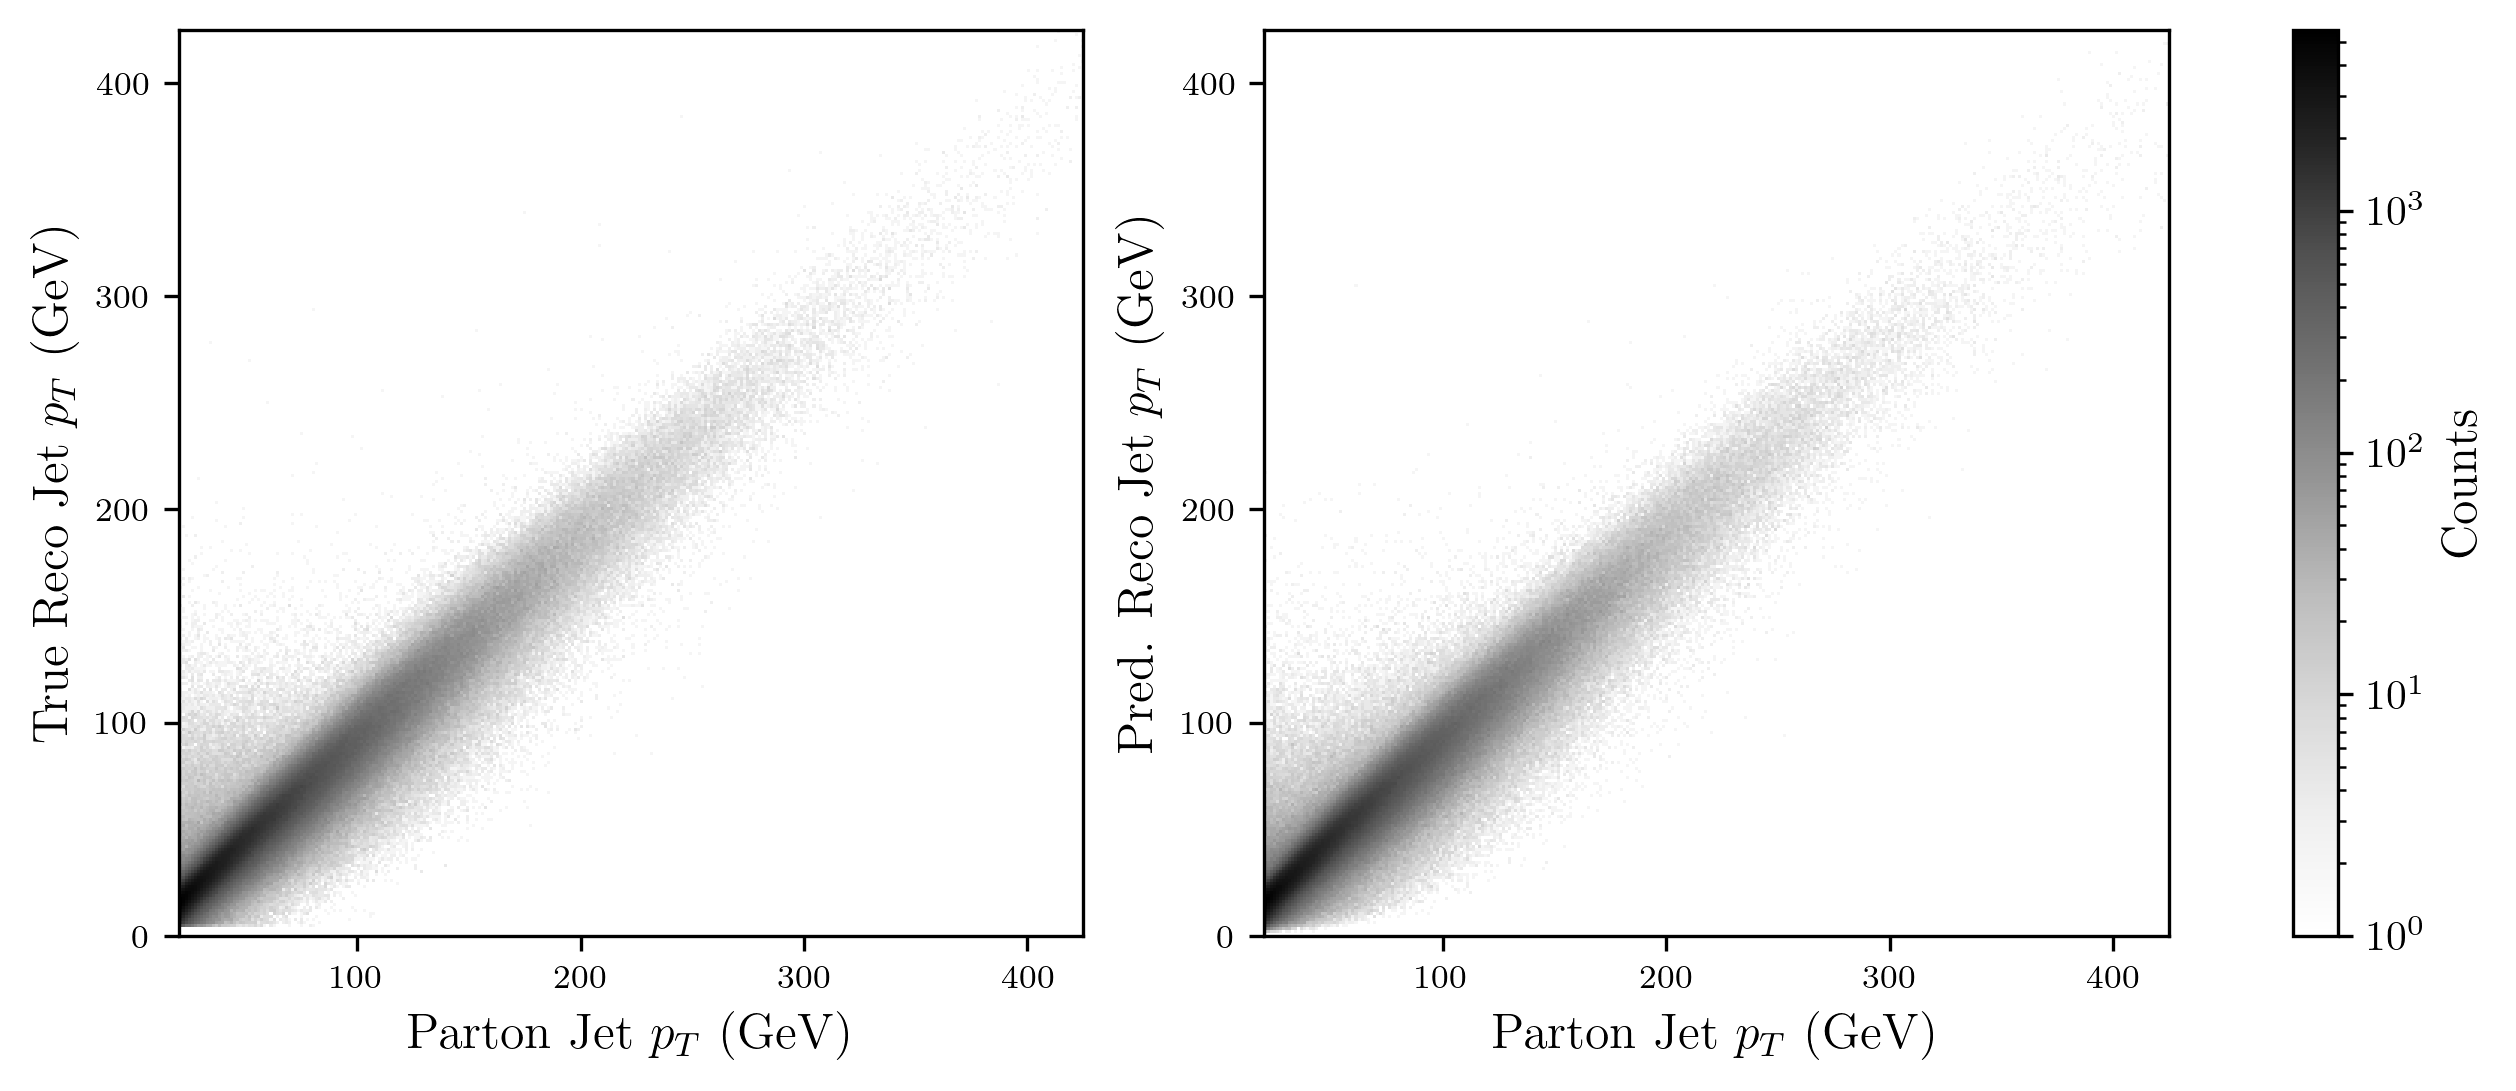

In [16]:
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
fig = plt.figure(figsize=(10.7,4), dpi=300)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
upper_end = 1000
x_low = 20
x_hi = 425
y_low = 0
y_hi = 425
num_bins=300
ytickvals = [0, 100, 200, 300, 400]
xtickvals = [100, 200, 300, 400]

h2, xbins, ybins = np.histogram2d(data[:, 0], data[:, 4], range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
ax1.imshow(h2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi), cmap="Greys", norm=mcolors.LogNorm())
ax1.set_xlabel(r"Parton Jet $p_T$ (GeV)", size=12)
ax1.set_ylabel(r"True Reco Jet $p_T$ (GeV)", size=12)
ax1.tick_params(axis='x', labelsize=8)
ax1.tick_params(axis='y', labelsize=8)
ax1.set_yticks(ytickvals)
ax1.set_xticks(xtickvals)

#ax1.set_title("\n".join(wrap(r"Joint Distribution of Parton Jet $P_t$ and True Reco Jet $P_t$", width=40)), size=8)


z2, xbins, ybins = np.histogram2d(data[:, 0], predict[:, 0], range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
hist = ax2.imshow(z2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi), cmap="Greys", norm=mcolors.LogNorm())
ax2.set_xlabel(r"Parton Jet $p_T$ (GeV)", size=12)
ax2.set_ylabel(r"Pred. Reco Jet $p_T$ (GeV)", size=12)
ax2.tick_params(axis='x', labelsize=8)
ax2.tick_params(axis='y', labelsize=8)
ax2.set_yticks(ytickvals)
ax2.set_xticks(xtickvals)
#ax2.set_yticks([0, 100, 200, 300, 400])
#ax2.set_title("\n".join(wrap(r"Joint Distribution of Parton Jet $P_t$ and Predicted Reco Jet $P_t$", width=40)), size=10)

#plt.xticks(fontsize=6)
#plt.yticks(fontsize=6)

#plt.tight_layout()
#fig.suptitle(r"Joint Distribution of Parton and Reco Jet $p_T$", size=16, x=0.435)
cb = plt.colorbar(hist, ax=[ax1, ax2])
cb.set_label(label="Counts", size=12)
#plt.savefig('../data/plots/jointdistribution.png')
#plt.show()

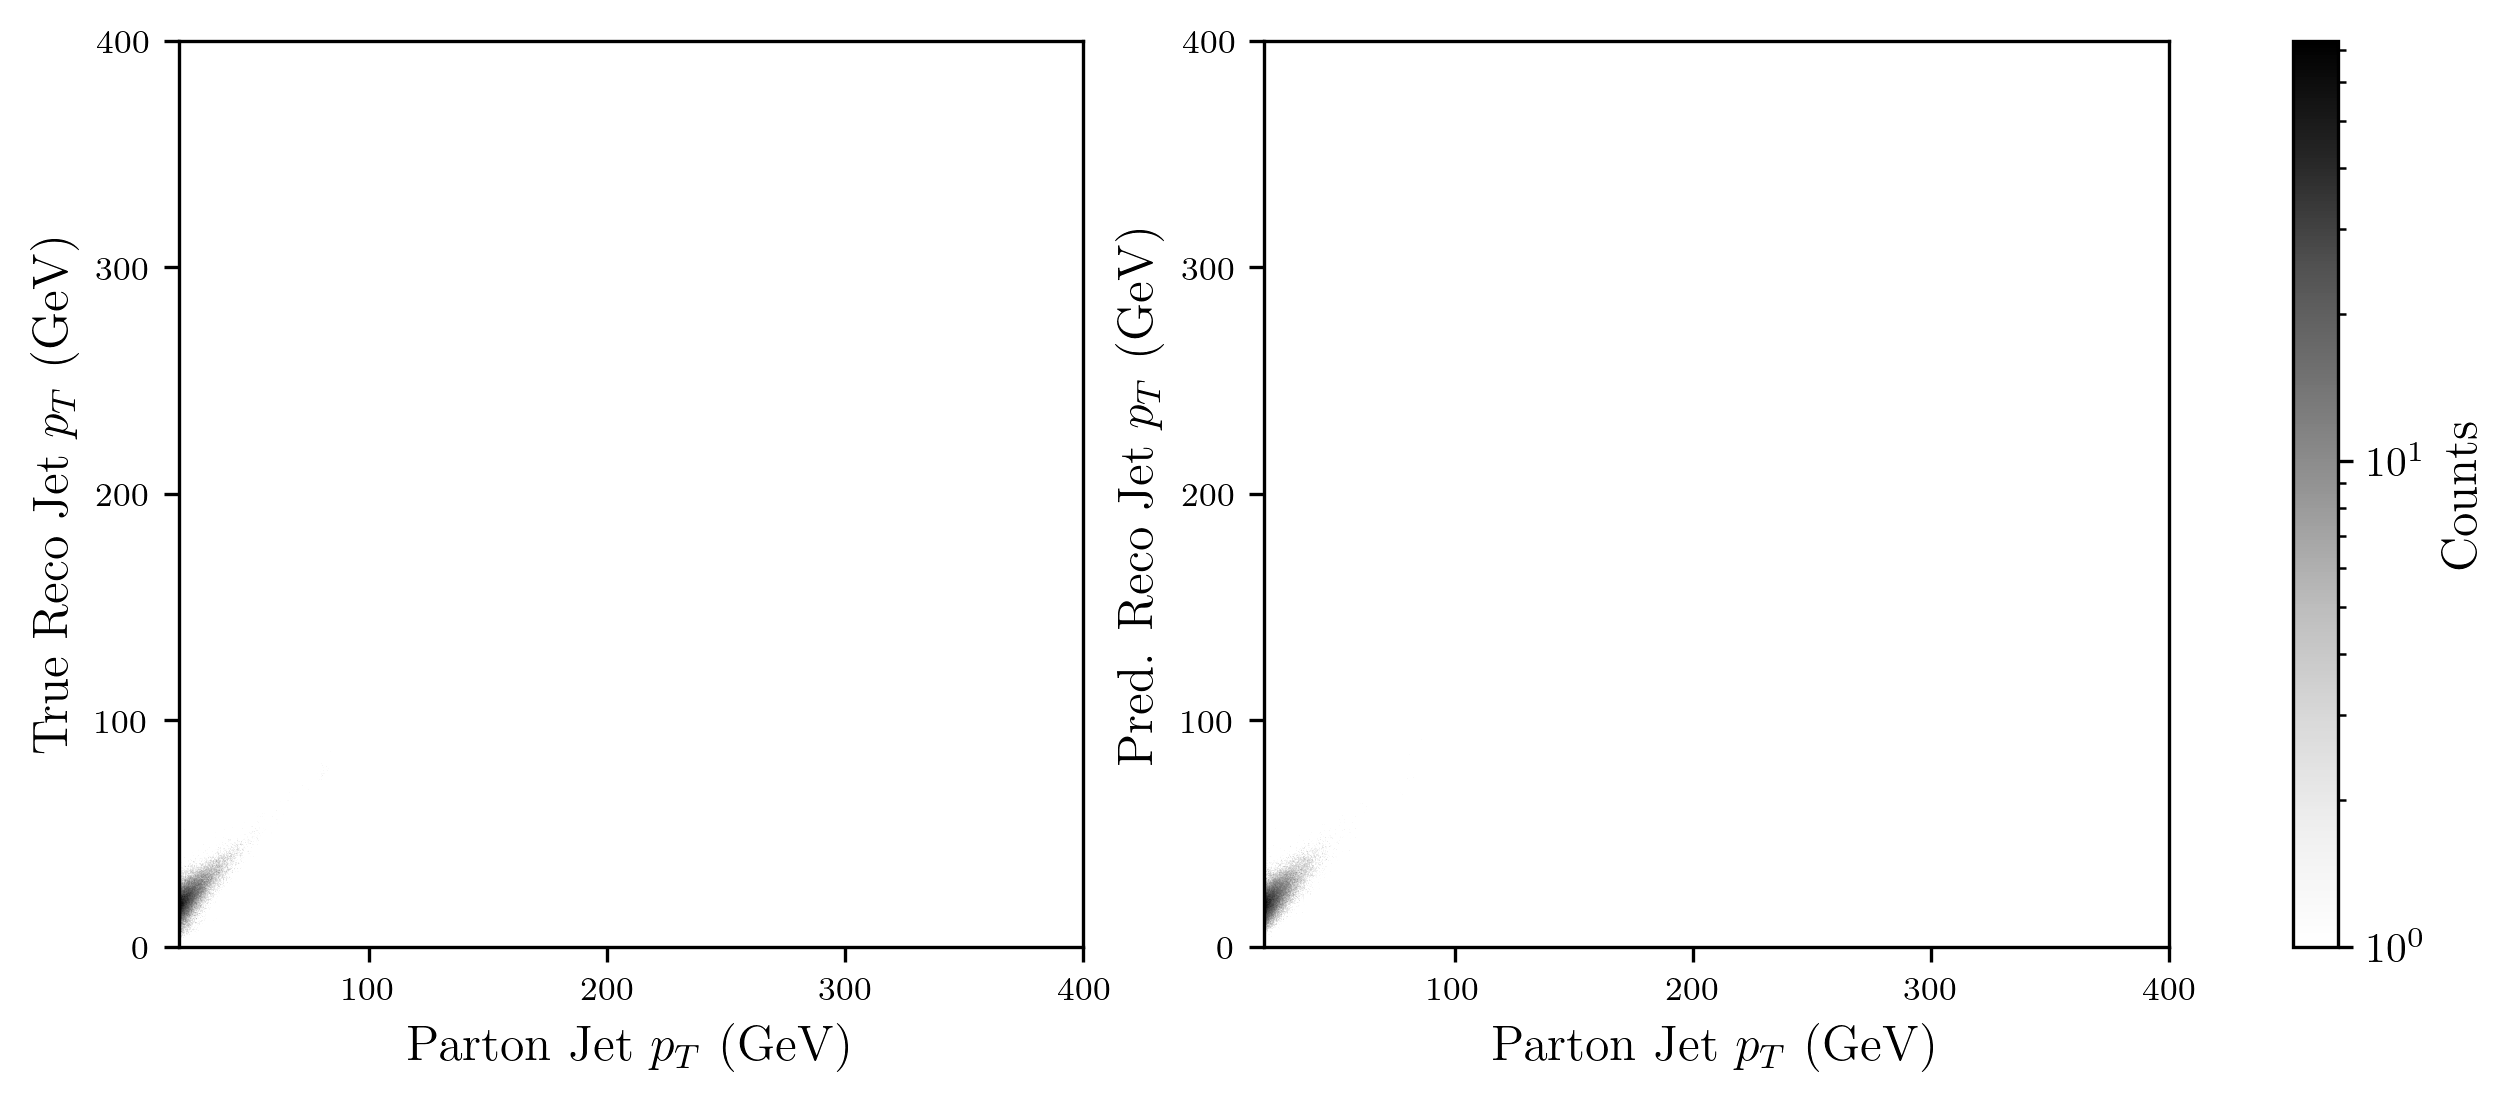

In [34]:
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
fig = plt.figure(figsize=(10.7,4), dpi=300)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
upper_end = 1000
x_low = 20
x_hi = 100
y_low = 0
y_hi = 100
num_bins=300
#ytickvals = [0, 100, 200, 300, 400]
#xtickvals = [100, 200, 300, 400]

h2, xbins, ybins = np.histogram2d(data[:, 3], data[:, 7], range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
ax1.imshow(h2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi), cmap="Greys", norm=mcolors.LogNorm())
ax1.set_xlabel(r"Parton Jet $p_T$ (GeV)", size=12)
ax1.set_ylabel(r"True Reco Jet $p_T$ (GeV)", size=12)
ax1.tick_params(axis='x', labelsize=8)
ax1.tick_params(axis='y', labelsize=8)
ax1.set_yticks(ytickvals)
ax1.set_xticks(xtickvals)

#ax1.set_title("\n".join(wrap(r"Joint Distribution of Parton Jet $P_t$ and True Reco Jet $P_t$", width=40)), size=8)


z2, xbins, ybins = np.histogram2d(data[:, 3], predict[:, 3], range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
hist = ax2.imshow(z2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi), cmap="Greys", norm=mcolors.LogNorm())
ax2.set_xlabel(r"Parton Jet $p_T$ (GeV)", size=12)
ax2.set_ylabel(r"Pred. Reco Jet $p_T$ (GeV)", size=12)
ax2.tick_params(axis='x', labelsize=8)
ax2.tick_params(axis='y', labelsize=8)
ax2.set_yticks(ytickvals)
ax2.set_xticks(xtickvals)
#ax2.set_yticks([0, 100, 200, 300, 400])
#ax2.set_title("\n".join(wrap(r"Joint Distribution of Parton Jet $P_t$ and Predicted Reco Jet $P_t$", width=40)), size=10)

#plt.xticks(fontsize=6)
#plt.yticks(fontsize=6)

#plt.tight_layout()
#fig.suptitle(r"Joint Distribution of Parton and Reco Jet $p_T$", size=16, x=0.435)
cb = plt.colorbar(hist, ax=[ax1, ax2])
cb.set_label(label="Counts", size=12)
#plt.savefig('../data/plots/jointdistribution.png')
#plt.show()

<ipython-input-28-fe3ec17cabef>:2: RuntimeWarning: divide by zero encountered in true_divide
  rel_diff = diff / h2
<ipython-input-28-fe3ec17cabef>:2: RuntimeWarning: invalid value encountered in true_divide
  rel_diff = diff / h2


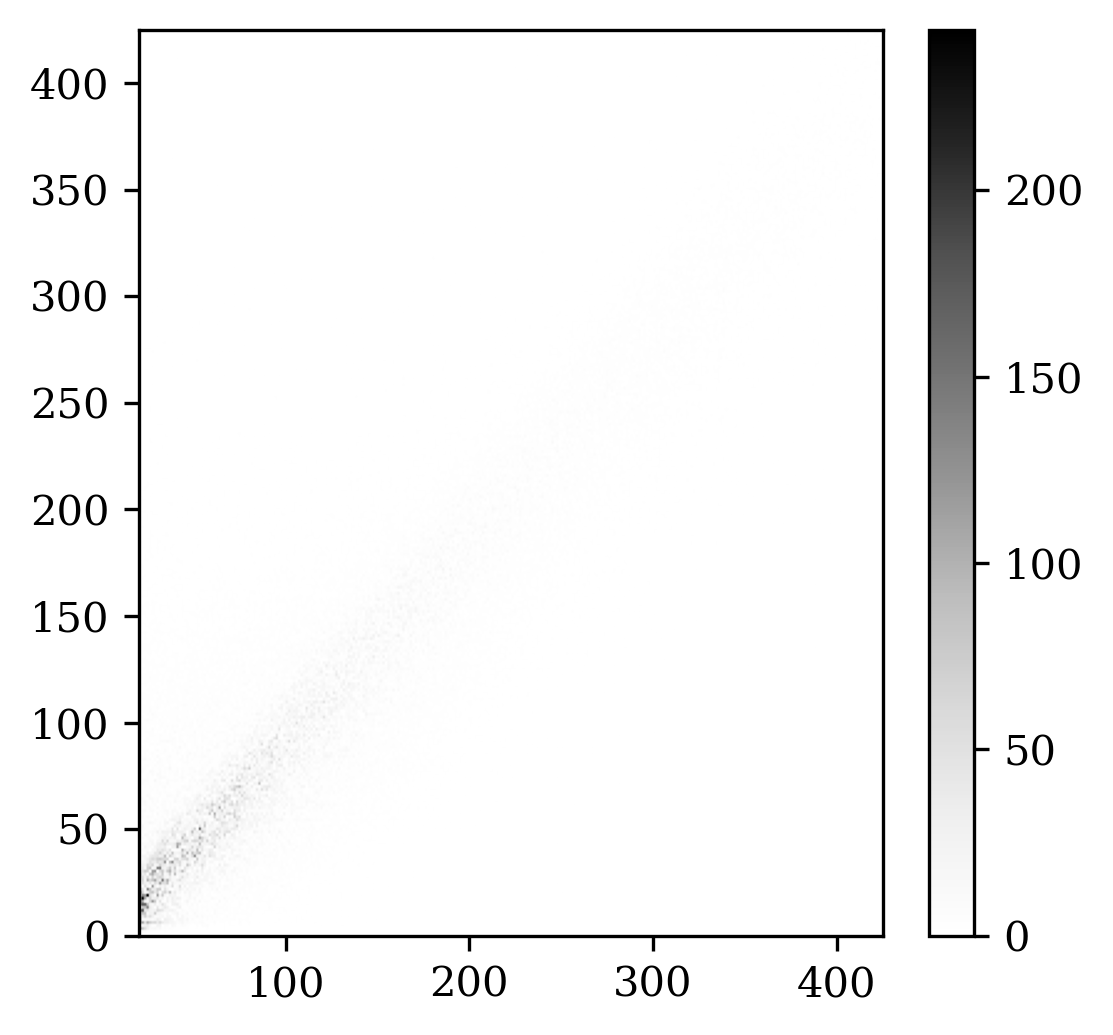

In [28]:
diff = np.abs(h2-z2)
rel_diff = diff / h2
fig = plt.figure(figsize=(4,4), dpi=300)
ax = fig.add_subplot(111)
hist = ax.imshow(diff.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi), cmap="Greys")#, norm=mcolors.LogNorm())
plt.colorbar(hist)
plt.show()


## Make Marginal Distribution Plots

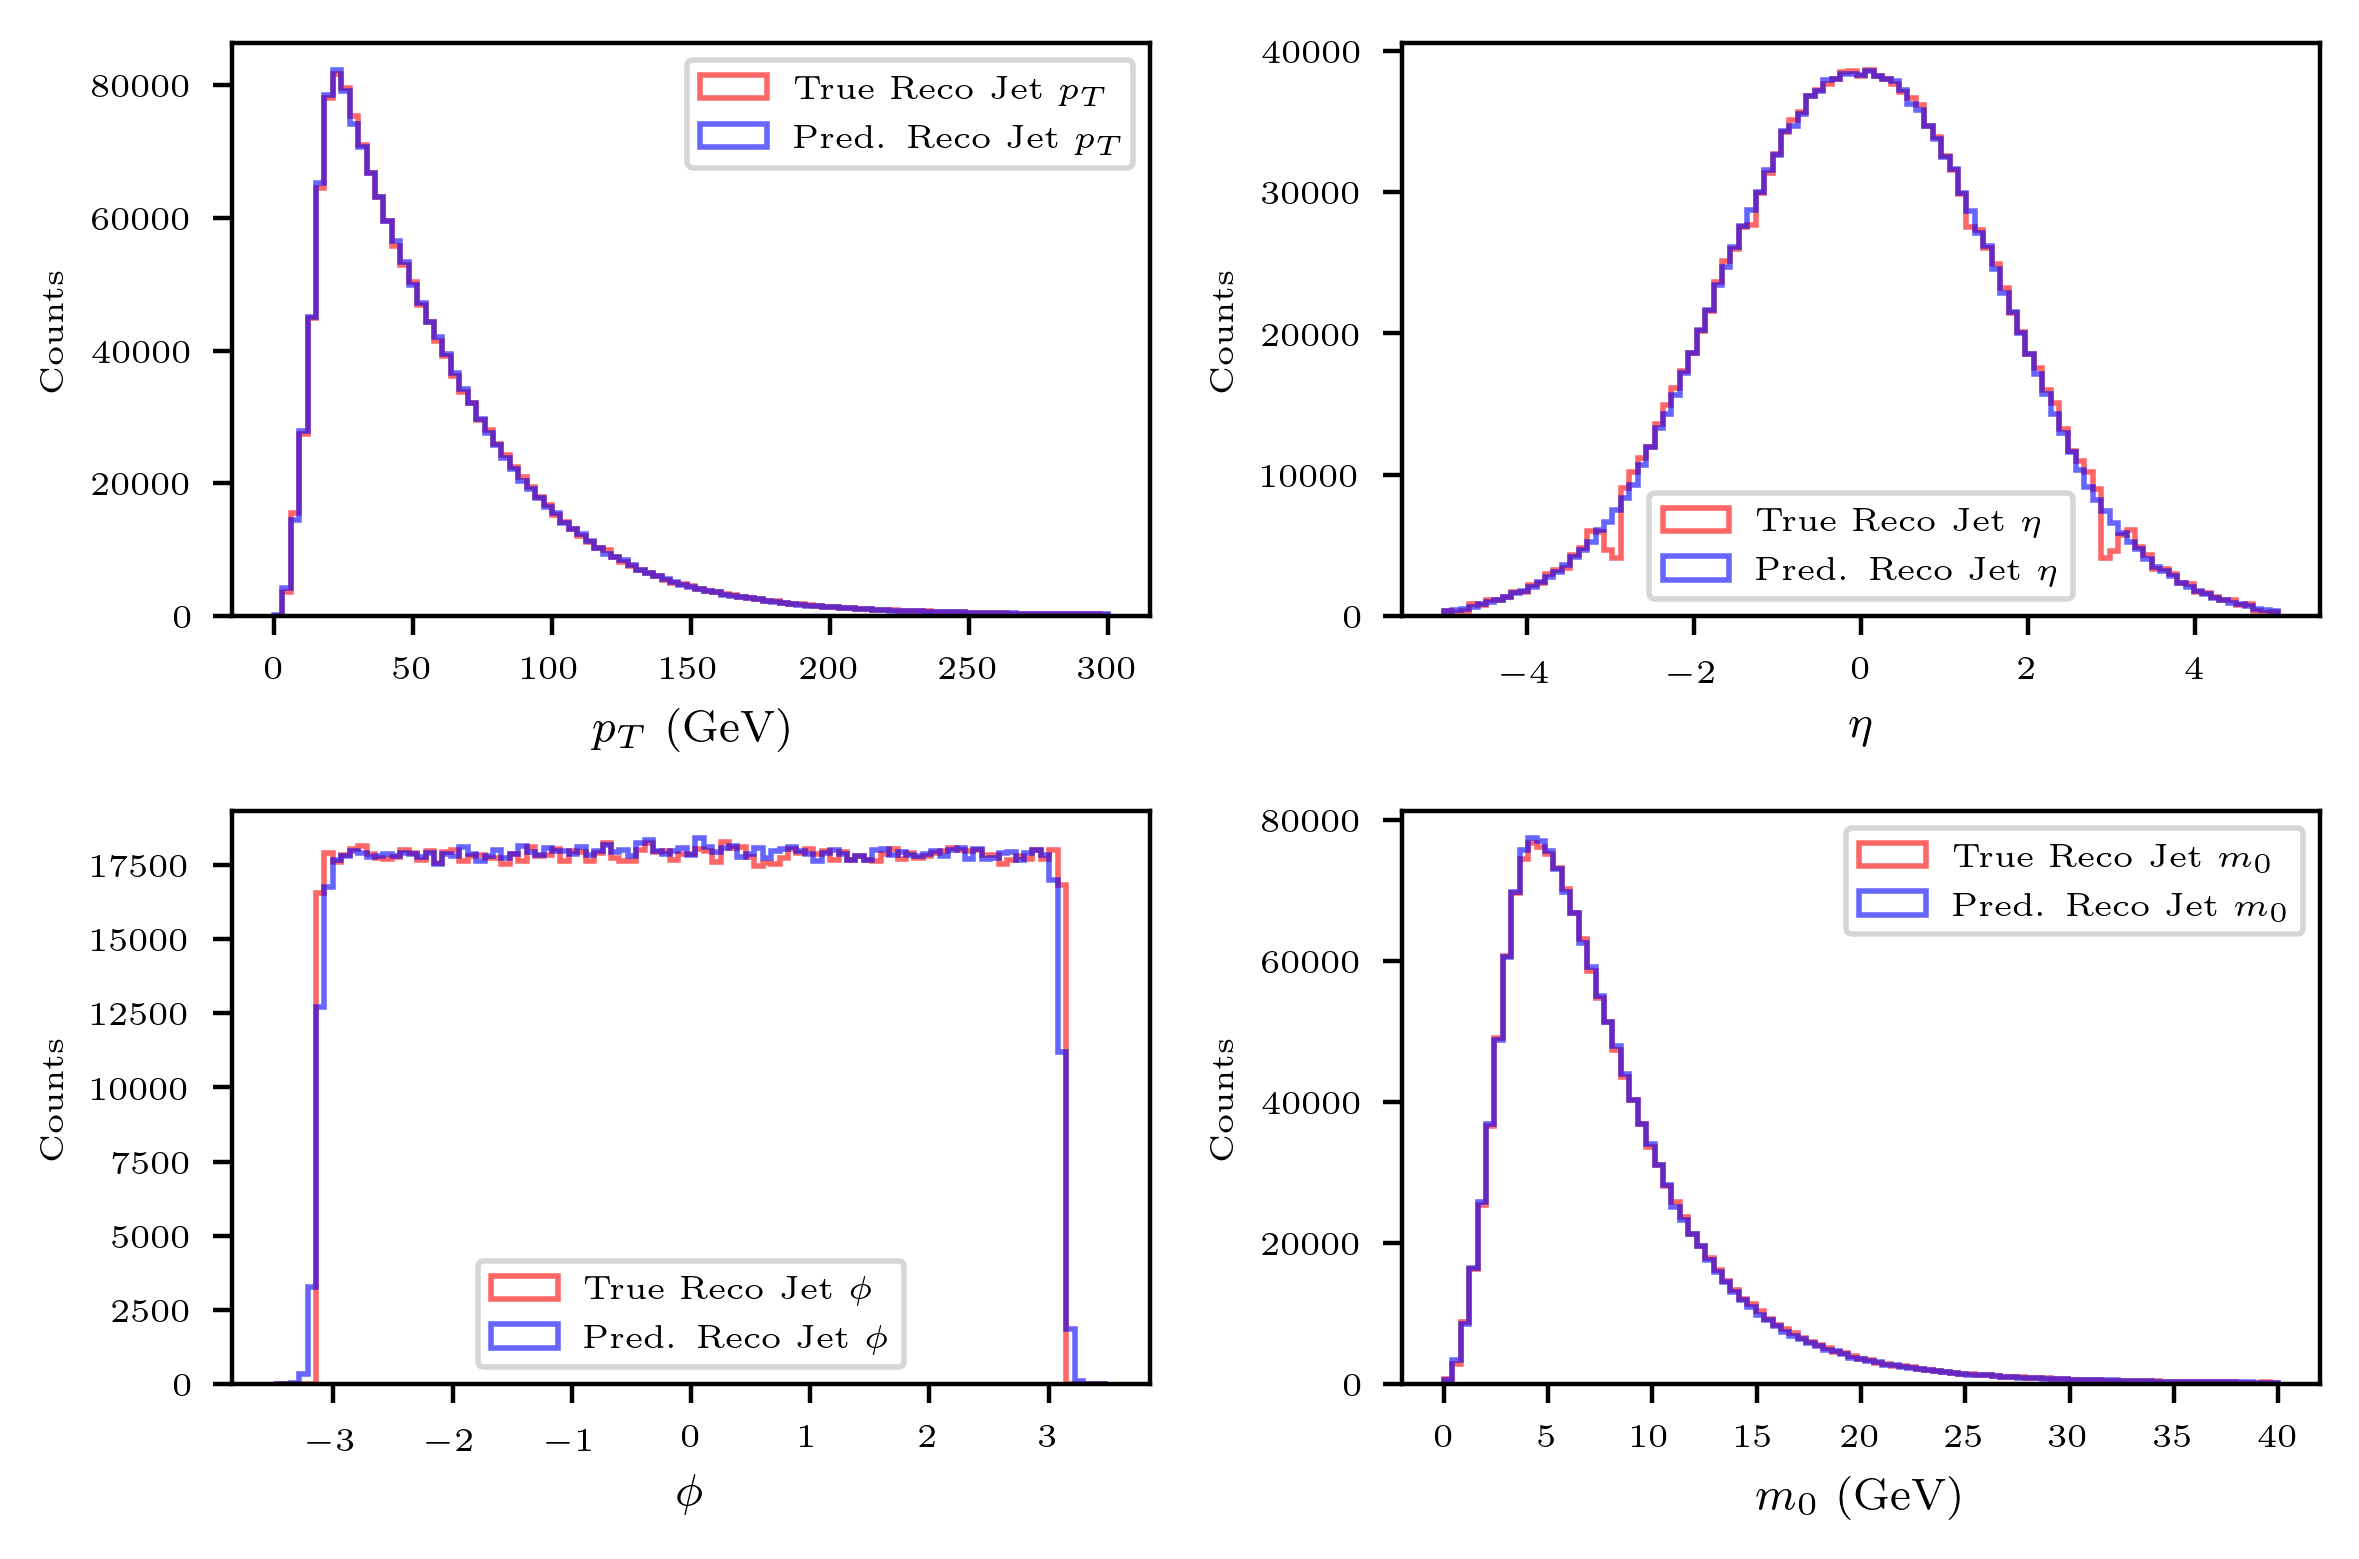

In [21]:
fig = plt.figure(figsize=(6,4), dpi=400)
bins = np.linspace(0, 300, 100)
ax1 = fig.add_subplot(221)
ax1.hist(data[:, 4], label=r"True Reco Jet $p_T$", bins=bins, alpha=0.6, ec="r", histtype='step')
ax1.hist(predict[:, 0], label=r"Pred. Reco Jet $p_T$", bins=bins, alpha=0.6, ec="b", histtype='step')
#ax1.set_title(r"True and Predicted Marginal Reco Jet $P_t$ Distributions")
ax1.set_xlabel(r"$p_T$ (GeV)", size=8)
ax1.set_ylabel("Counts", size=6)
ax1.tick_params(axis='x', labelsize=6)
ax1.tick_params(axis='y', labelsize=6)
ax1.legend(fontsize=6)

bins = np.linspace(-5, 5, 100)
ax2 = fig.add_subplot(222)
ax2.hist(data[:, 5], label=r"True Reco Jet $\eta$", bins=bins, alpha=0.6, ec="r", histtype='step')
ax2.hist(predict[:, 1], label=r"Pred. Reco Jet $\eta$", bins=bins, alpha=0.6, ec="b", histtype='step')
#ax2.set_title(r"True and Predicted Marginal Reco Jet $\eta$ Distributions")
ax2.tick_params(axis='x', labelsize=6)
ax2.tick_params(axis='y', labelsize=6)
ax2.set_xlabel(r"$\eta$", size=8)
ax2.set_ylabel("Counts", size=6)
ax2.legend(loc='lower center', fontsize=6)

bins = np.linspace(-3.5, 3.5, 100)
ax3 = fig.add_subplot(223)
ax3.hist(data[:, 6], label=r"True Reco Jet $\phi$", bins=bins, alpha=0.6, ec="r", histtype='step')
ax3.hist(predict[:, 2], label=r"Pred. Reco Jet $\phi$", bins=bins, ec="b", alpha=0.6, histtype='step')
#ax3.set_title(r"True and Predicted Marginal Jet $\phi$ Distributions")
ax3.tick_params(axis='x', labelsize=6)
ax3.tick_params(axis='y', labelsize=6)
ax3.set_xlabel(r"$\phi$", size=8)
ax3.set_ylabel("Counts", size=6)
ax3.legend(loc='lower center', fontsize=6)

bins = np.linspace(0, 40, 100)
ax4 = fig.add_subplot(224)
ax4.hist(data[:, 7], label=r"True Reco Jet $m_0$", bins=bins, alpha=0.6, ec="r", histtype='step')
ax4.hist(predict[:, 3], label=r"Pred. Reco Jet $m_0$", bins=bins, ec="b", alpha=0.6, histtype='step')
#ax4.set_title(r"True and Predicted Marginal Reco Jet Energy Distributions")
ax4.set_xlabel(r"$m_0$ (GeV)", size=8)
ax4.set_ylabel("Counts", size=6)
ax4.tick_params(axis='x', labelsize=6)
ax4.tick_params(axis='y', labelsize=6)
ax4.legend(fontsize=6)
plt.tight_layout()

#plt.show()
plt.savefig("../data/plots/marginalDists.pdf")

In [53]:
print(ks_2samp(data[:, 4], predict[:, 0]))
print(ks_2samp(data[:, 5], predict[:, 1]))
print(ks_2samp(data[:, 6], predict[:, 2]))
print(ks_2samp(data[:, 7], predict[:, 3]))
print(ks_2samp(predict[:, 0], data[:, 4], mode='asymp'))

KstestResult(statistic=0.0019246232291689758, pvalue=0.06396671312675173)
KstestResult(statistic=0.0024811278206010035, pvalue=0.006555142220033023)
KstestResult(statistic=0.002584463295992629, pvalue=0.0040304722168932605)
KstestResult(statistic=0.0032593731196441933, pvalue=0.0001032439934658096)
KstestResult(statistic=0.0019246232291689758, pvalue=0.06396671312675173)


True and Pred. Conditional $P_t$ Distributions for Parton Jet $P_t \in [18.0, 22.0]$ GeV
True and Pred. Conditional $P_t$ Distributions for Parton Jet $P_t \in [90.0, 110.0]$ GeV
True and Pred. Conditional $P_t$ Distributions for Parton Jet $P_t \in [270.0, 330.0]$ GeV
True and Pred. Conditional $P_t$ Distributions for Parton Jet $P_t \in [450.0, 550.0]$ GeV


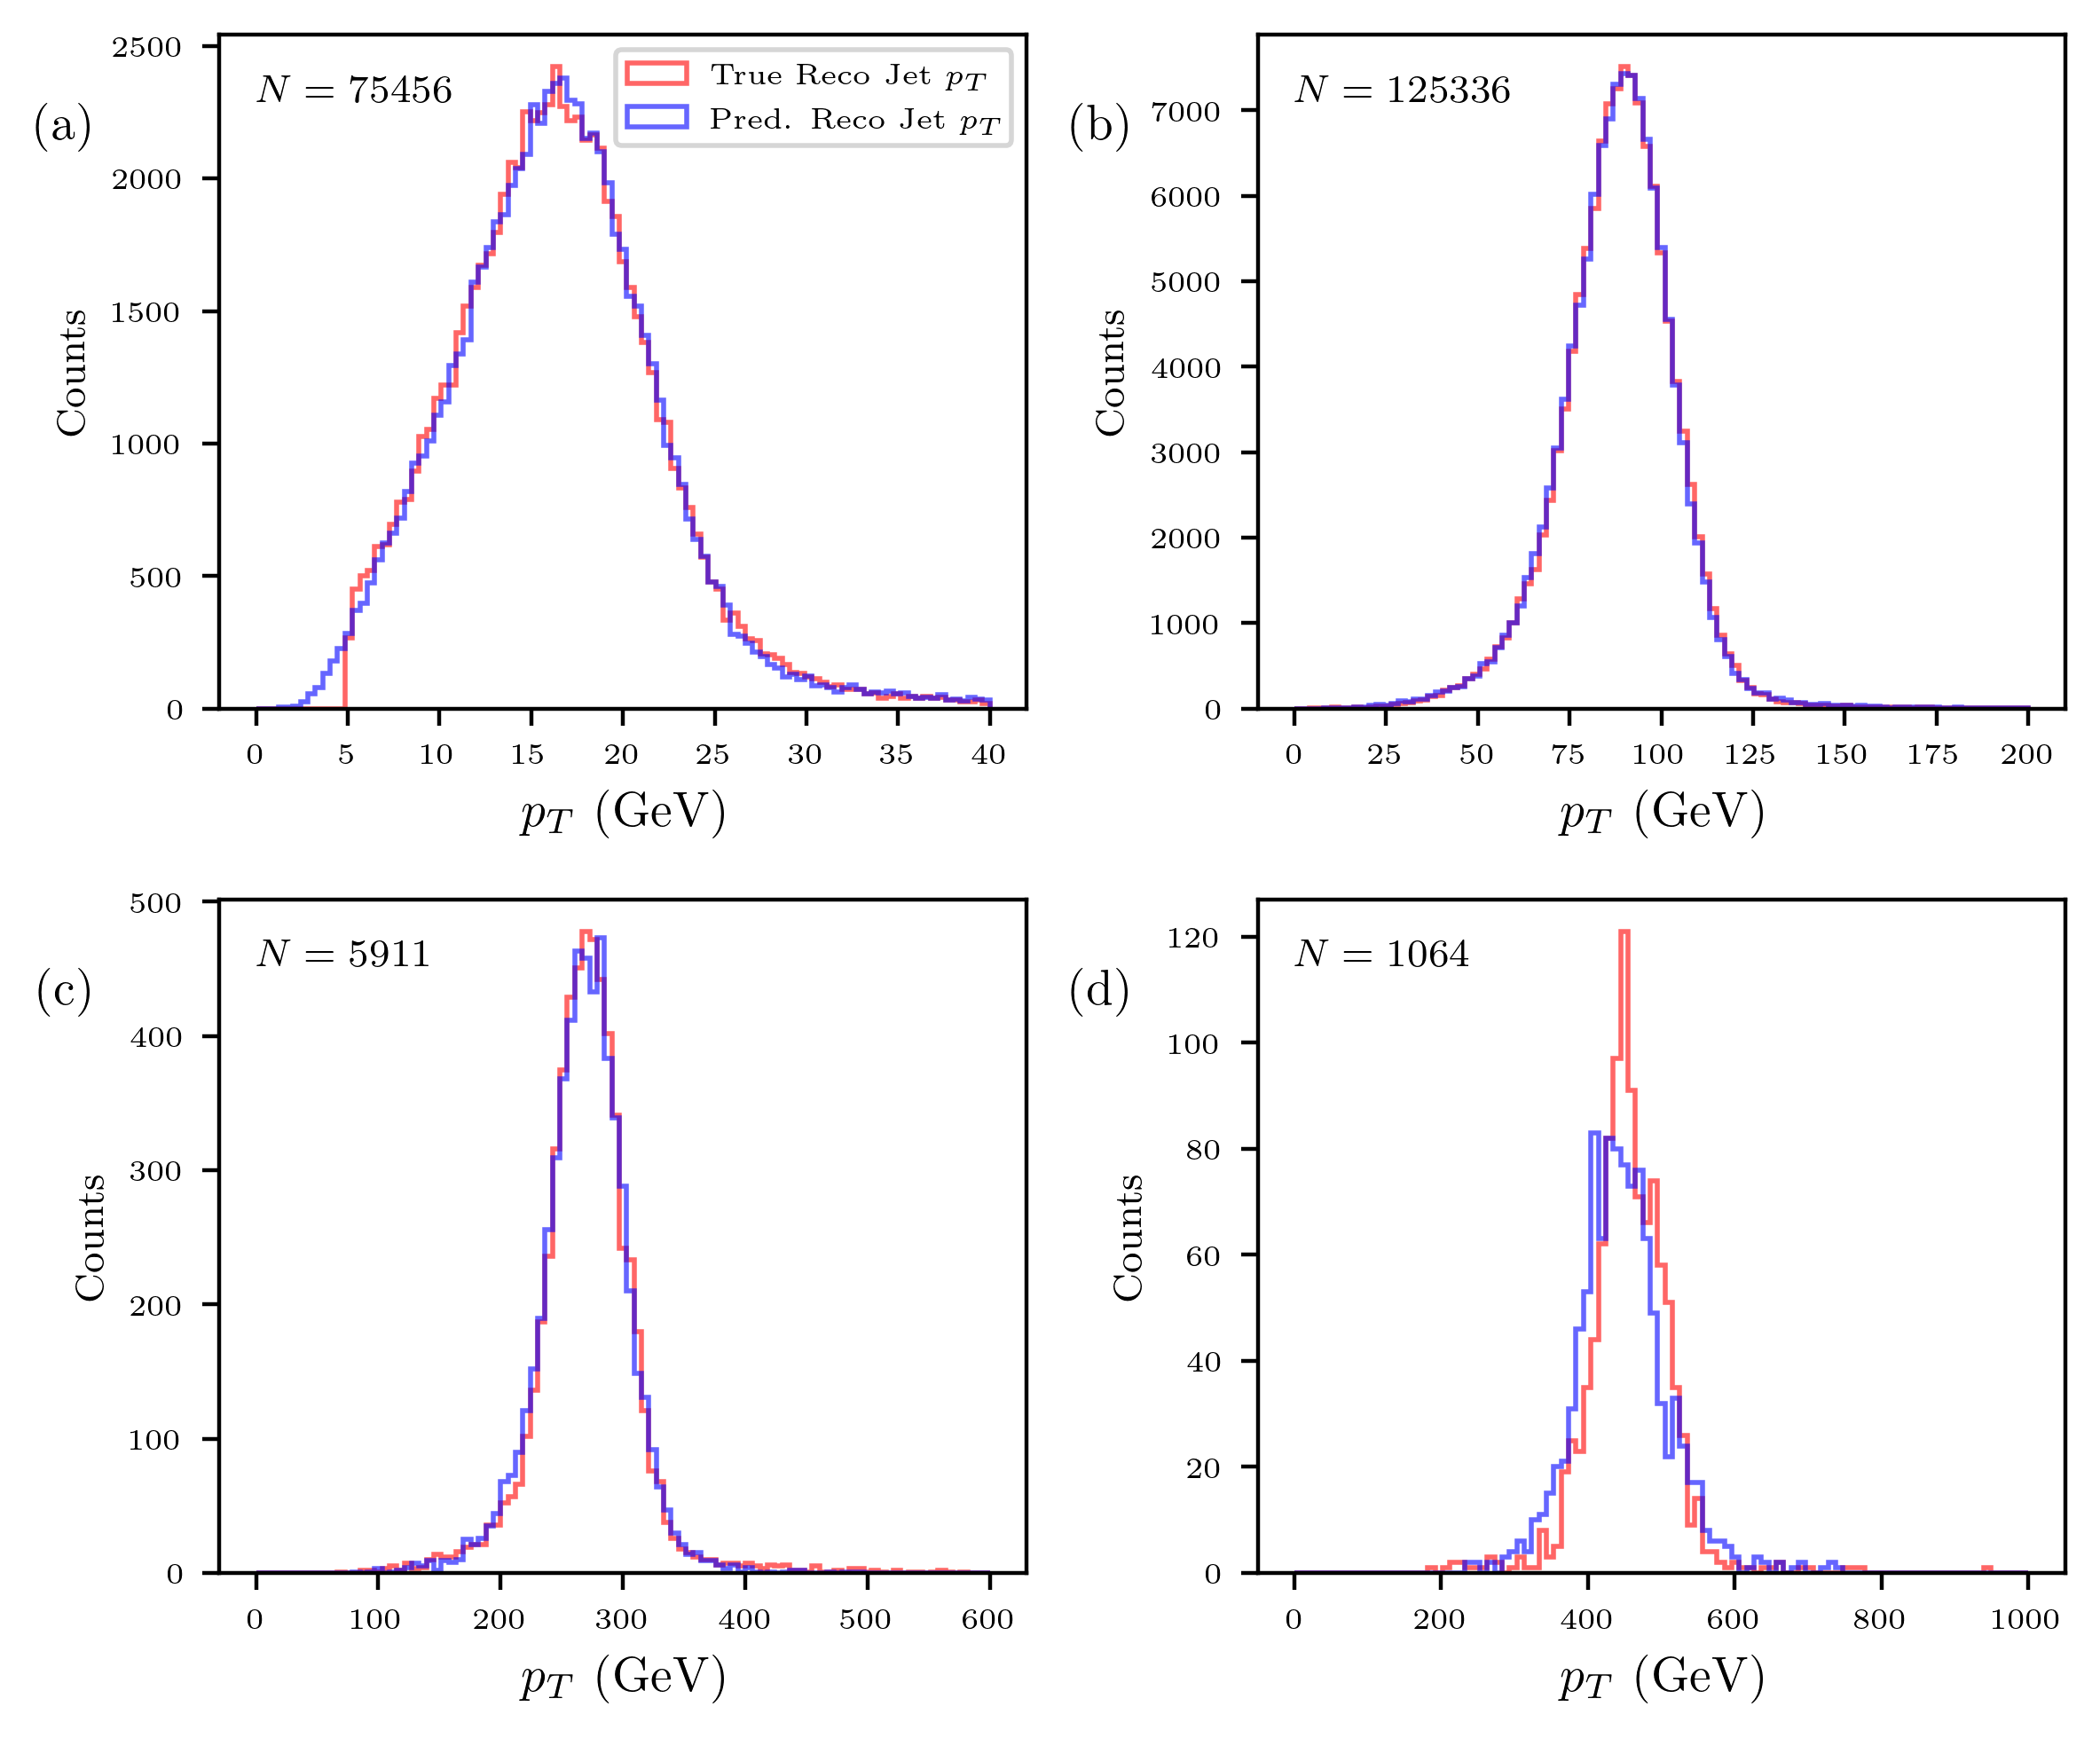

In [29]:
plt.rc('font', family='serif')
#range_highs = [40, 100, 200, 400, 600, 1000]
#range_lows = [0, 0, 0, 0, 0, 0, 0]
range_highs = [40, 200, 600, 1000]
range_lows = [0, 0, 0, 0, 0]
j = 0
nrow = 2; ncol = 2;
fig, axs = plt.subplots(nrows=nrow, ncols=ncol, figsize=(6,5), dpi=400)
ax = axs.flatten()
letters = ['(a)', '(b)', '(c)', '(d)']#, '(e)', '(f)']

#for center in [20, 50, 100, 200, 300, 500]:    
for center in [20, 100, 300, 500]:        
    recoPt = []
    predPt = []
    low = center - center/10
    high = center + center/10
    for i in range(len(data)):
        if (data[i, 0] > low and data[i, 0] < high):
            recoPt.append(data[i, 4])
            predPt.append(predict[i, 0])
        #if (len(recoPt) > 1400):
        #    break
    #print(ks_2samp(recoPt, predPt))
    bins = np.linspace(range_lows[j], range_highs[j], 100)
    #fig = plt.figure(figsize=(6,4), dpi=100)
    #ax = fig.add_subplot(111)
    ax[j].hist(recoPt, bins=bins, label=r'True Reco Jet $p_T$', alpha=0.6, ec="r", histtype='step')
    ax[j].hist(predPt, bins=bins, label=r'Pred. Reco Jet $p_T$', alpha=0.6, ec="b", histtype='step')
    ax[j].text(0,0.9*ax[j].get_ylim()[1], r"$N={}$".format(len(recoPt)), size=8)
    #ax.hist(energy, bins=bins, label='E', alpha=0.5)
    #if j==2 or j==3:
    ax[j].set_xlabel(r"$p_T$ (GeV)")
    ax[j].set_ylabel("Counts", size=8)
    ax[j].tick_params(axis='x', labelsize=6)
    ax[j].tick_params(axis='y', labelsize=6)
    #ax[j].set_ylabel("Count")
    #ax[j].set_title("Parton Jet $P_t =${} GeV".format(center), size=10)
   # ax[j].set_title("\n".join(wrap(r"True and Pred. Conditional $P_t$ Distributions for Parton Jet $P_t \in [{}, {}]$ GeV".format(low, high), width=50)), fontsize=8)
    print(r"True and Pred. Conditional $P_t$ Distributions for Parton Jet $P_t \in [{}, {}]$ GeV".format(low, high))
    #ax.axvline(x=center/2)
    ax[j].text(-0.15, 0.9, letters[j], fontsize=10, transform=ax[j].transAxes, va='top', ha='right')
    if j ==0:
        ax[j].legend(fontsize=6)
    #fig.savefig("../data/plots/PtDistLog{}.pdf".format(j), facecolor="white", transparent="True")
    j+=1
#fig.suptitle(r"Conditional Reco $P_t$ Distributions")
plt.tight_layout()
plt.savefig("../data/plots/ConditionalPtDist.pdf")
#plt.show()



In [181]:
print(data[57, :])
#print(normalized_data[6, :])

[165.588      0.816852  -0.638159 224.319    148.319      0.81323
  -0.640312 201.094   ]


In [124]:
same_point1 = np.zeros((500000, 4))
same_point2 = np.zeros((500000, 4))
same_point3 = np.zeros((500000, 4))
same_point4 = np.zeros((500000, 4))
same_point5 = np.zeros((500000, 4))
same_point6 = np.zeros((500000, 4))
same_point7 = np.zeros((500000, 4))
same_point8 = np.zeros((500000, 4))

In [125]:
for i in range(len(same_point)):
    same_point1[i, :] = normalized_data[0, :]
    same_point2[i, :] = normalized_data[6, :]
    same_point3[i, :] = normalized_data[10, :]
    same_point4[i, :] = normalized_data[12, :]
    same_point5[i, :] = normalized_data[9, :]
    same_point6[i, :] = normalized_data[14, :]
    same_point7[i, :] = normalized_data[36, :]
    same_point8[i, :] = normalized_data[57, :]

In [126]:
repeat_predict1 = np.array(cwgan.make_generator_predictions(same_point1))
repeat_predict1 = repeat_predict1 * reco_std + reco_mean
repeat_predict1[:, 0] = 10**repeat_predict1[:, 0]
repeat_predict1[:, 3] = 10**repeat_predict1[:, 3]

repeat_predict2 = np.array(cwgan.make_generator_predictions(same_point2))
repeat_predict2 = repeat_predict2 * reco_std + reco_mean
repeat_predict2[:, 0] = 10**repeat_predict2[:, 0]
repeat_predict2[:, 3] = 10**repeat_predict2[:, 3]

repeat_predict3 = np.array(cwgan.make_generator_predictions(same_point3))
repeat_predict3 = repeat_predict3 * reco_std + reco_mean
repeat_predict3[:, 0] = 10**repeat_predict3[:, 0]
repeat_predict3[:, 3] = 10**repeat_predict3[:, 3]

repeat_predict4 = np.array(cwgan.make_generator_predictions(same_point4))
repeat_predict4 = repeat_predict4 * reco_std + reco_mean
repeat_predict4[:, 0] = 10**repeat_predict4[:, 0]
repeat_predict4[:, 3] = 10**repeat_predict4[:, 3]

repeat_predict5 = np.array(cwgan.make_generator_predictions(same_point5))
repeat_predict5 = repeat_predict5 * reco_std + reco_mean
repeat_predict5[:, 0] = 10**repeat_predict5[:, 0]
repeat_predict5[:, 3] = 10**repeat_predict5[:, 3]

repeat_predict6 = np.array(cwgan.make_generator_predictions(same_point6))
repeat_predict6 = repeat_predict6 * reco_std + reco_mean
repeat_predict6[:, 0] = 10**repeat_predict6[:, 0]
repeat_predict6[:, 3] = 10**repeat_predict6[:, 3]

repeat_predict7 = np.array(cwgan.make_generator_predictions(same_point7))
repeat_predict7 = repeat_predict7 * reco_std + reco_mean
repeat_predict7[:, 0] = 10**repeat_predict7[:, 0]
repeat_predict7[:, 3] = 10**repeat_predict7[:, 3]

repeat_predict8 = np.array(cwgan.make_generator_predictions(same_point8))
repeat_predict8 = repeat_predict8 * reco_std + reco_mean
repeat_predict8[:, 0] = 10**repeat_predict8[:, 0]
repeat_predict8[:, 3] = 10**repeat_predict8[:, 3]

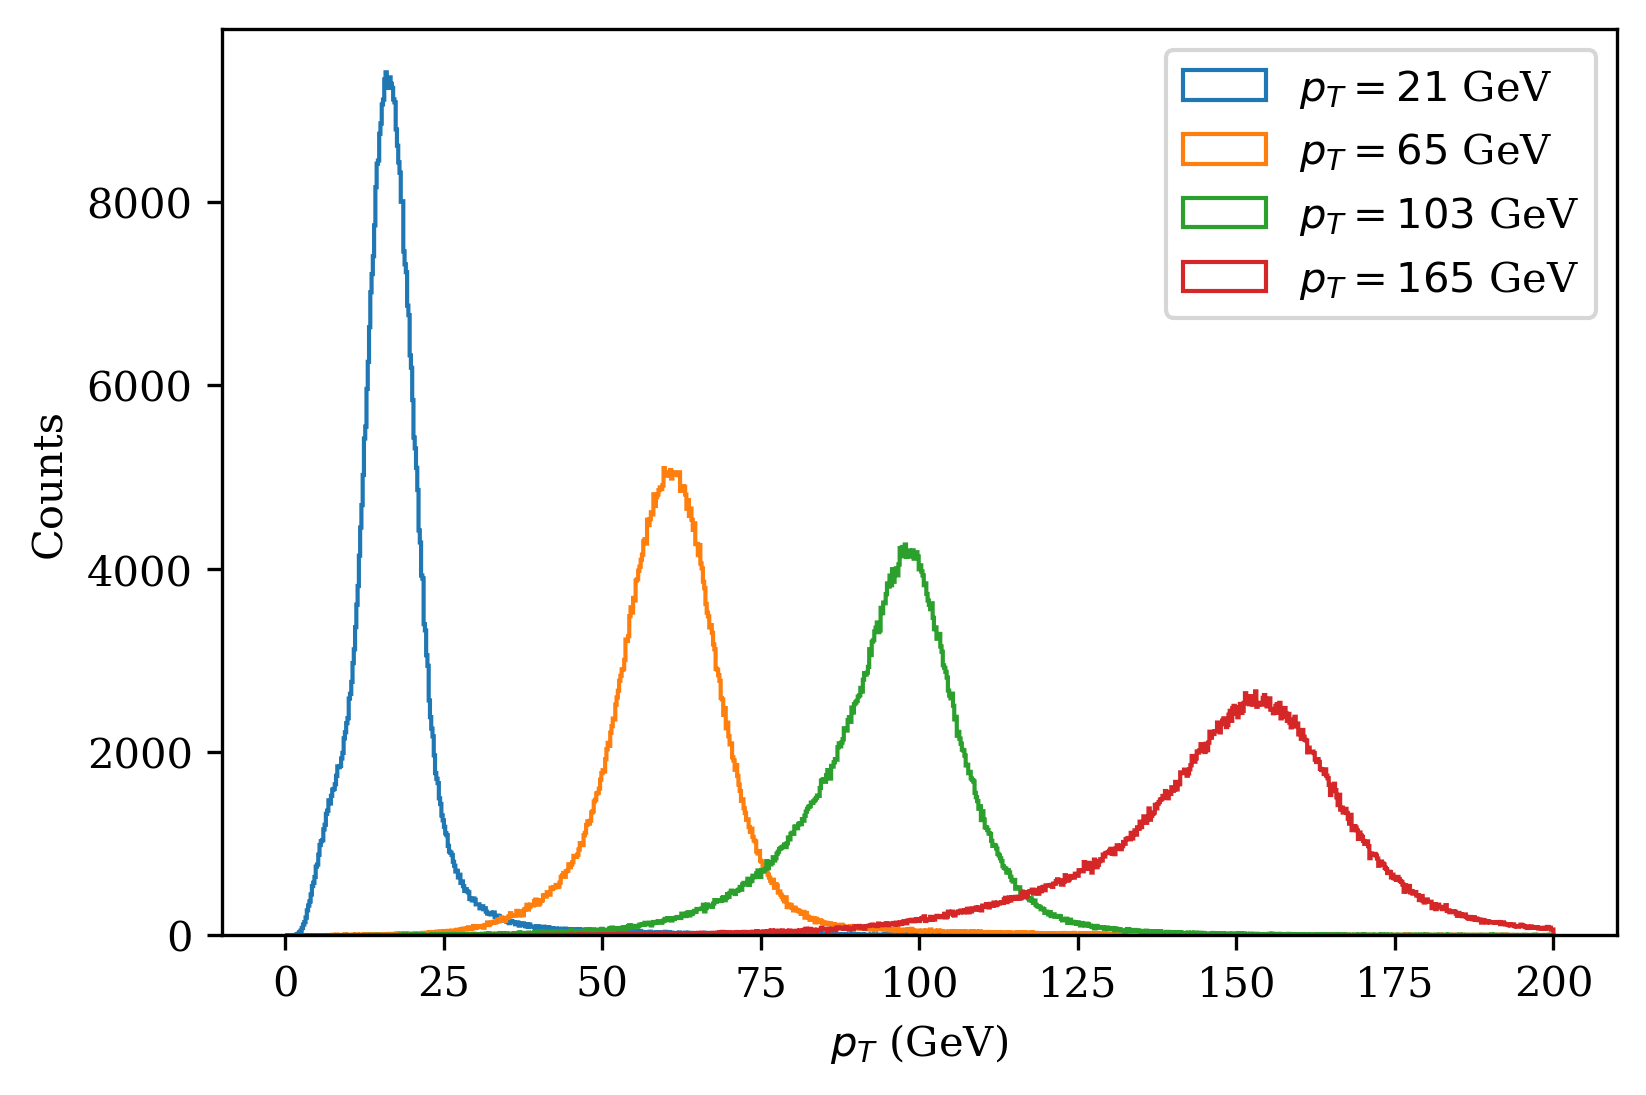

In [182]:
fig = plt.figure(figsize=(6, 4), dpi=300)
ax = fig.add_subplot(111) 
bins = np.linspace(0, 200, 1000)
#ax.hist(repeat_predict1[:, 0], bins=bins, histtype='step')

#ax.hist(repeat_predict3[:, 0], bins=bins, histtype='step')
ax.hist(repeat_predict4[:, 0], bins=bins, histtype='step', label=r'$p_T = 21$ GeV')
#ax.hist(repeat_predict5[:, 0], bins=bins, histtype='step')
#ax.hist(repeat_predict6[:, 0], bins=bins, histtype='step')
ax.hist(repeat_predict7[:, 0], bins=bins, histtype='step', label=r'$p_T = 65$ GeV')
ax.hist(repeat_predict2[:, 0], bins=bins, histtype='step', label=r'$p_T = 103$ GeV')
ax.hist(repeat_predict8[:, 0], bins=bins, histtype='step', label=r'$p_T = 165$ GeV')
#ax.set_title(r"Distribution of 500,000 simulations of one jet with $p_t = 103$ GeV.")
ax.set_xlabel(r"$p_T$ (GeV)")
ax.set_ylabel("Counts")
ax.legend()
plt.savefig("../data/plots/repeatedDists.pdf")
plt.show()

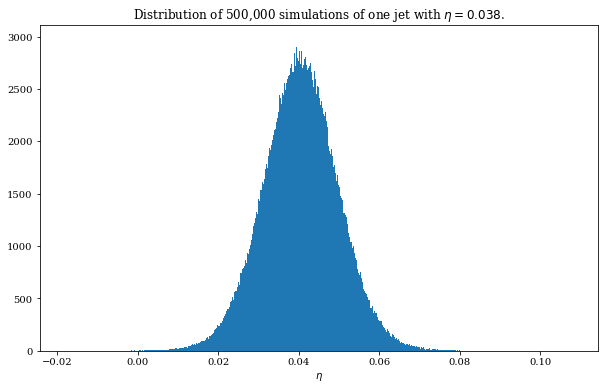

In [18]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111) 
ax.hist(repeat_predict[:, 1], bins=1000)
ax.set_title(r"Distribution of 500,000 simulations of one jet with $\eta = 0.038$.")
ax.set_xlabel(r"$\eta$")
plt.show()

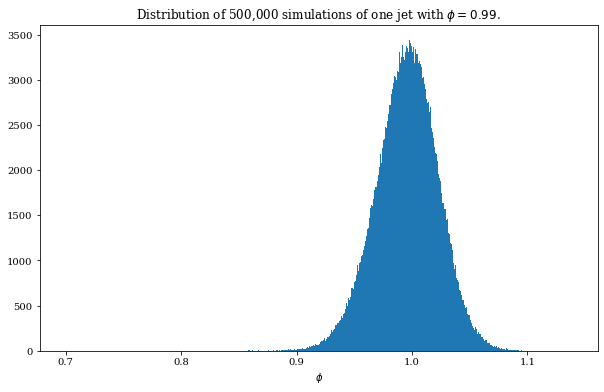

In [19]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111) 
ax.hist(repeat_predict[:, 2], bins=1000)
ax.set_title(r"Distribution of 500,000 simulations of one jet with $\phi = 0.99$.")
ax.set_xlabel(r"$\phi$")
plt.show()

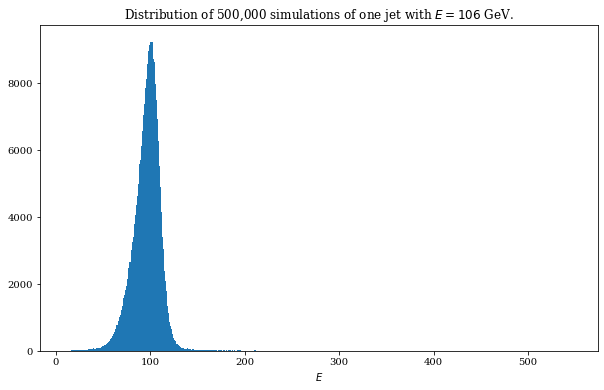

In [20]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111) 
ax.hist(repeat_predict[:, 3], bins=1000)
ax.set_title(r"Distribution of 500,000 simulations of one jet with $E = 106$ GeV.")
ax.set_xlabel(r"$E$")
plt.show()

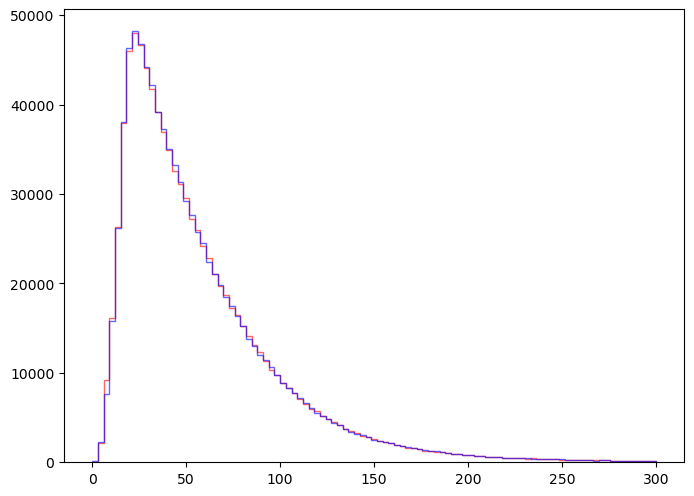

In [16]:
fig = plt.figure(figsize=(8,6), dpi=100)
ax = fig.add_subplot(111)
bins = np.linspace(0, 300, 100)
ax.hist(data[:, 4], label=r"True Reco Jet $p_T$", bins=bins, alpha=0.6, ec="r", histtype='step')
ax.hist(predict[:, 0], label=r"Pred. Reco Jet $p_T$", bins=bins, alpha=0.6, ec="b", histtype='step')
plt.show()

In [17]:

print(true_hist)
print(pred_hist)
print(pred_hist/true_hist)

[    0  2142  9205 16178 26311 37900 45970 47948 46668 44063 41717 39178
 36929 34941 32625 31123 29573 27223 25982 24144 22822 21063 19759 18758
 17303 16464 15232 14129 13102 12291 11309 10360  9751  8853  8292  7725
  7073  6477  6007  5740  5178  4807  4460  4115  3733  3486  3244  2956
  2790  2612  2380  2234  2148  1933  1825  1639  1561  1480  1300  1301
  1144  1108  1087   920   882   846   785   670   689   629   634   559
   533   496   450   467   401   456   364   379   353   321   288   258
   266   277   227   221   205   226   209   189   180   179   150   166
   139   155   119]
[  161  2315  7656 15783 26168 38013 46362 48243 46778 44227 42195 39135
 37271 35065 33243 31310 29199 27625 25738 24503 22397 21004 19858 18474
 17511 16370 15184 13794 12978 12037 11388 10650  9738  8904  8271  7729
  7226  6594  6025  5492  5187  4832  4404  4180  3676  3425  3116  3084
  2819  2527  2402  2256  2126  1910  1785  1748  1565  1464  1329  1250
  1220  1108  1007   936   880 

<ipython-input-17-a9e6a266f913>:5: RuntimeWarning: divide by zero encountered in true_divide
  print(pred_hist/true_hist)


In [40]:
plt.rc('text', usetex=False)

<ipython-input-37-3ad974ed19e6>:17: RuntimeWarning: divide by zero encountered in true_divide
  ax1.hist(bins[: 99], 99, weights=pred_hist/true_hist, histtype='step', lw=2)


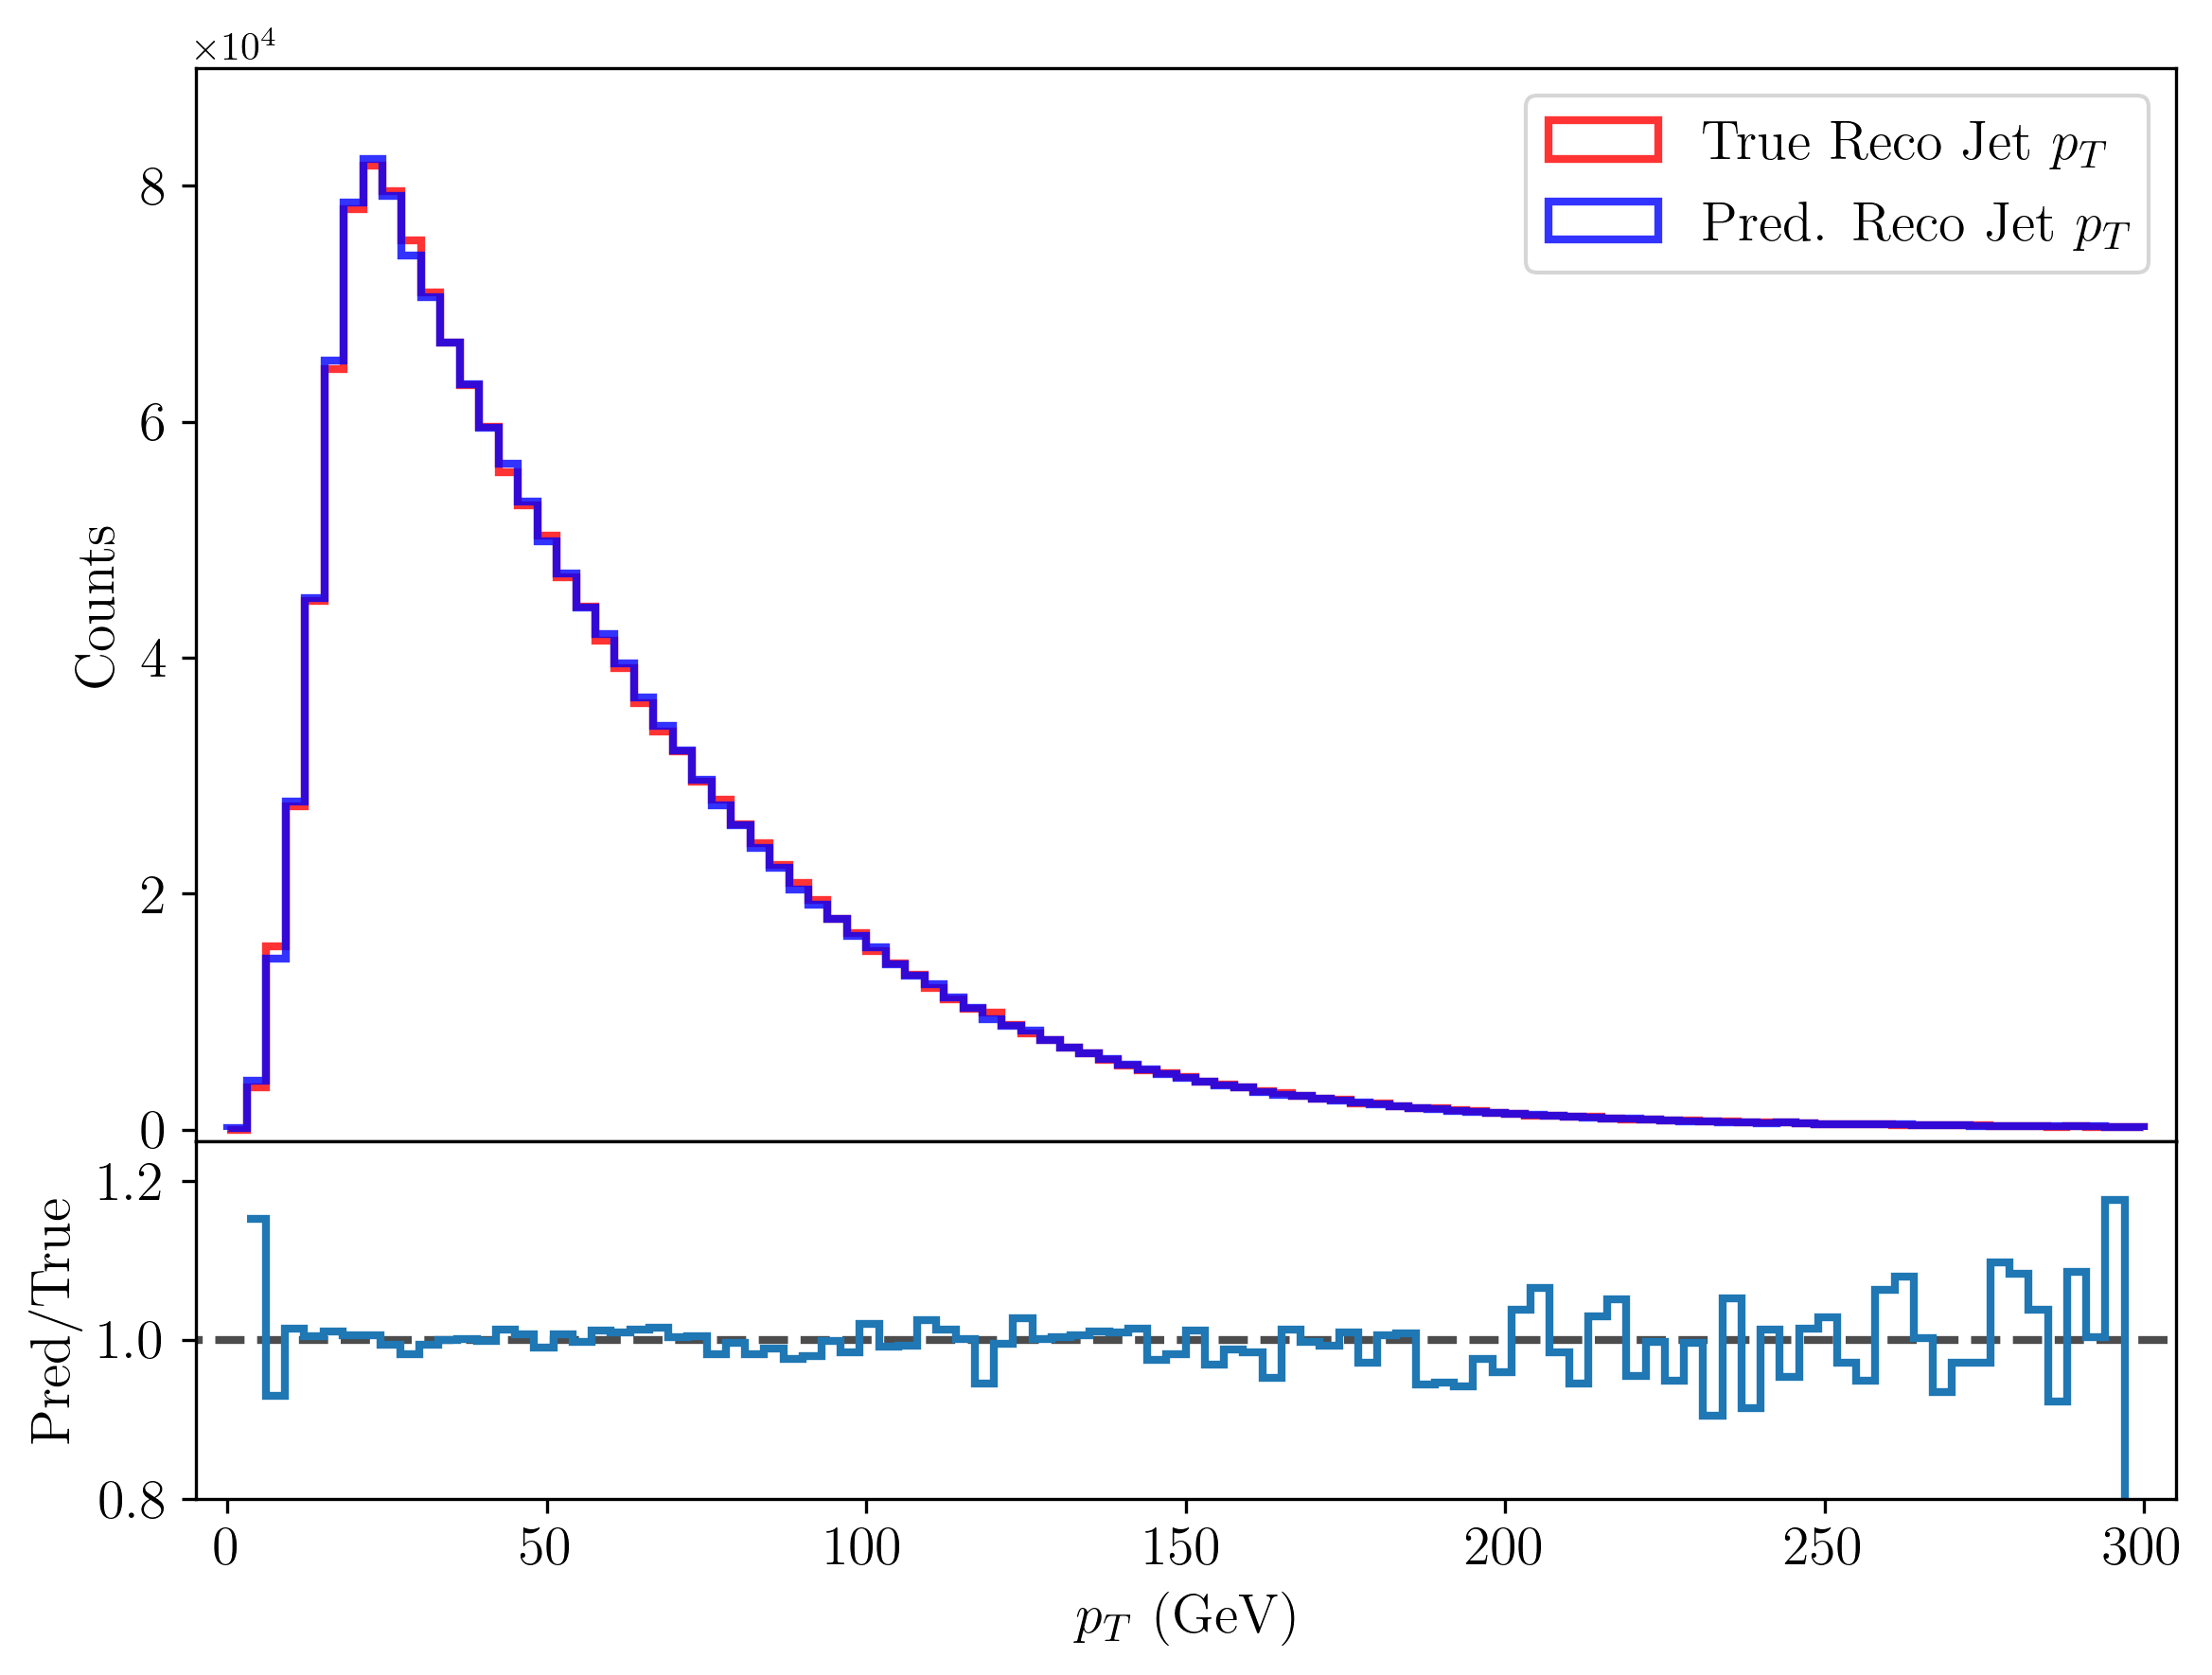

In [37]:
bins = np.linspace(0, 300, 100)
true_hist, _ = np.histogram(data[:, 4], bins=bins)
pred_hist, _ = np.histogram(predict[:, 0], bins=bins)
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
fig, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1], 'hspace': 0}, figsize=(8,6), dpi=300, sharex=True)
ax0.hist(data[:, 4], label=r"True Reco Jet $p_T$", bins=bins, alpha=0.8, ec="r", histtype='step', lw=2)
ax0.set_ylim(-1000, 90000)
ax0.hist(predict[:, 0], label=r"Pred. Reco Jet $p_T$", bins=bins, alpha=0.8, ec="b", histtype='step', lw=2)
ax1.set_xlabel(r"$p_T$ (GeV)", size=14)
ax0.set_ylabel("Counts", size=14)
ax0.legend(prop={'size': 14})
ax0.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
#ax0.set_title(r"Predicted and True Reco Jet $p_T$ Distributions", size=20)
ax0.tick_params(axis='y', labelsize=14)
#ax.bar(bins[:-1], pred_hist/true_hist, width=(bins[1]-bins[0]), align='edge', color=None)
ax1.hist(bins[: 99], 99, weights=pred_hist/true_hist, histtype='step', lw=2)
ax1.set_ylim(0.8, 1.25)
ax1.set_ylabel(r'Pred/True', size=14)
ax1.hlines(1.0, xmin=-100, xmax=400, linestyle='dashed', color='black', lw=2, alpha=0.7)
ax1.set_xlim(-5, 305)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
#ax1.set_xticklabels(xlabels, fontsize=12)
fig.tight_layout()
plt.savefig("../data/plots/ptDistFancy.pdf")
plt.show()

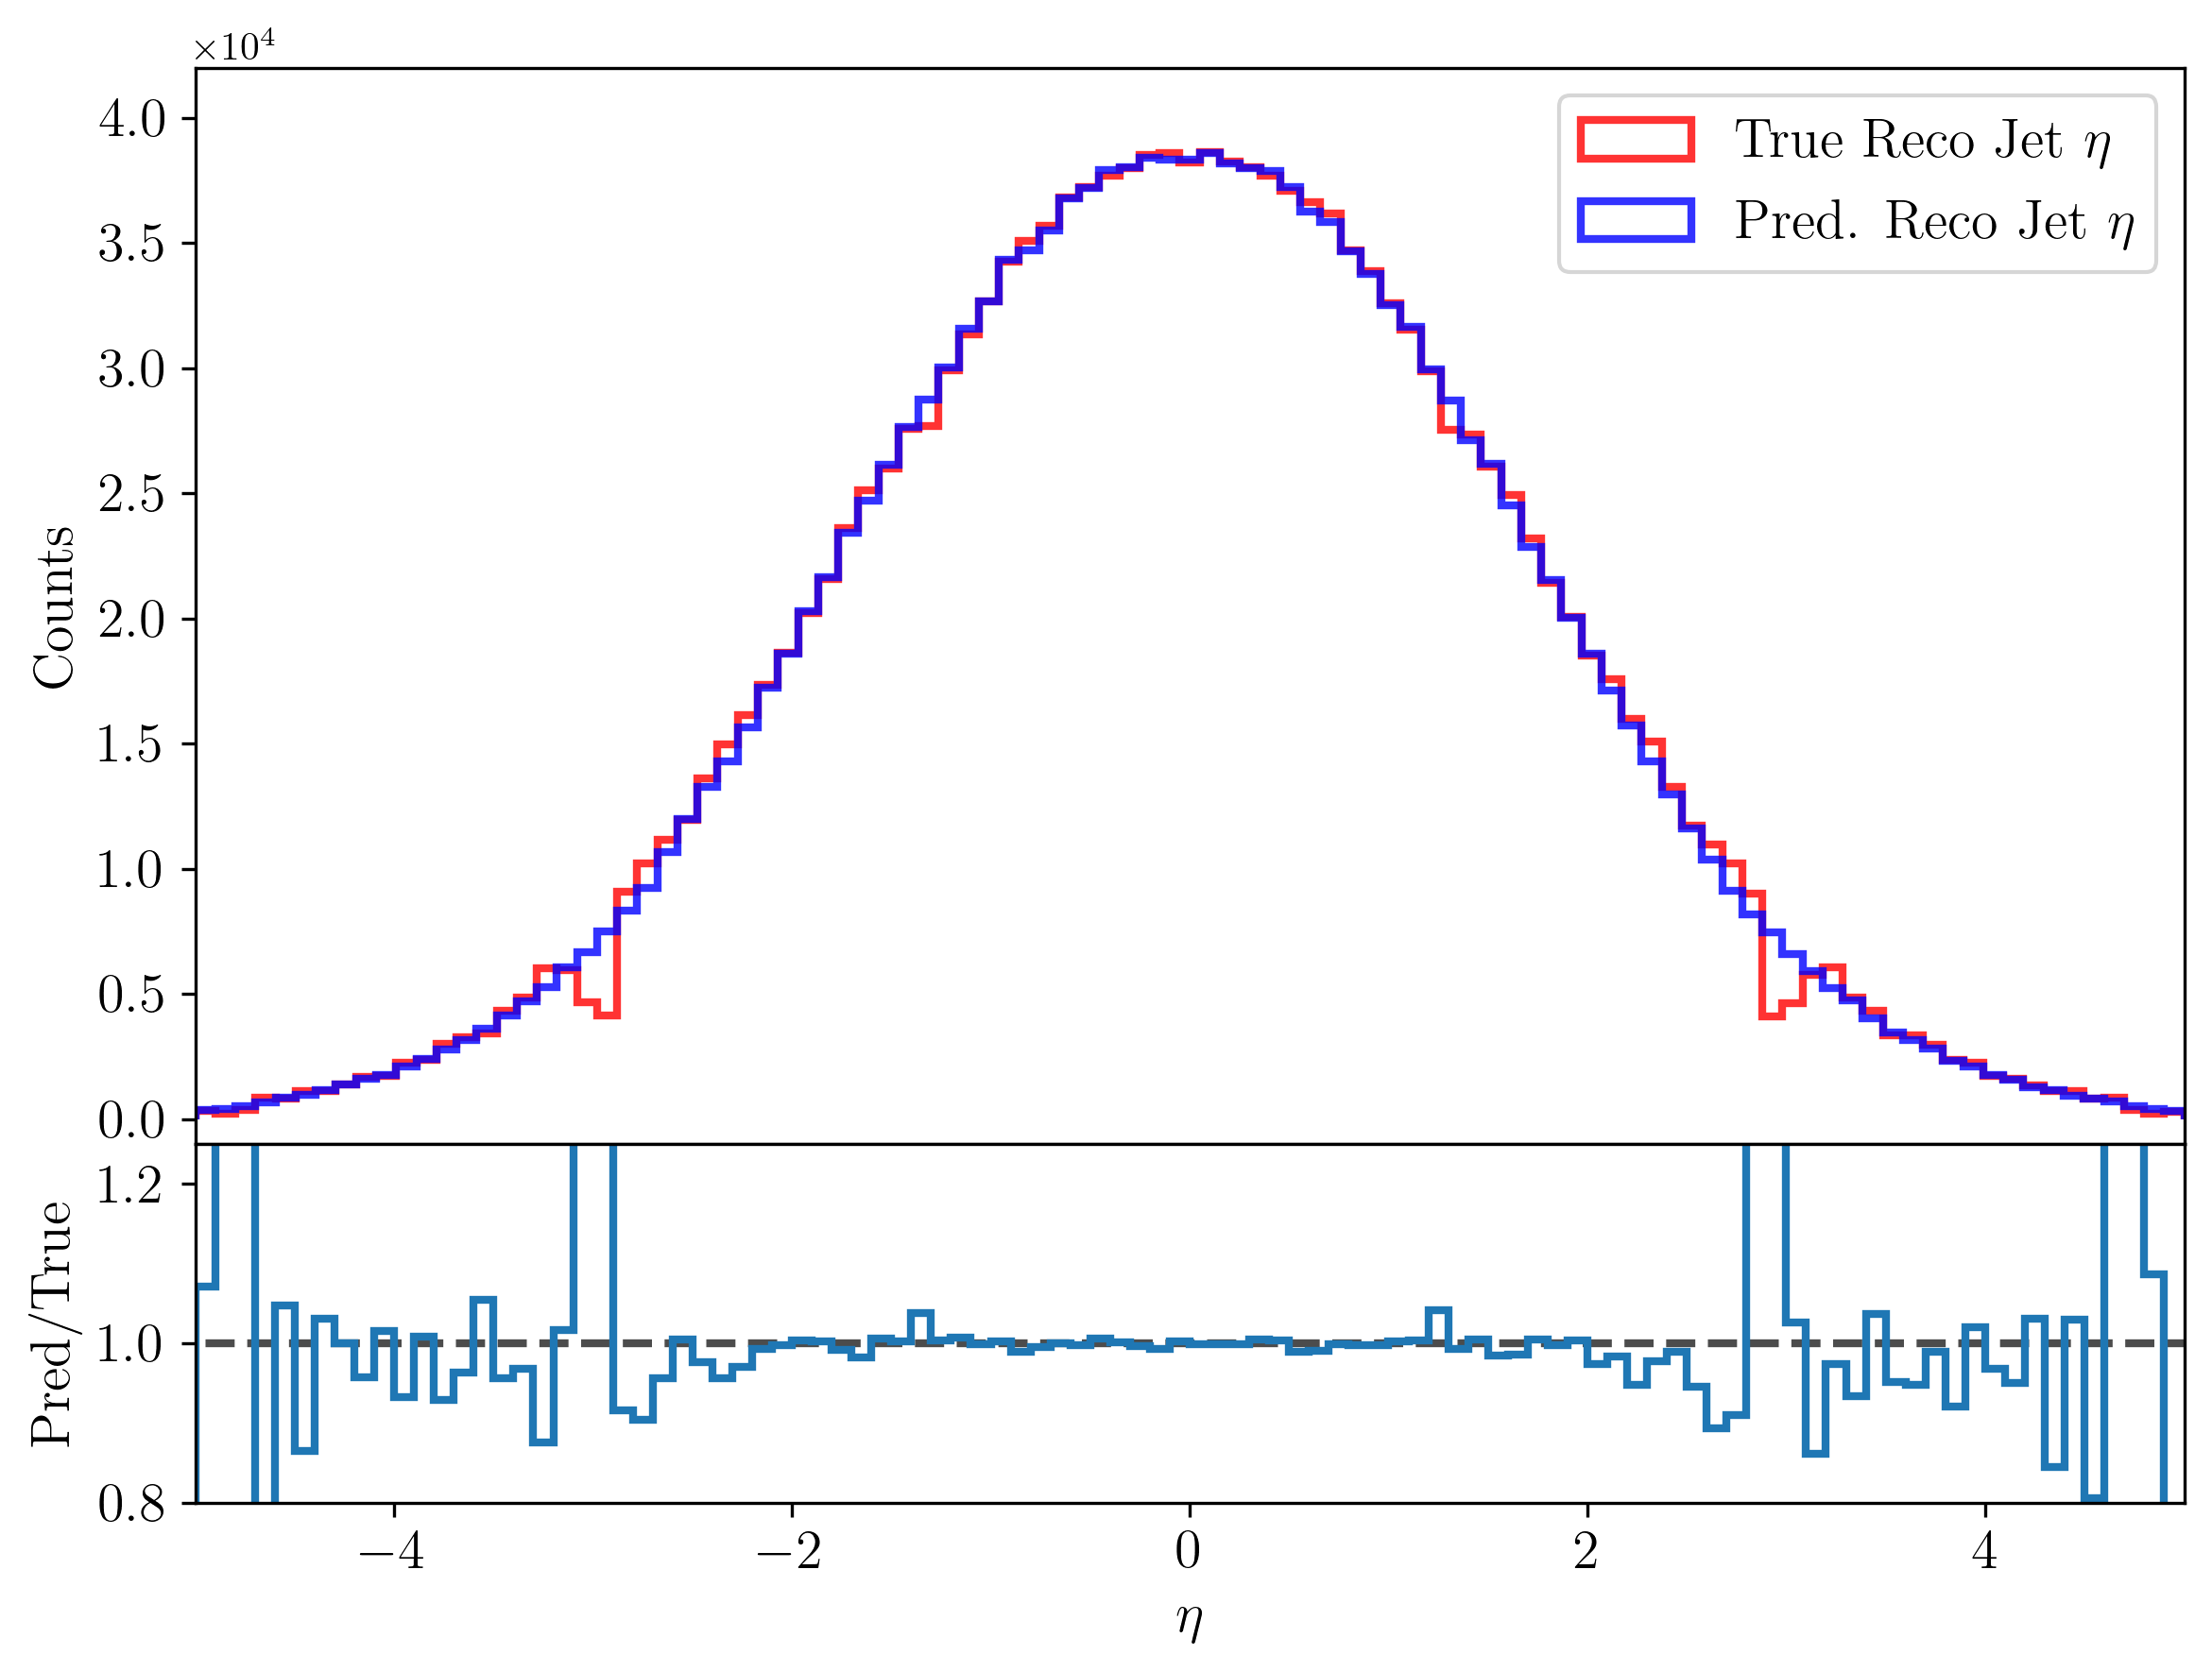

In [39]:
bins = np.linspace(-5, 5, 100)
true_hist, _ = np.histogram(data[:, 5], bins=bins)
pred_hist, _ = np.histogram(predict[:, 1], bins=bins)
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
fig, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1], 'hspace': 0}, figsize=(8,6), dpi=300, sharex=True)
ax0.hist(data[:, 5], label=r"True Reco Jet $\eta$", bins=bins, alpha=0.8, ec="r", histtype='step', lw=2)
ax0.set_ylim(-1000, 42000)
ax0.hist(predict[:, 1], label=r"Pred. Reco Jet $\eta$", bins=bins, alpha=0.8, ec="b", histtype='step', lw=2)
ax1.set_xlabel(r"$\eta$", size=14)
ax0.set_ylabel("Counts", size=14)
ax0.legend(prop={'size': 14})
ax0.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
#ax0.set_title(r"Predicted and True Reco Jet $\eta$ Distributions", size=20)
ax0.tick_params(axis='y', labelsize=14)
#ax.bar(bins[:-1], pred_hist/true_hist, width=(bins[1]-bins[0]), align='edge', color=None)
ax1.hist(bins[: 99], 99, weights=pred_hist/true_hist, histtype='step', lw=2)
ax1.set_ylim(0.8, 1.25)
ax1.set_ylabel(r'Pred/True', size=14)
ax1.hlines(1.0, xmin=-100, xmax=400, linestyle='dashed', color='black', lw=2, alpha=0.7)
ax1.set_xlim(-5, 5)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
#ax1.set_xticklabels(xlabels, fontsize=12)
fig.tight_layout()
plt.savefig("../data/plots/etaDistsFancy.pdf")
plt.show()

<ipython-input-40-4b5a214324b7>:17: RuntimeWarning: divide by zero encountered in true_divide
  ax1.hist(bins[: 99], 99, weights=pred_hist/true_hist, histtype='step', lw=2)
<ipython-input-40-4b5a214324b7>:17: RuntimeWarning: invalid value encountered in true_divide
  ax1.hist(bins[: 99], 99, weights=pred_hist/true_hist, histtype='step', lw=2)


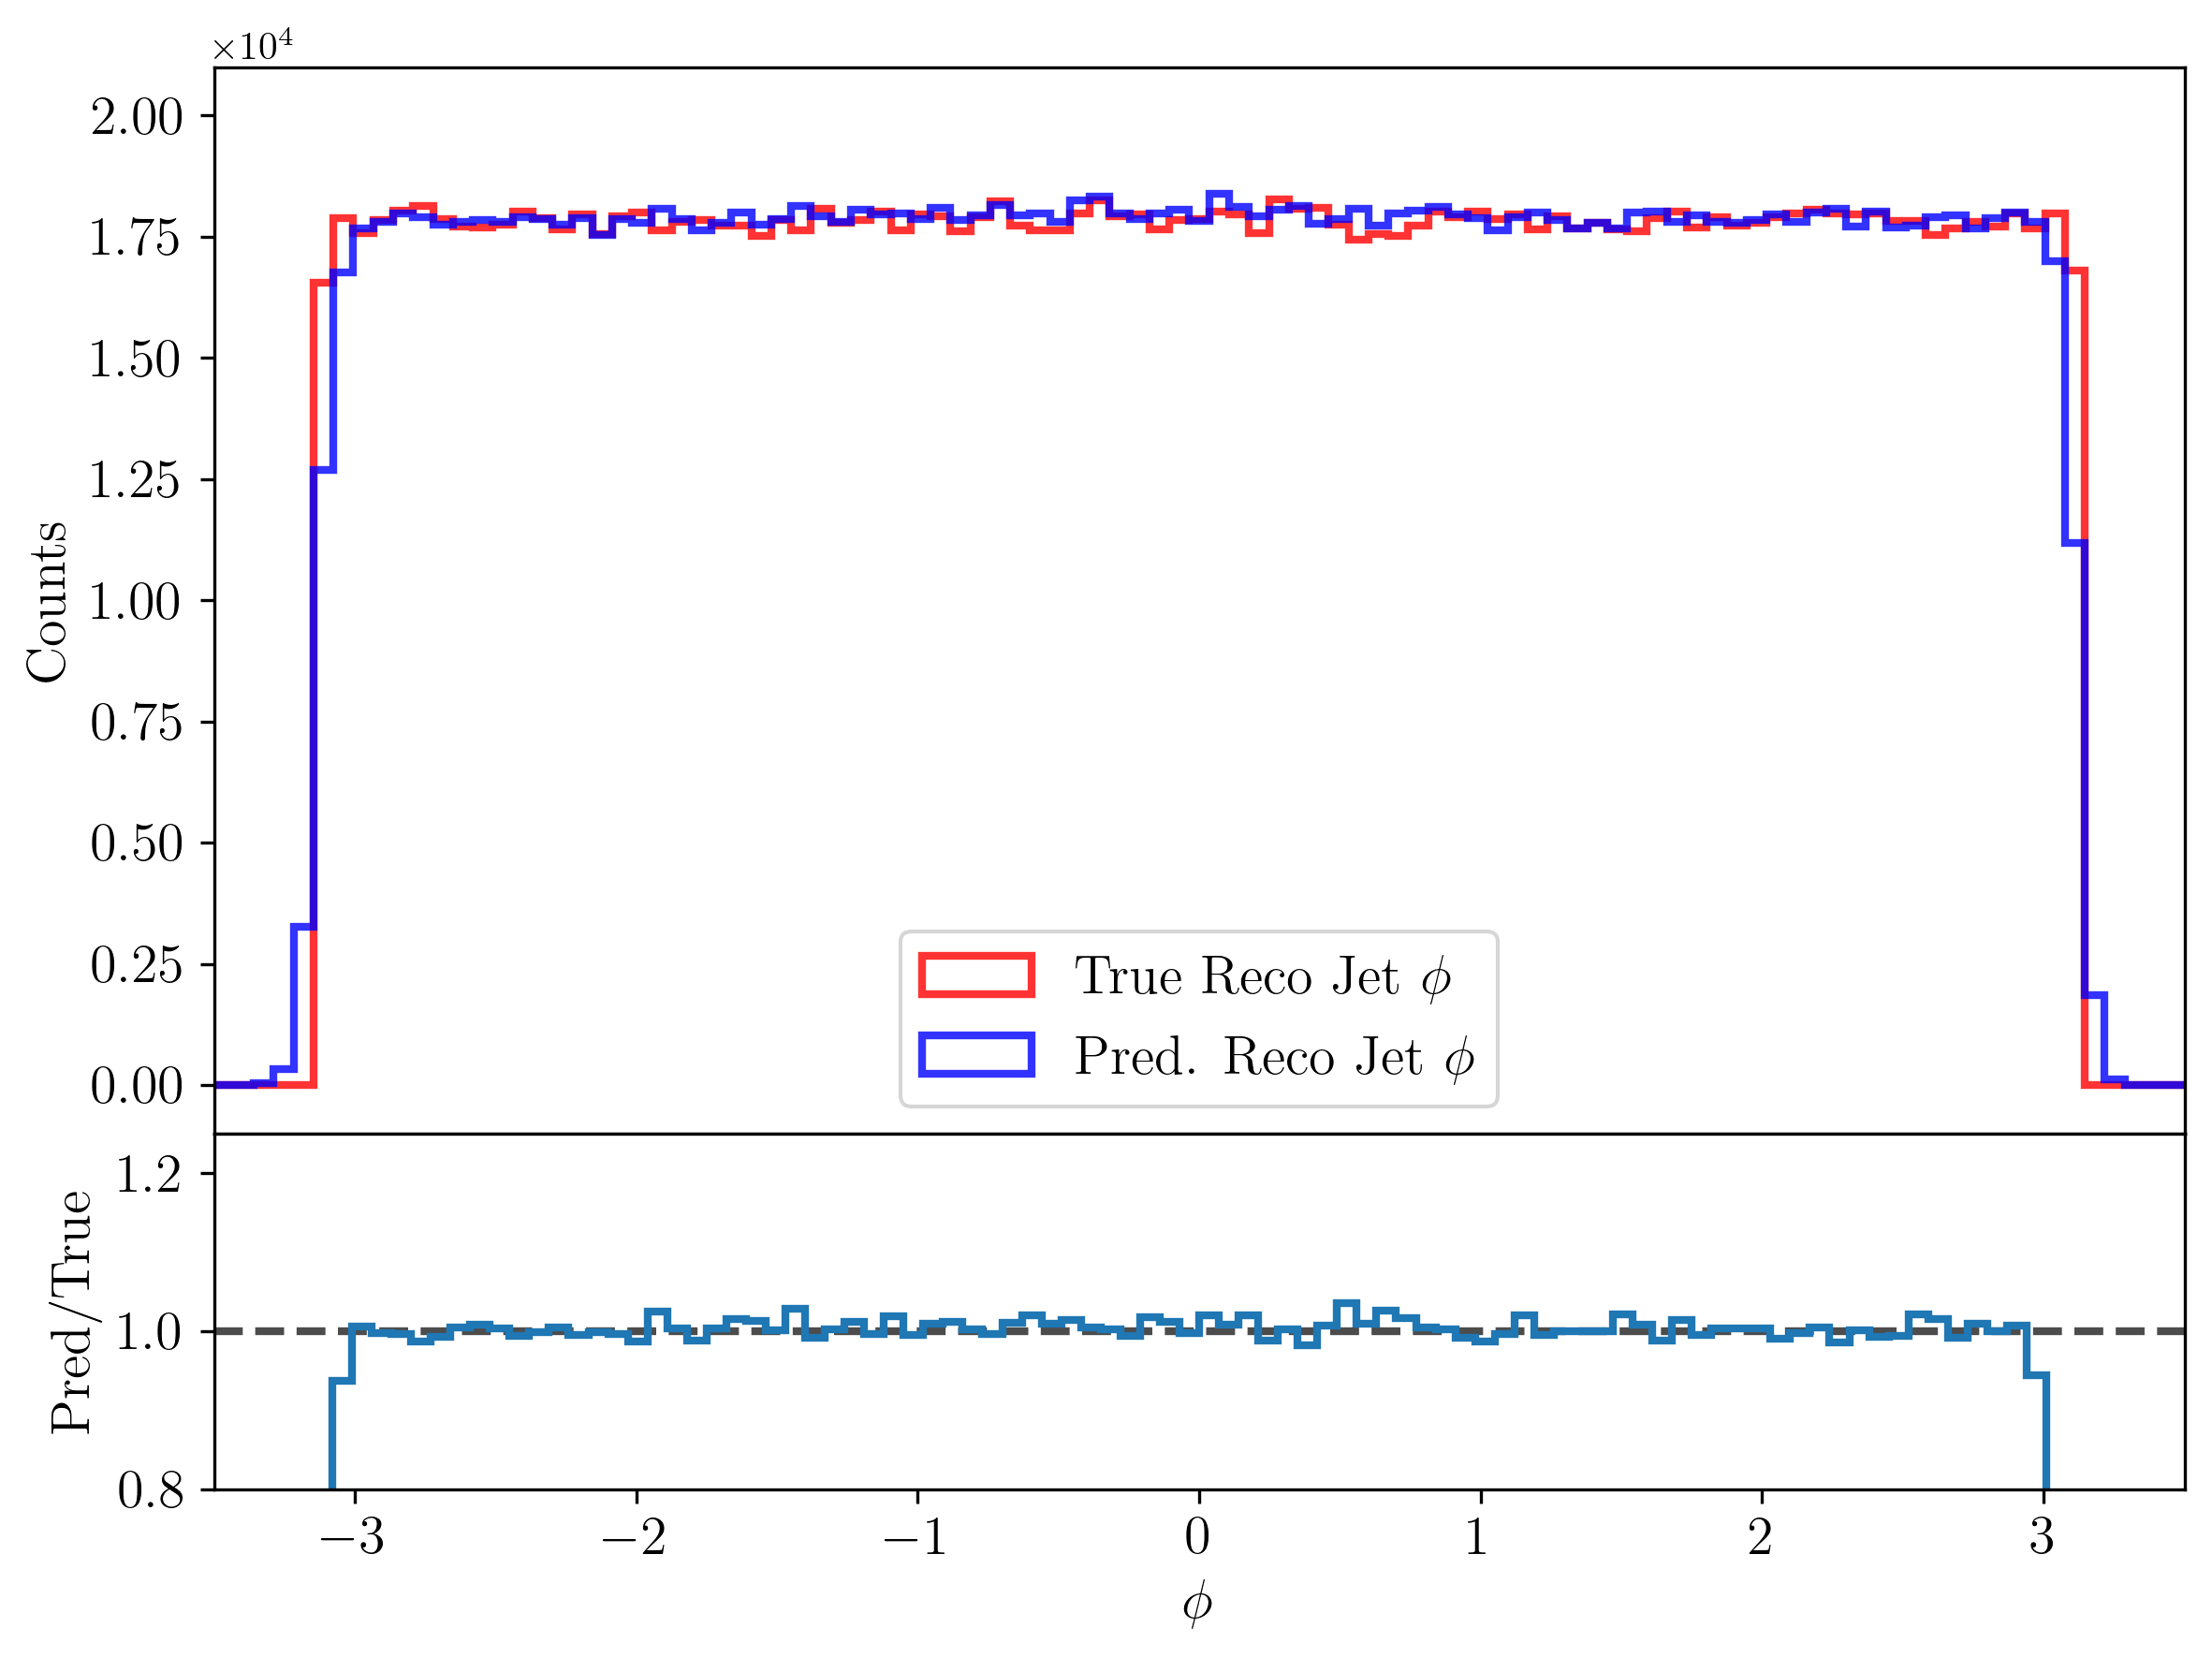

In [40]:
bins = np.linspace(-3.5, 3.5, 100)
true_hist, _ = np.histogram(data[:, 6], bins=bins)
pred_hist, _ = np.histogram(predict[:, 2], bins=bins)
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
fig, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1], 'hspace': 0}, figsize=(8,6), dpi=300, sharex=True)
ax0.hist(data[:, 6], label=r"True Reco Jet $\phi$", bins=bins, alpha=0.8, ec="r", histtype='step', lw=2)
ax0.set_ylim(-1000, 21000)
ax0.hist(predict[:, 2], label=r"Pred. Reco Jet $\phi$", bins=bins, alpha=0.8, ec="b", histtype='step', lw=2)
ax1.set_xlabel(r"$\phi$", size=14)
ax0.set_ylabel("Counts", size=14)
ax0.legend(loc='lower center', prop={'size': 14})
ax0.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
#ax0.set_title(r"Predicted and True Reco Jet $\phi$ Distributions", size=20)
ax0.tick_params(axis='y', labelsize=14)
#ax.bar(bins[:-1], pred_hist/true_hist, width=(bins[1]-bins[0]), align='edge', color=None)
ax1.hist(bins[: 99], 99, weights=pred_hist/true_hist, histtype='step', lw=2)
ax1.set_ylim(0.8, 1.25)
ax1.set_ylabel(r'Pred/True', size=14)
ax1.hlines(1.0, xmin=-100, xmax=400, linestyle='dashed', color='black', lw=2, alpha=0.7)
ax1.set_xlim(-3.5, 3.5)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
#ax1.set_xticklabels(xlabels, fontsize=12)
fig.tight_layout()
plt.savefig("../data/plots/phiDistsFancy.png")
#plt.show()

<ipython-input-41-3bcdaf60efc4>:17: RuntimeWarning: invalid value encountered in true_divide
  ax1.hist(bins[: 99], 99, weights=pred_hist/true_hist, histtype='step', lw=2)


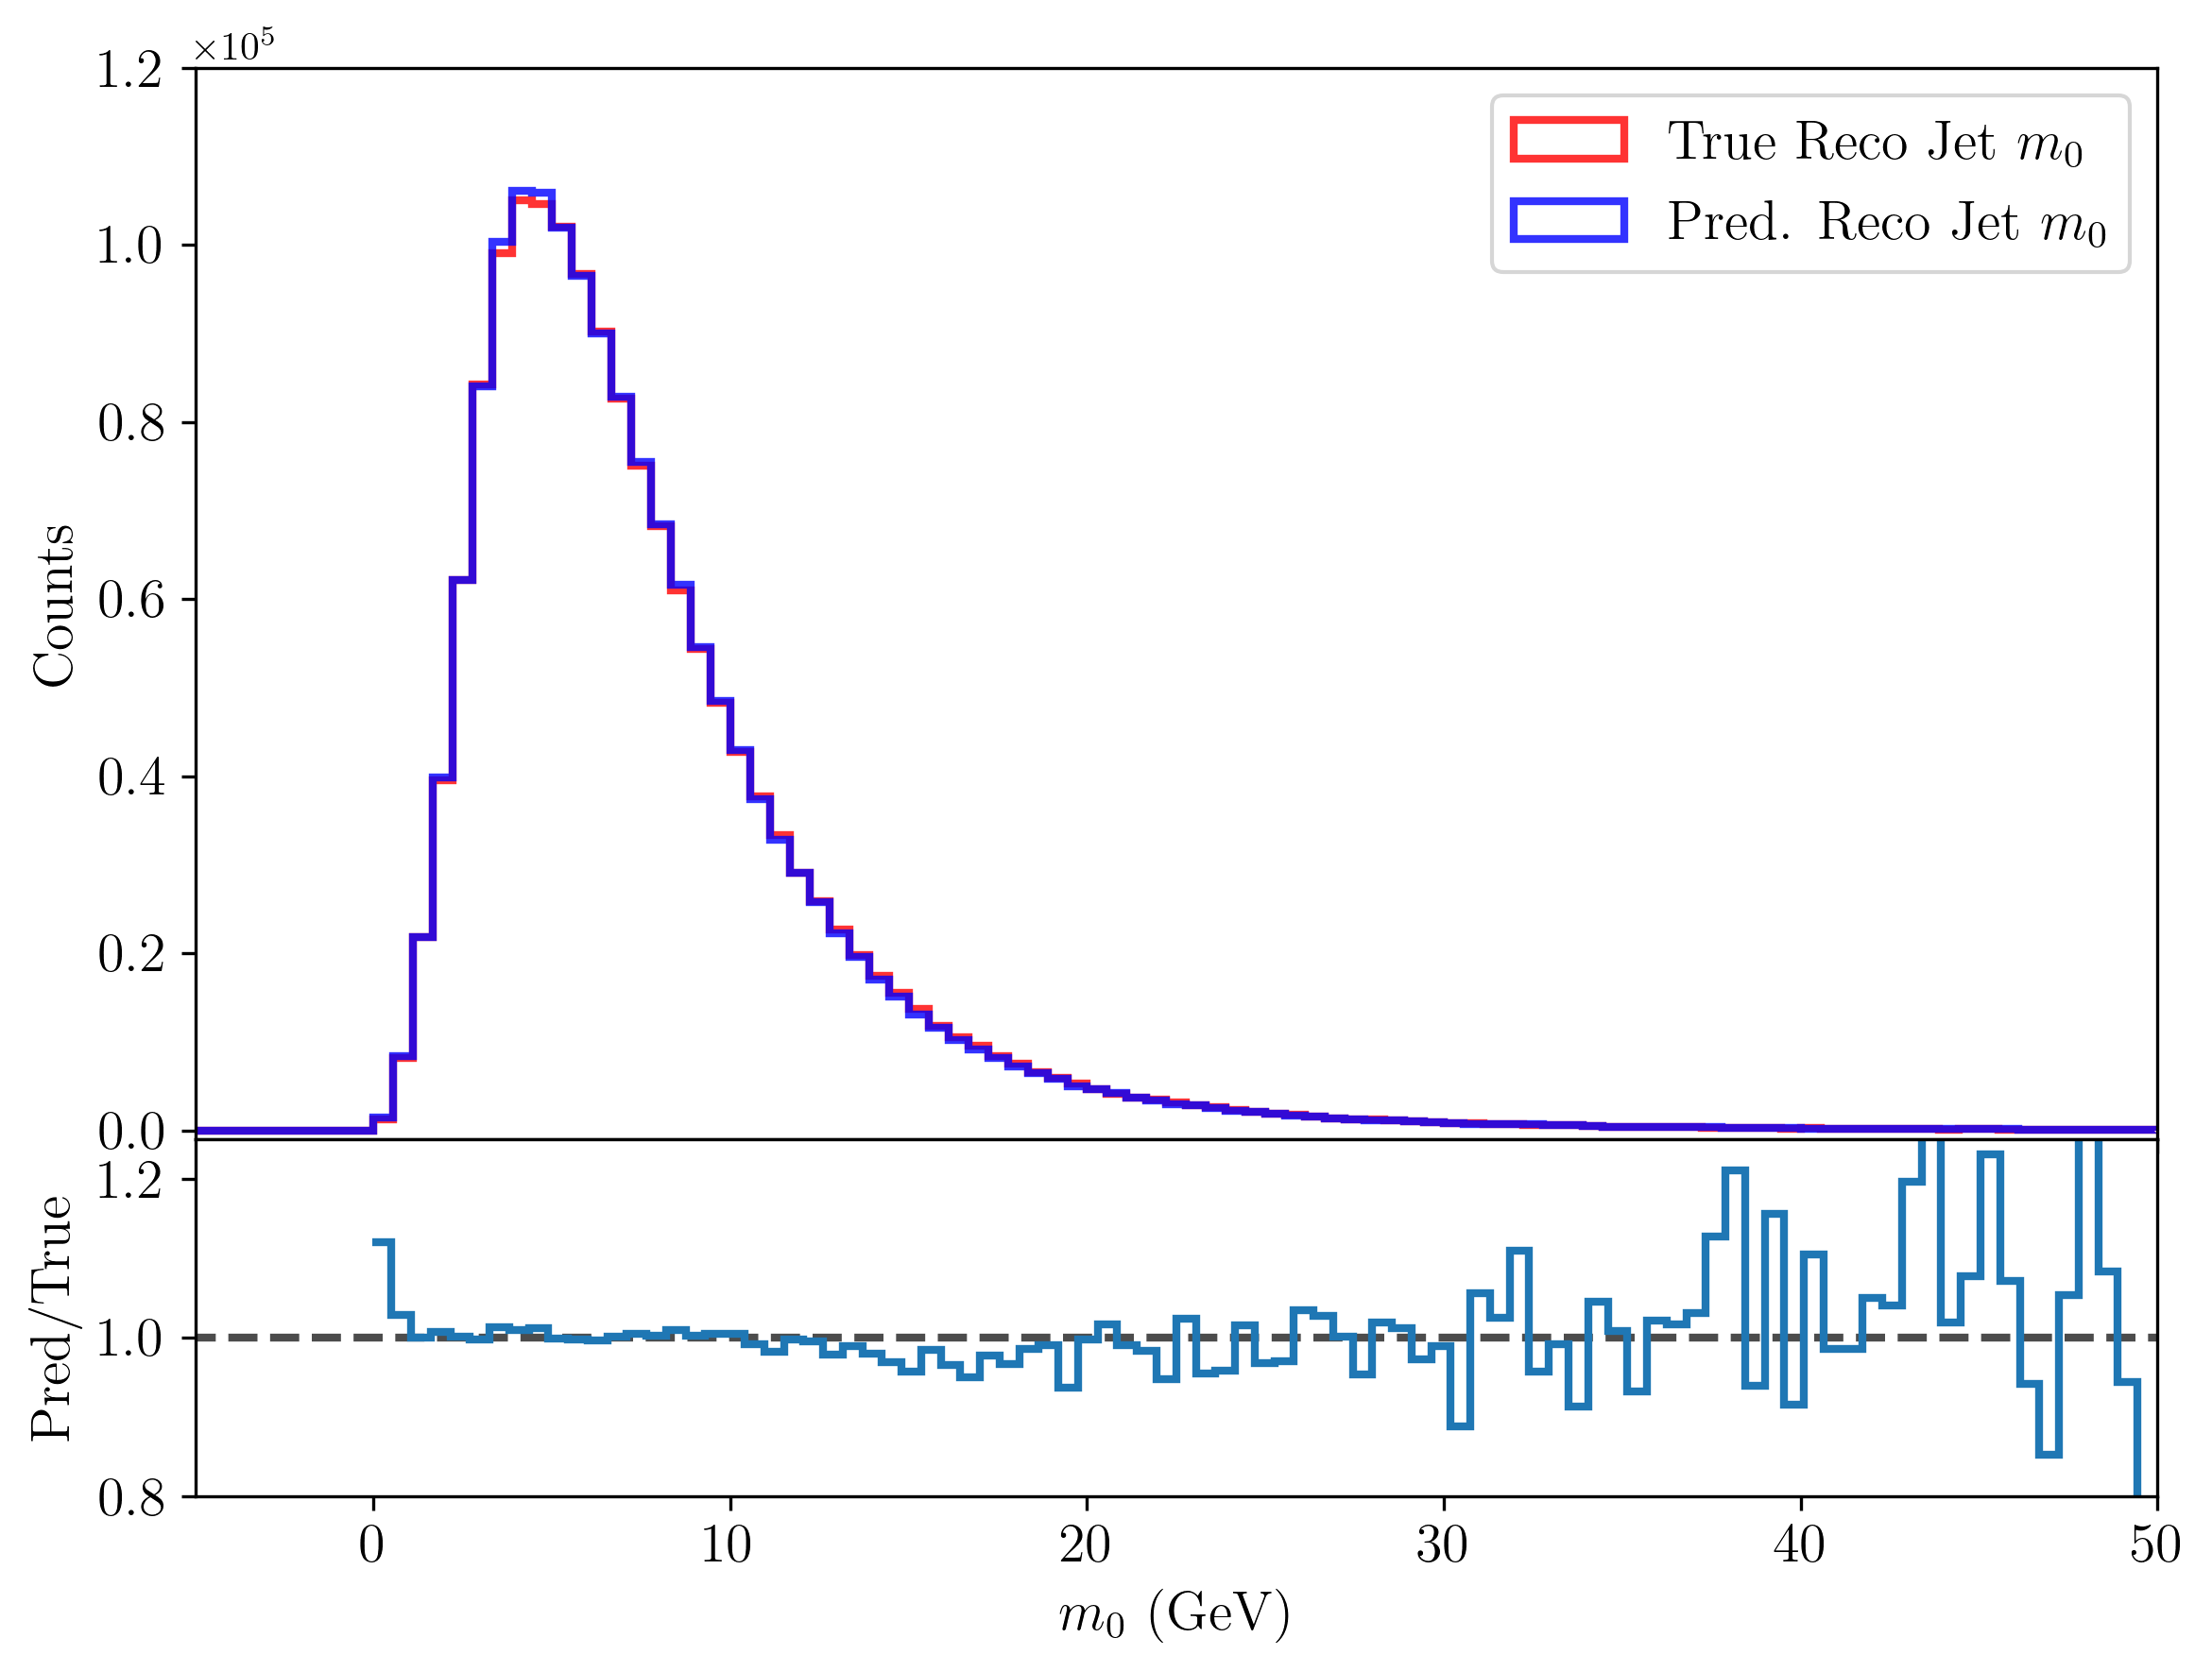

In [41]:
bins = np.linspace(-5, 50, 100)
true_hist, _ = np.histogram(data[:, 7], bins=bins)
pred_hist, _ = np.histogram(predict[:, 3], bins=bins)
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
fig, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1], 'hspace': 0}, figsize=(8,6), dpi=300, sharex=True)
ax0.hist(data[:, 7], label=r"True Reco Jet $m_0$", bins=bins, alpha=0.8, ec="r", histtype='step', lw=2)
ax0.set_ylim(-1000, 120000)
ax0.hist(predict[:, 3], label=r"Pred. Reco Jet $m_0$", bins=bins, alpha=0.8, ec="b", histtype='step', lw=2)
ax1.set_xlabel(r"$m_0$ (GeV)", size=14)
ax0.set_ylabel("Counts", size=14)
ax0.legend(prop={'size': 14})
ax0.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
#ax0.set_title(r"Predicted and True Reco Jet $m_0$ Distributions", size=20)
ax0.tick_params(axis='y', labelsize=14)
#ax.bar(bins[:-1], pred_hist/true_hist, width=(bins[1]-bins[0]), align='edge', color=None)
ax1.hist(bins[: 99], 99, weights=pred_hist/true_hist, histtype='step', lw=2)
ax1.set_ylim(0.8, 1.25)
ax1.set_ylabel(r'Pred/True', size=14)
ax1.hlines(1.0, xmin=-100, xmax=400, linestyle='dashed', color='black', lw=2, alpha=0.7)
ax1.set_xlim(-5, 50)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
#ax1.set_xticklabels(xlabels, fontsize=12)
fig.tight_layout()
plt.savefig("../data/plots/massDistsFancy.pdf")
#plt.show()

<ipython-input-18-22f8f58683cf>:17: RuntimeWarning: invalid value encountered in true_divide
  ax1.hist(bins[: 99], 99, weights=pred_hist/true_hist, histtype='step', lw=2)


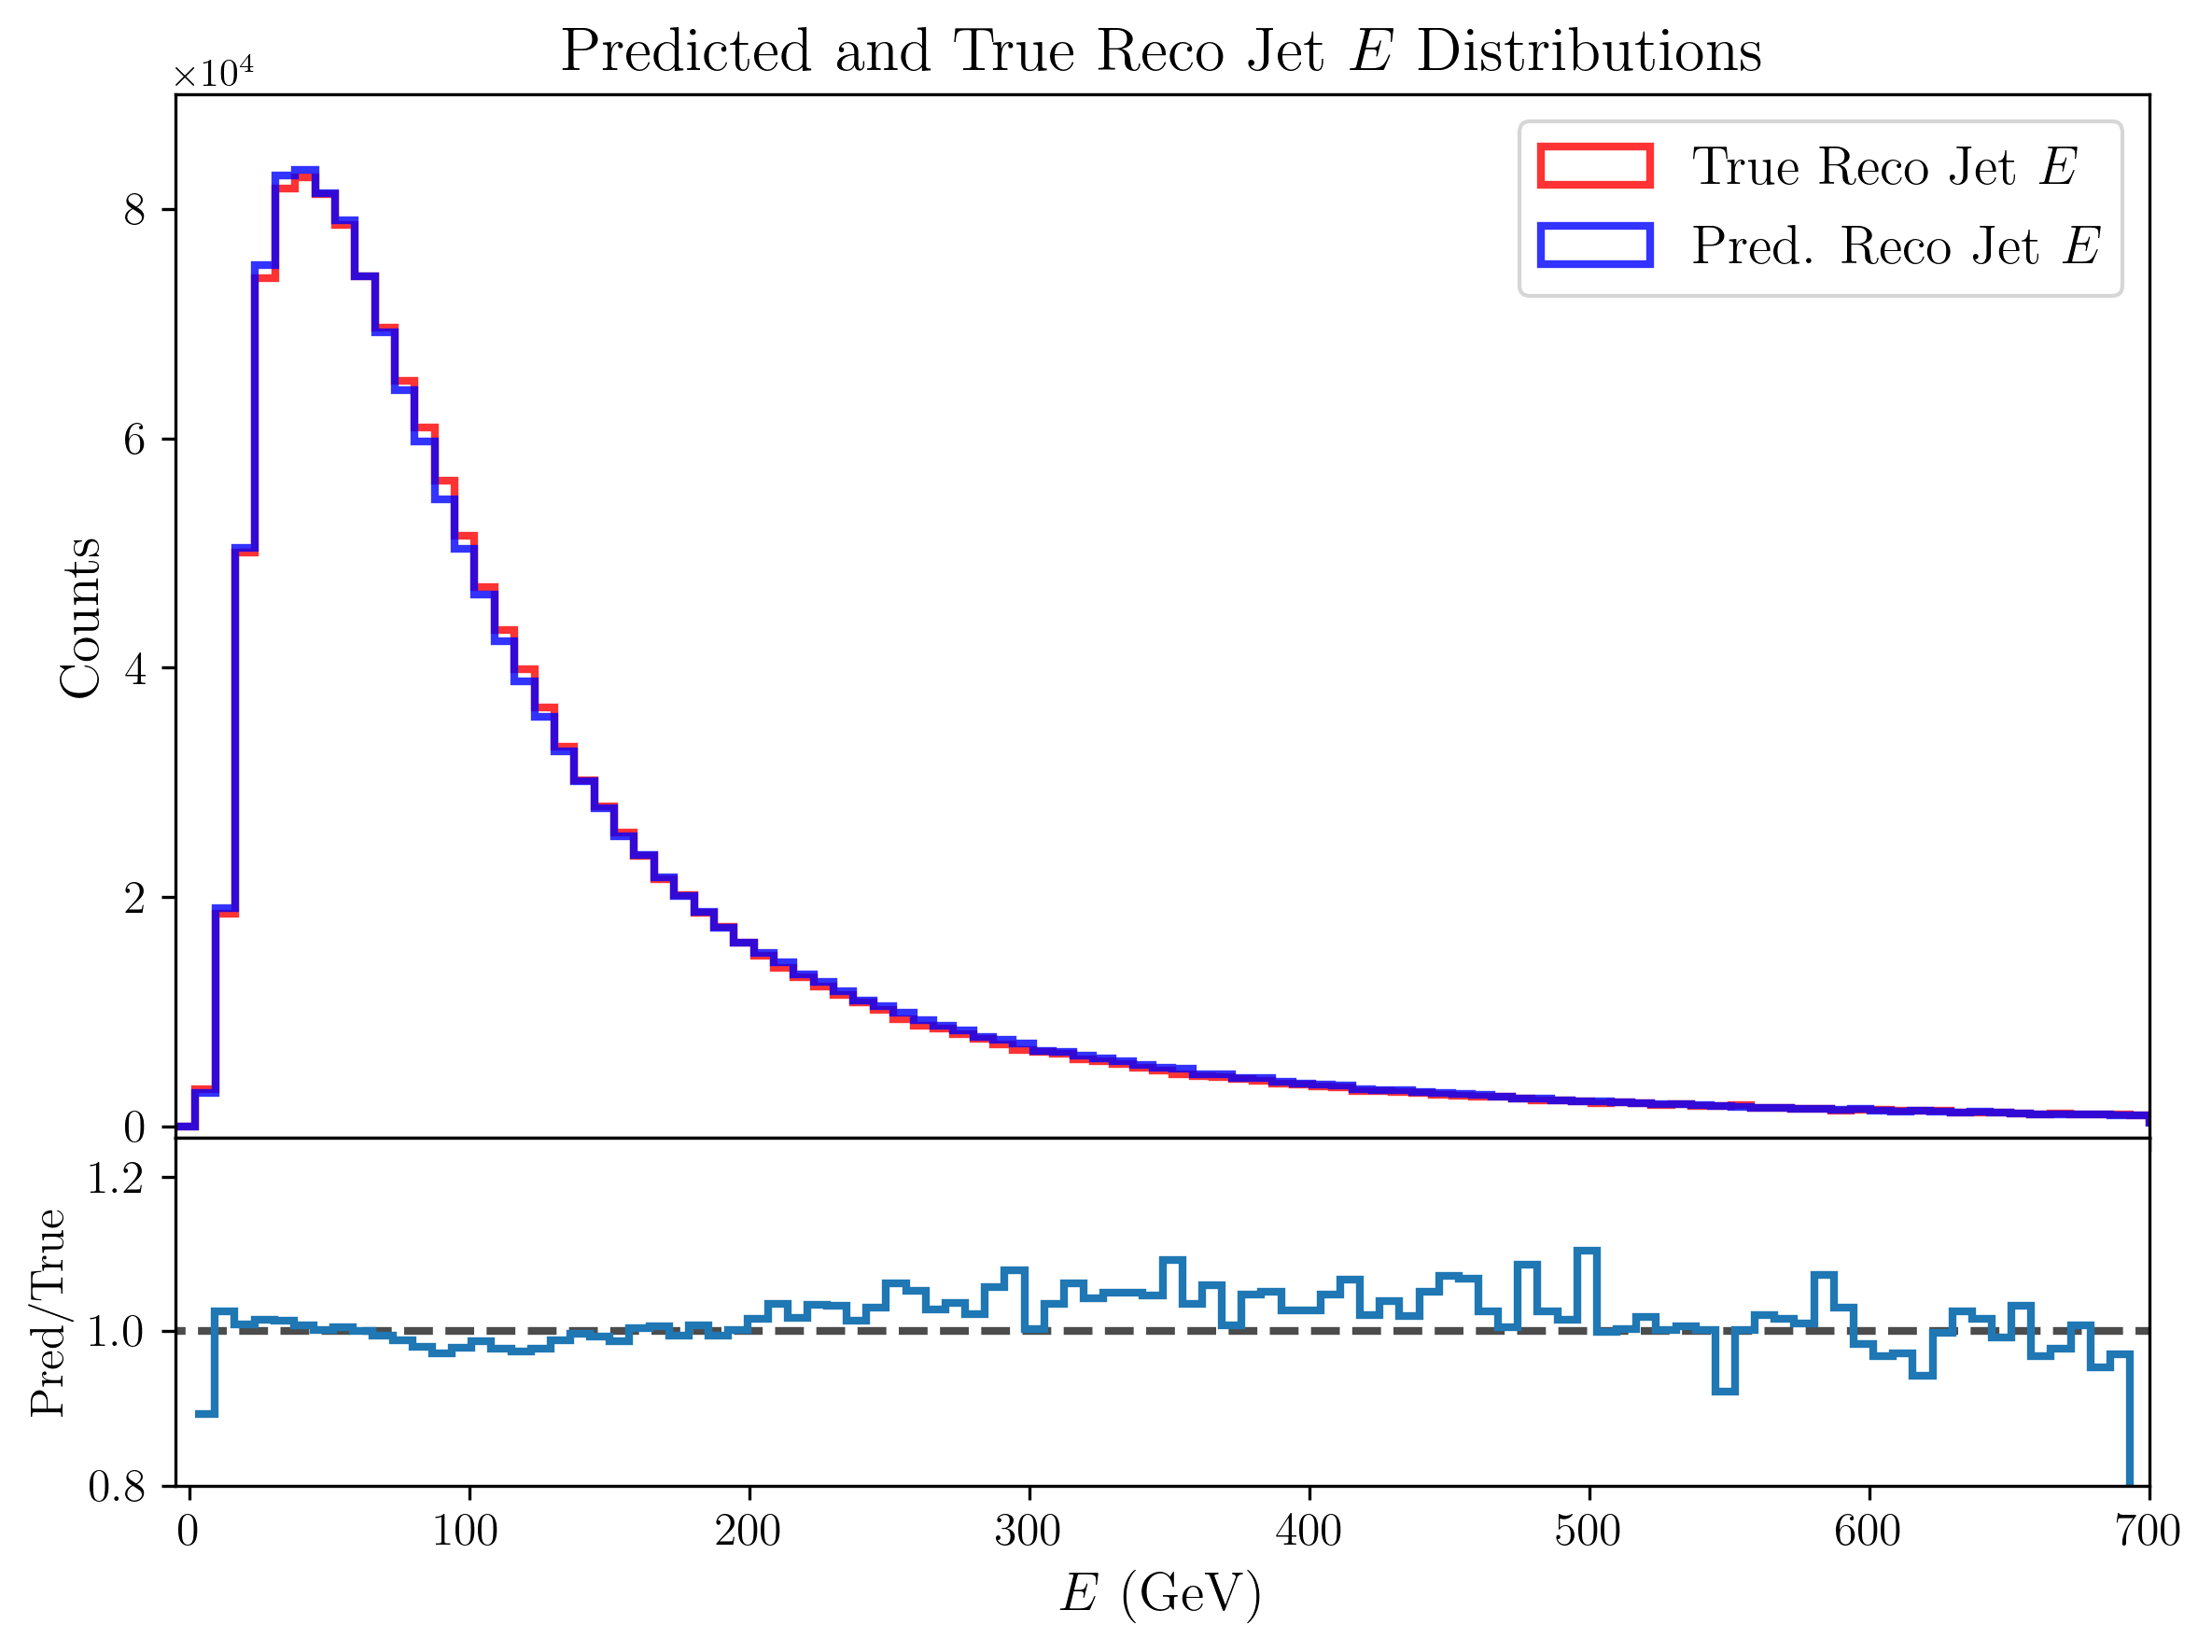

In [18]:
bins = np.linspace(-5, 700, 100)
true_hist, _ = np.histogram(np.sqrt(data[:, 7]**2 + (data[:, 4]*np.cosh(data[:, 5]))**2), bins=bins)
pred_hist, _ = np.histogram(np.sqrt(predict[:, 3]**2 + (predict[:, 0]*np.cosh(predict[:, 1]))**2), bins=bins)
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
fig, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1], 'hspace': 0}, figsize=(8,6), dpi=300, sharex=True)
ax0.hist(np.sqrt(data[:, 7]**2 + (data[:, 4]*np.cosh(data[:, 5]))**2), label=r"True Reco Jet $E$", bins=bins, alpha=0.8, ec="r", histtype='step', lw=2)
ax0.set_ylim(-1000, 90000)
ax0.hist(np.sqrt(predict[:, 3]**2 + (predict[:, 0]*np.cosh(predict[:, 1]))**2), label=r"Pred. Reco Jet $E$", bins=bins, alpha=0.8, ec="b", histtype='step', lw=2)
ax1.set_xlabel(r"$E$ (GeV)", size=14)
ax0.set_ylabel("Counts", size=14)
ax0.legend(prop={'size': 14})
ax0.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax0.set_title(r"Predicted and True Reco Jet $E$ Distributions", size=16)
ax0.tick_params(axis='y', labelsize=12)
#ax.bar(bins[:-1], pred_hist/true_hist, width=(bins[1]-bins[0]), align='edge', color=None)
ax1.hist(bins[: 99], 99, weights=pred_hist/true_hist, histtype='step', lw=2)
ax1.set_ylim(0.8, 1.25)
ax1.set_ylabel(r'Pred/True', size=12)
ax1.hlines(1.0, xmin=-100, xmax=800, linestyle='dashed', color='black', lw=2, alpha=0.7)
ax1.set_xlim(-5, 700)
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)
#ax1.set_xticklabels(xlabels, fontsize=12)
fig.tight_layout()
#plt.savefig("../data/plots/EDists.png")
plt.show()

<ipython-input-19-15300bc36378>:17: RuntimeWarning: invalid value encountered in true_divide
  ax1.hist(bins[: 99], 99, weights=pred_hist/true_hist, histtype='step', lw=2)


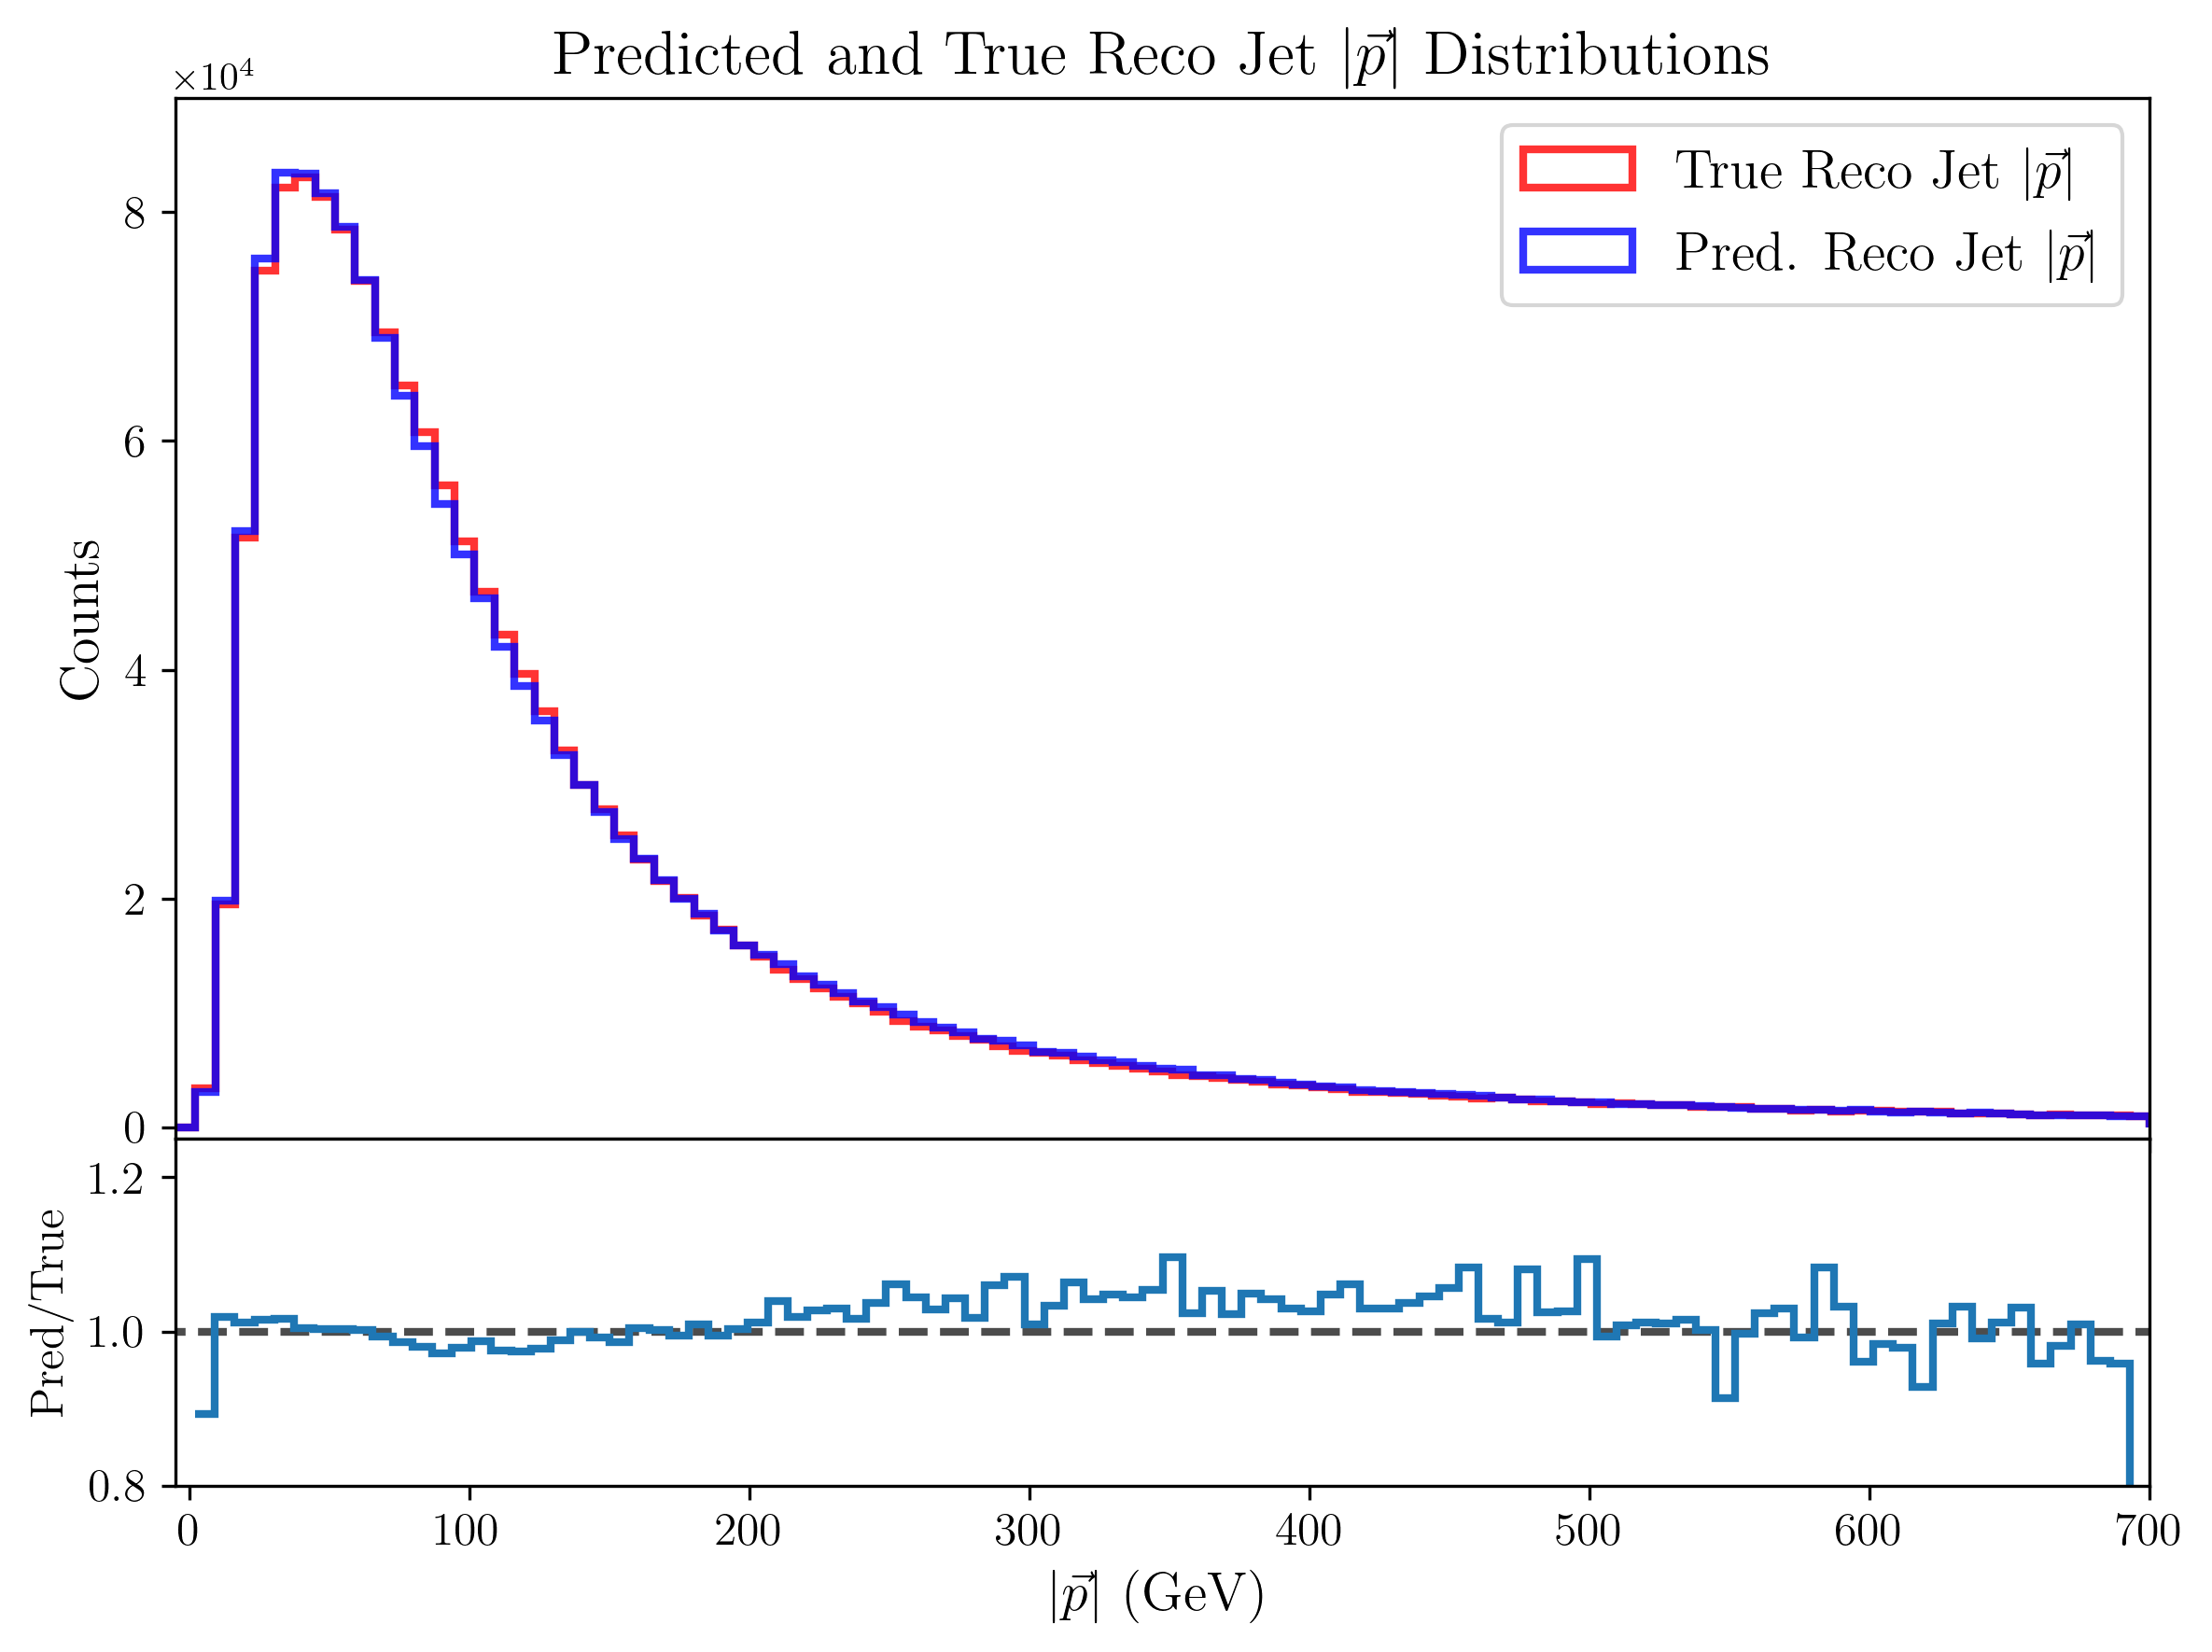

In [19]:
bins = np.linspace(-5, 700, 100)
true_hist, _ = np.histogram(data[:, 4]*np.cosh(data[:, 5]), bins=bins)
pred_hist, _ = np.histogram(predict[:, 0]*np.cosh(predict[:, 1]), bins=bins)
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
fig, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1], 'hspace': 0}, figsize=(8,6), dpi=300, sharex=True)
ax0.hist((data[:, 4]*np.cosh(data[:, 5])), label=r"True Reco Jet $|\vec{p}|$", bins=bins, alpha=0.8, ec="r", histtype='step', lw=2)
ax0.set_ylim(-1000, 90000)
ax0.hist(predict[:, 0]*np.cosh(predict[:, 1]), label=r"Pred. Reco Jet $|\vec{p}|$", bins=bins, alpha=0.8, ec="b", histtype='step', lw=2)
ax1.set_xlabel(r"$|\vec{p}|$ (GeV)", size=14)
ax0.set_ylabel("Counts", size=14)
ax0.legend(prop={'size': 14})
ax0.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax0.set_title(r"Predicted and True Reco Jet $|\vec{p}|$ Distributions", size=16)
ax0.tick_params(axis='y', labelsize=12)
#ax.bar(bins[:-1], pred_hist/true_hist, width=(bins[1]-bins[0]), align='edge', color=None)
ax1.hist(bins[: 99], 99, weights=pred_hist/true_hist, histtype='step', lw=2)
ax1.set_ylim(0.8, 1.25)
ax1.set_ylabel(r'Pred/True', size=12)
ax1.hlines(1.0, xmin=-100, xmax=800, linestyle='dashed', color='black', lw=2, alpha=0.7)
ax1.set_xlim(-5, 700)
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)
#ax1.set_xticklabels(xlabels, fontsize=12)
fig.tight_layout()
#plt.savefig("../data/plots/PDists.png")
plt.show()

<ipython-input-20-f1abdcfe6cb5>:31: RuntimeWarning: divide by zero encountered in true_divide
  ax1.hist(bins[: 99], 99, weights=pred_hist/true_hist, histtype='step', lw=2)
<ipython-input-20-f1abdcfe6cb5>:31: RuntimeWarning: invalid value encountered in true_divide
  ax1.hist(bins[: 99], 99, weights=pred_hist/true_hist, histtype='step', lw=2)
<ipython-input-20-f1abdcfe6cb5>:31: RuntimeWarning: invalid value encountered in true_divide
  ax1.hist(bins[: 99], 99, weights=pred_hist/true_hist, histtype='step', lw=2)
<ipython-input-20-f1abdcfe6cb5>:31: RuntimeWarning: divide by zero encountered in true_divide
  ax1.hist(bins[: 99], 99, weights=pred_hist/true_hist, histtype='step', lw=2)
<ipython-input-20-f1abdcfe6cb5>:31: RuntimeWarning: invalid value encountered in true_divide
  ax1.hist(bins[: 99], 99, weights=pred_hist/true_hist, histtype='step', lw=2)
<ipython-input-20-f1abdcfe6cb5>:31: RuntimeWarning: divide by zero encountered in true_divide
  ax1.hist(bins[: 99], 99, weights=pred_hist

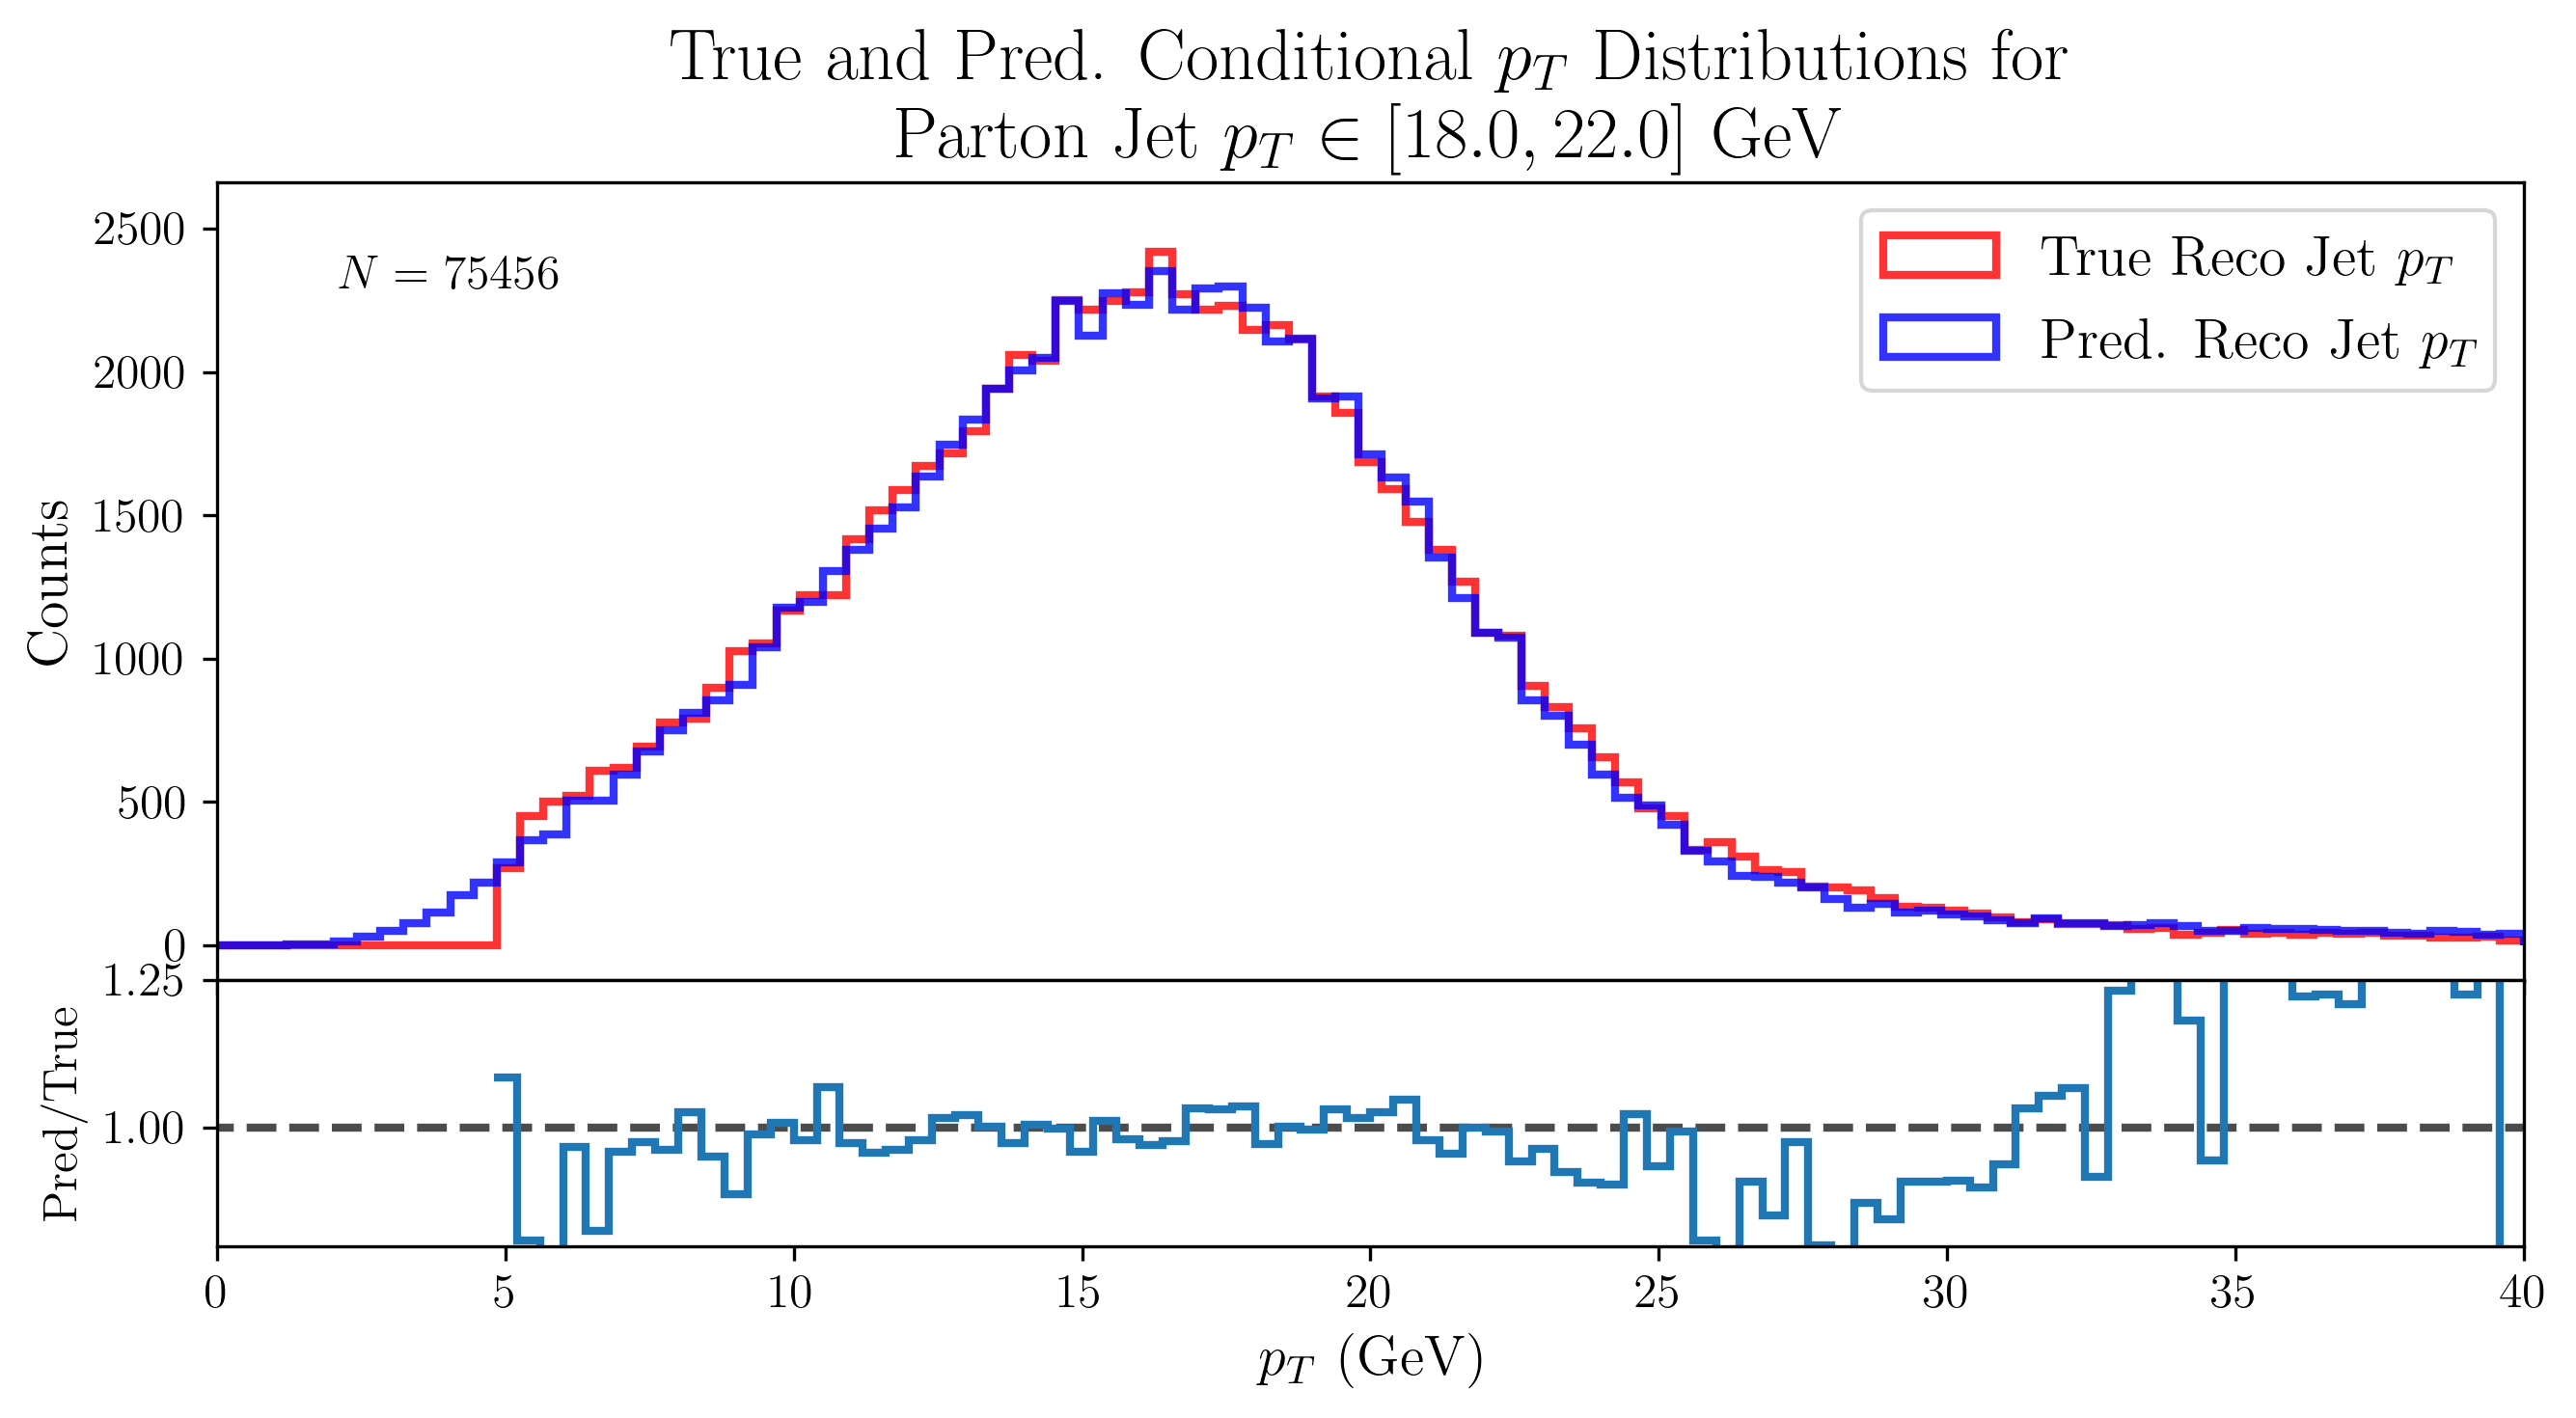

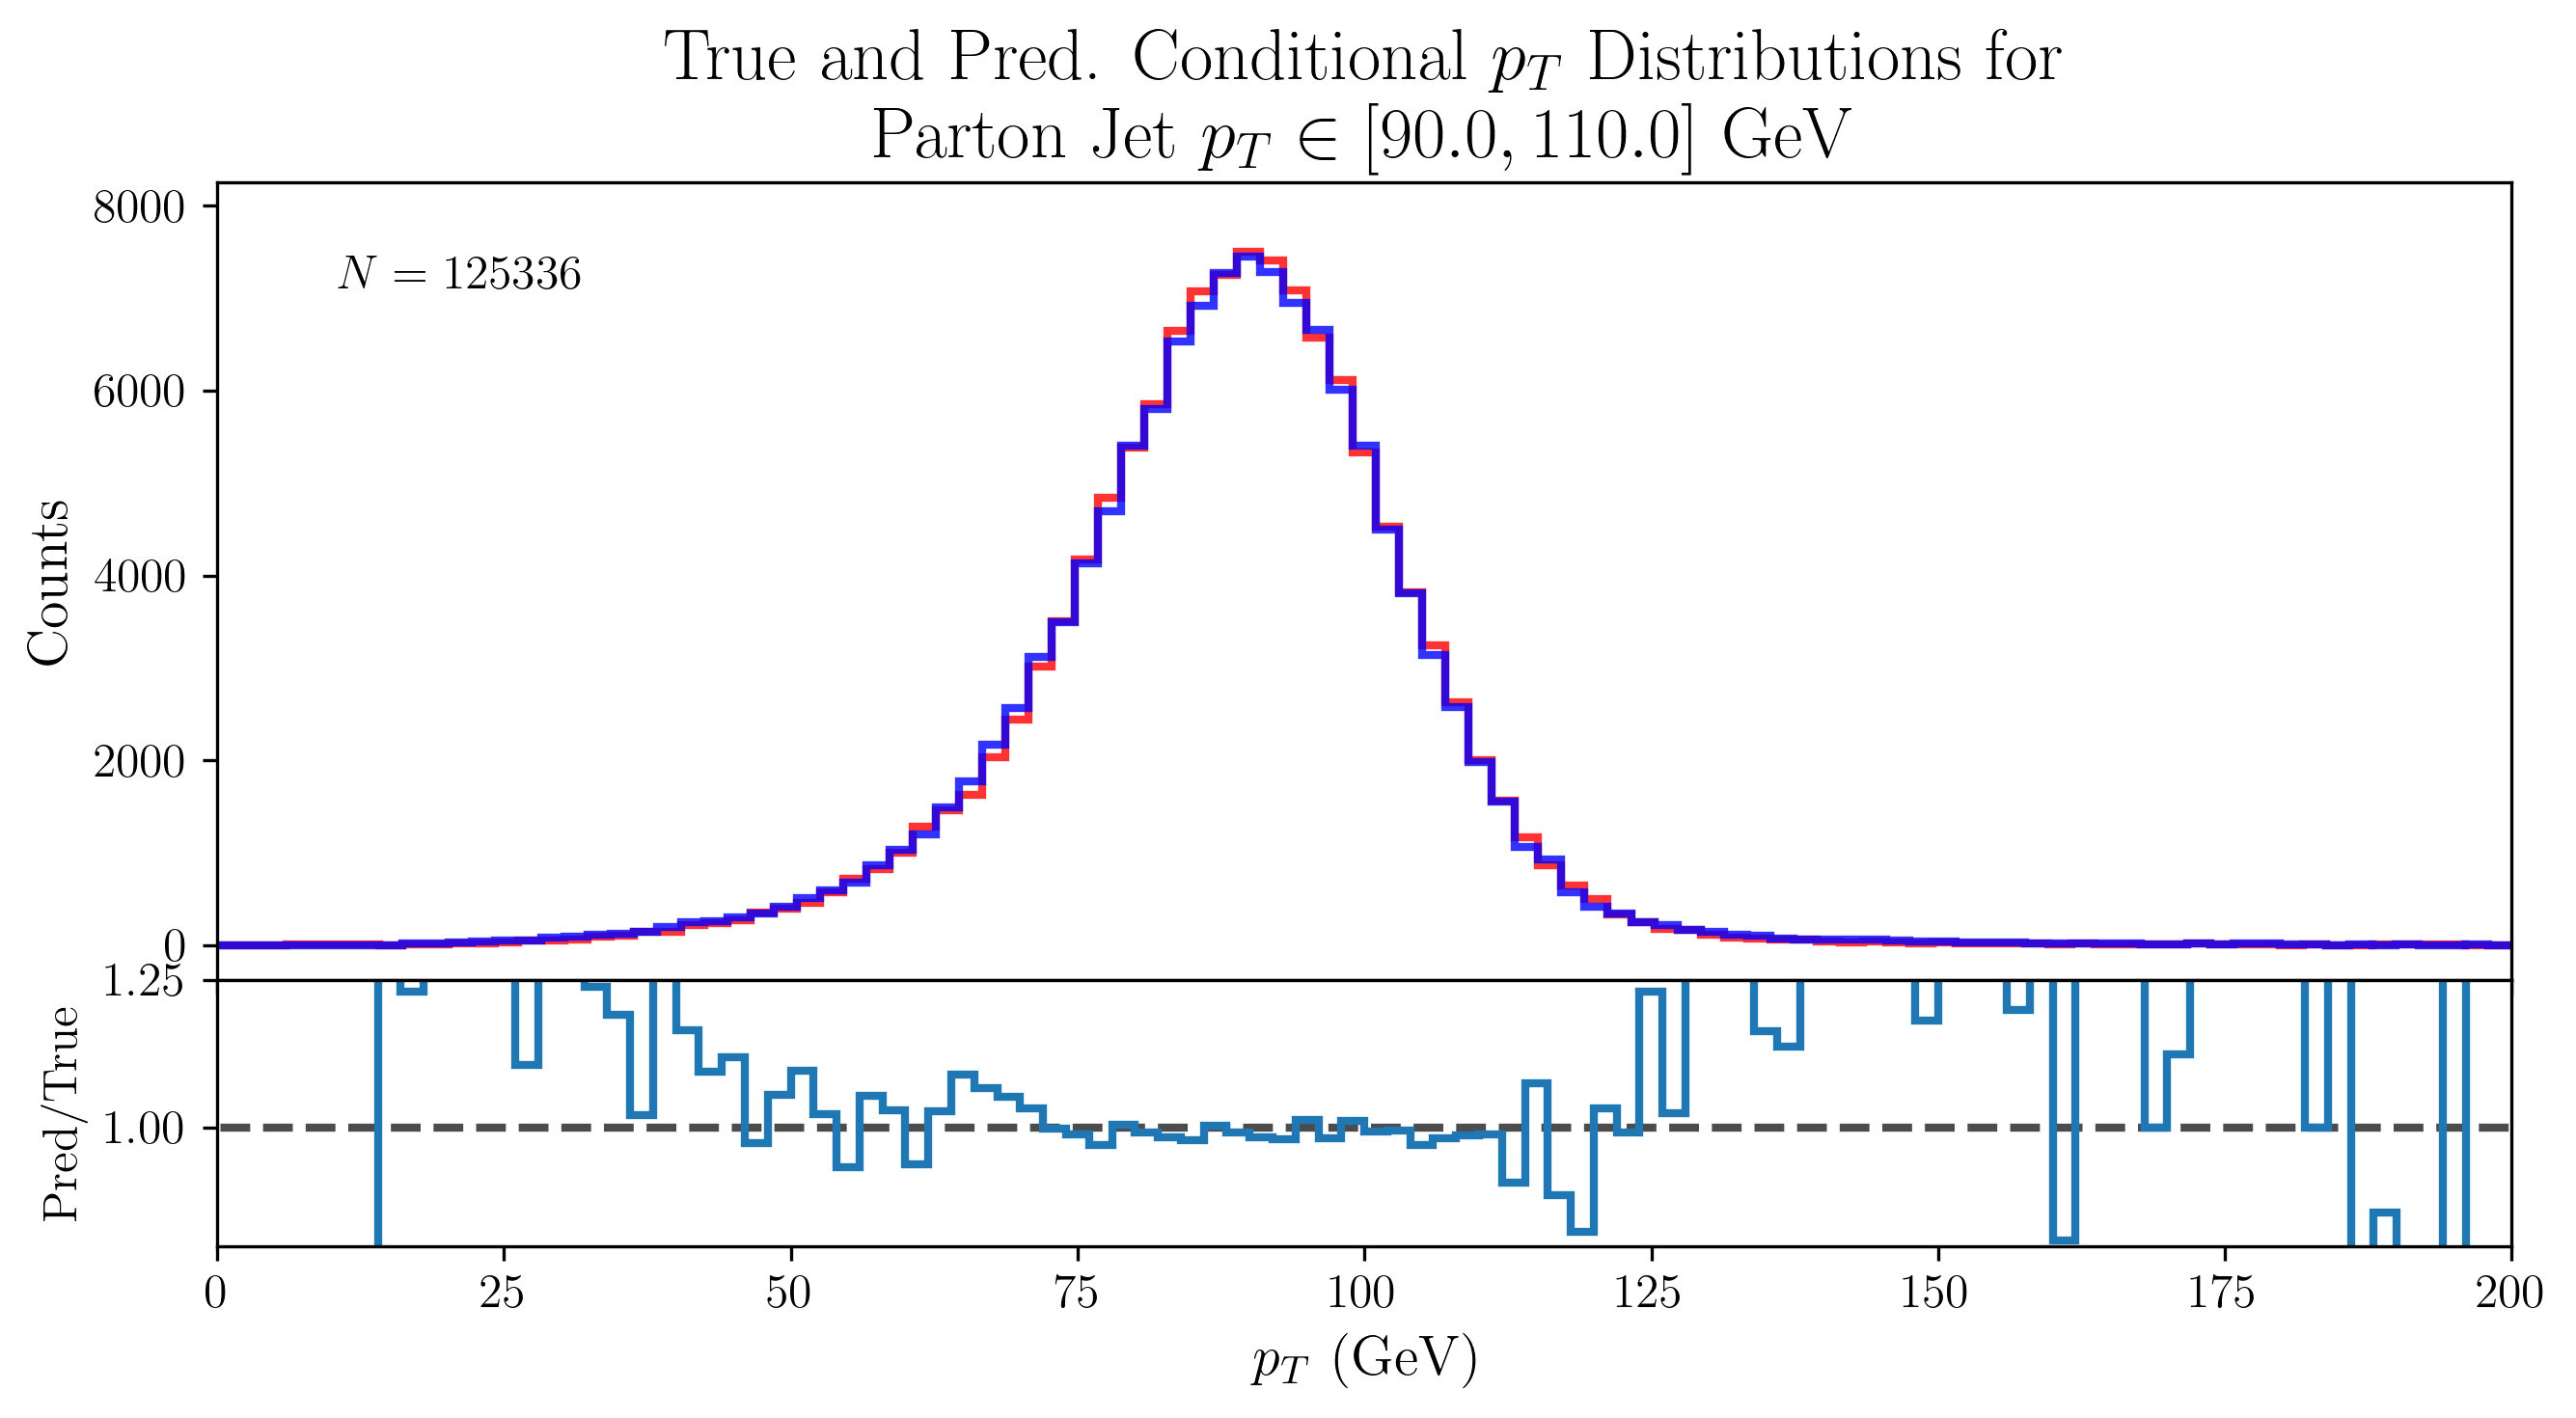

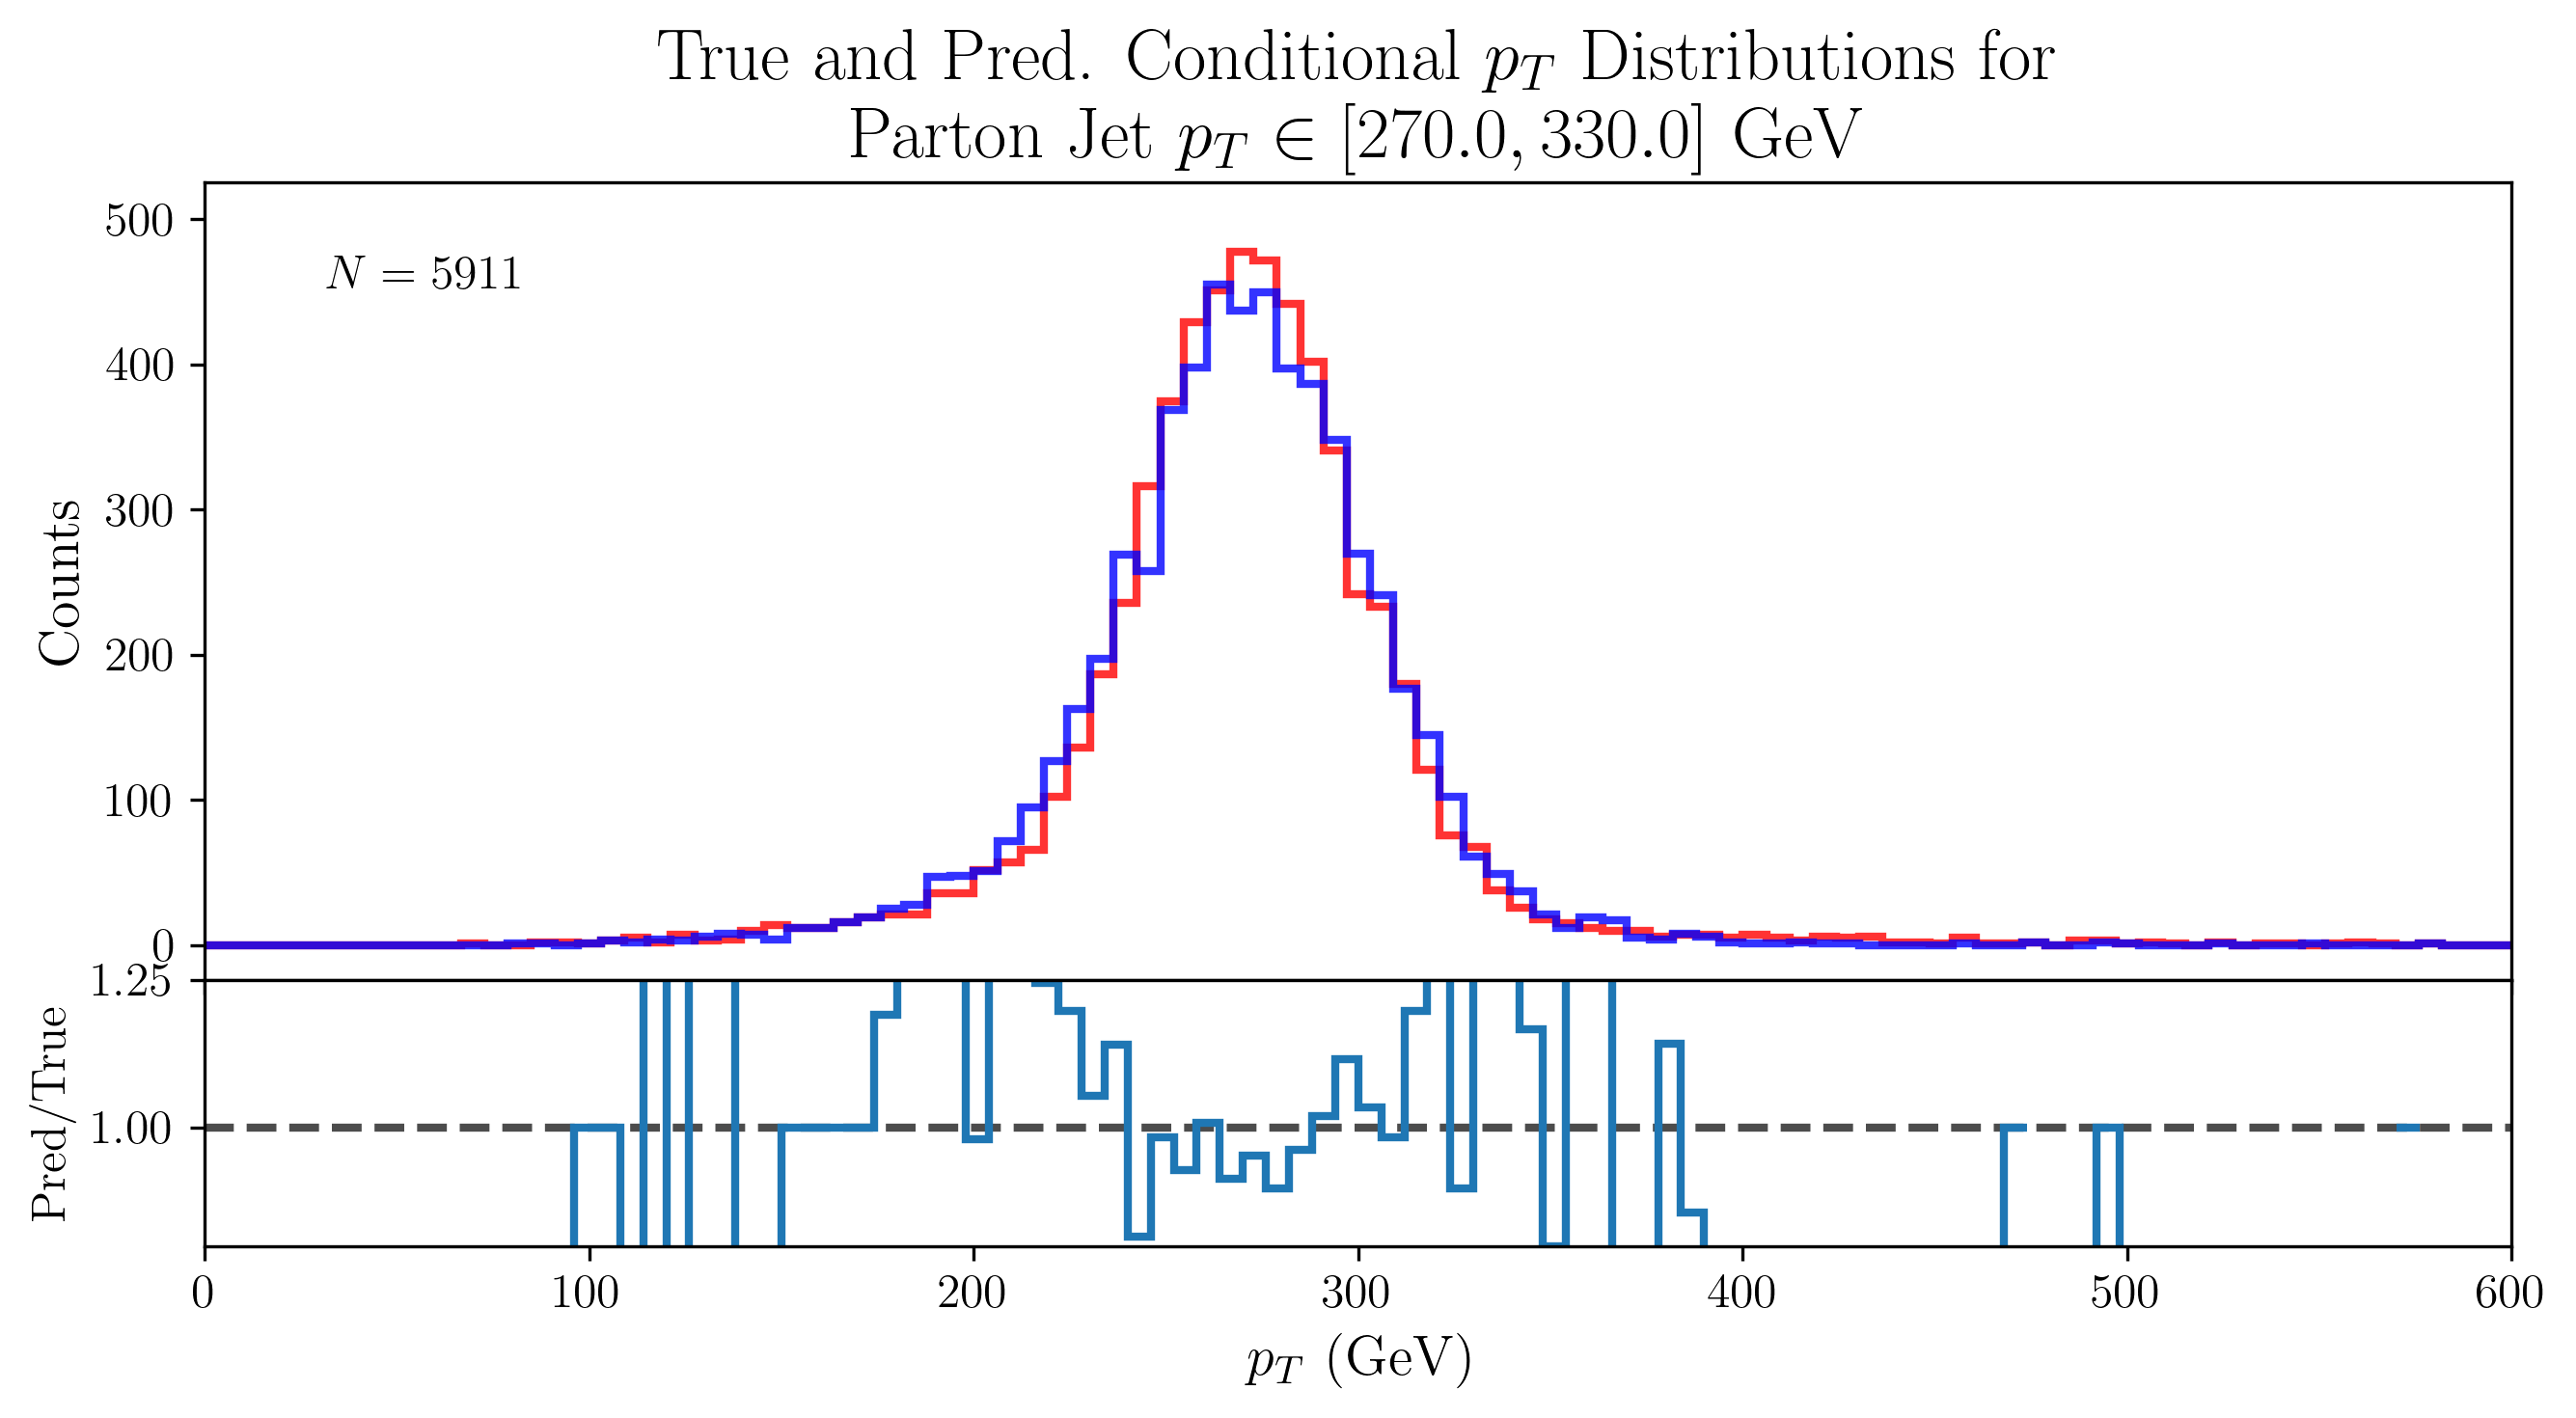

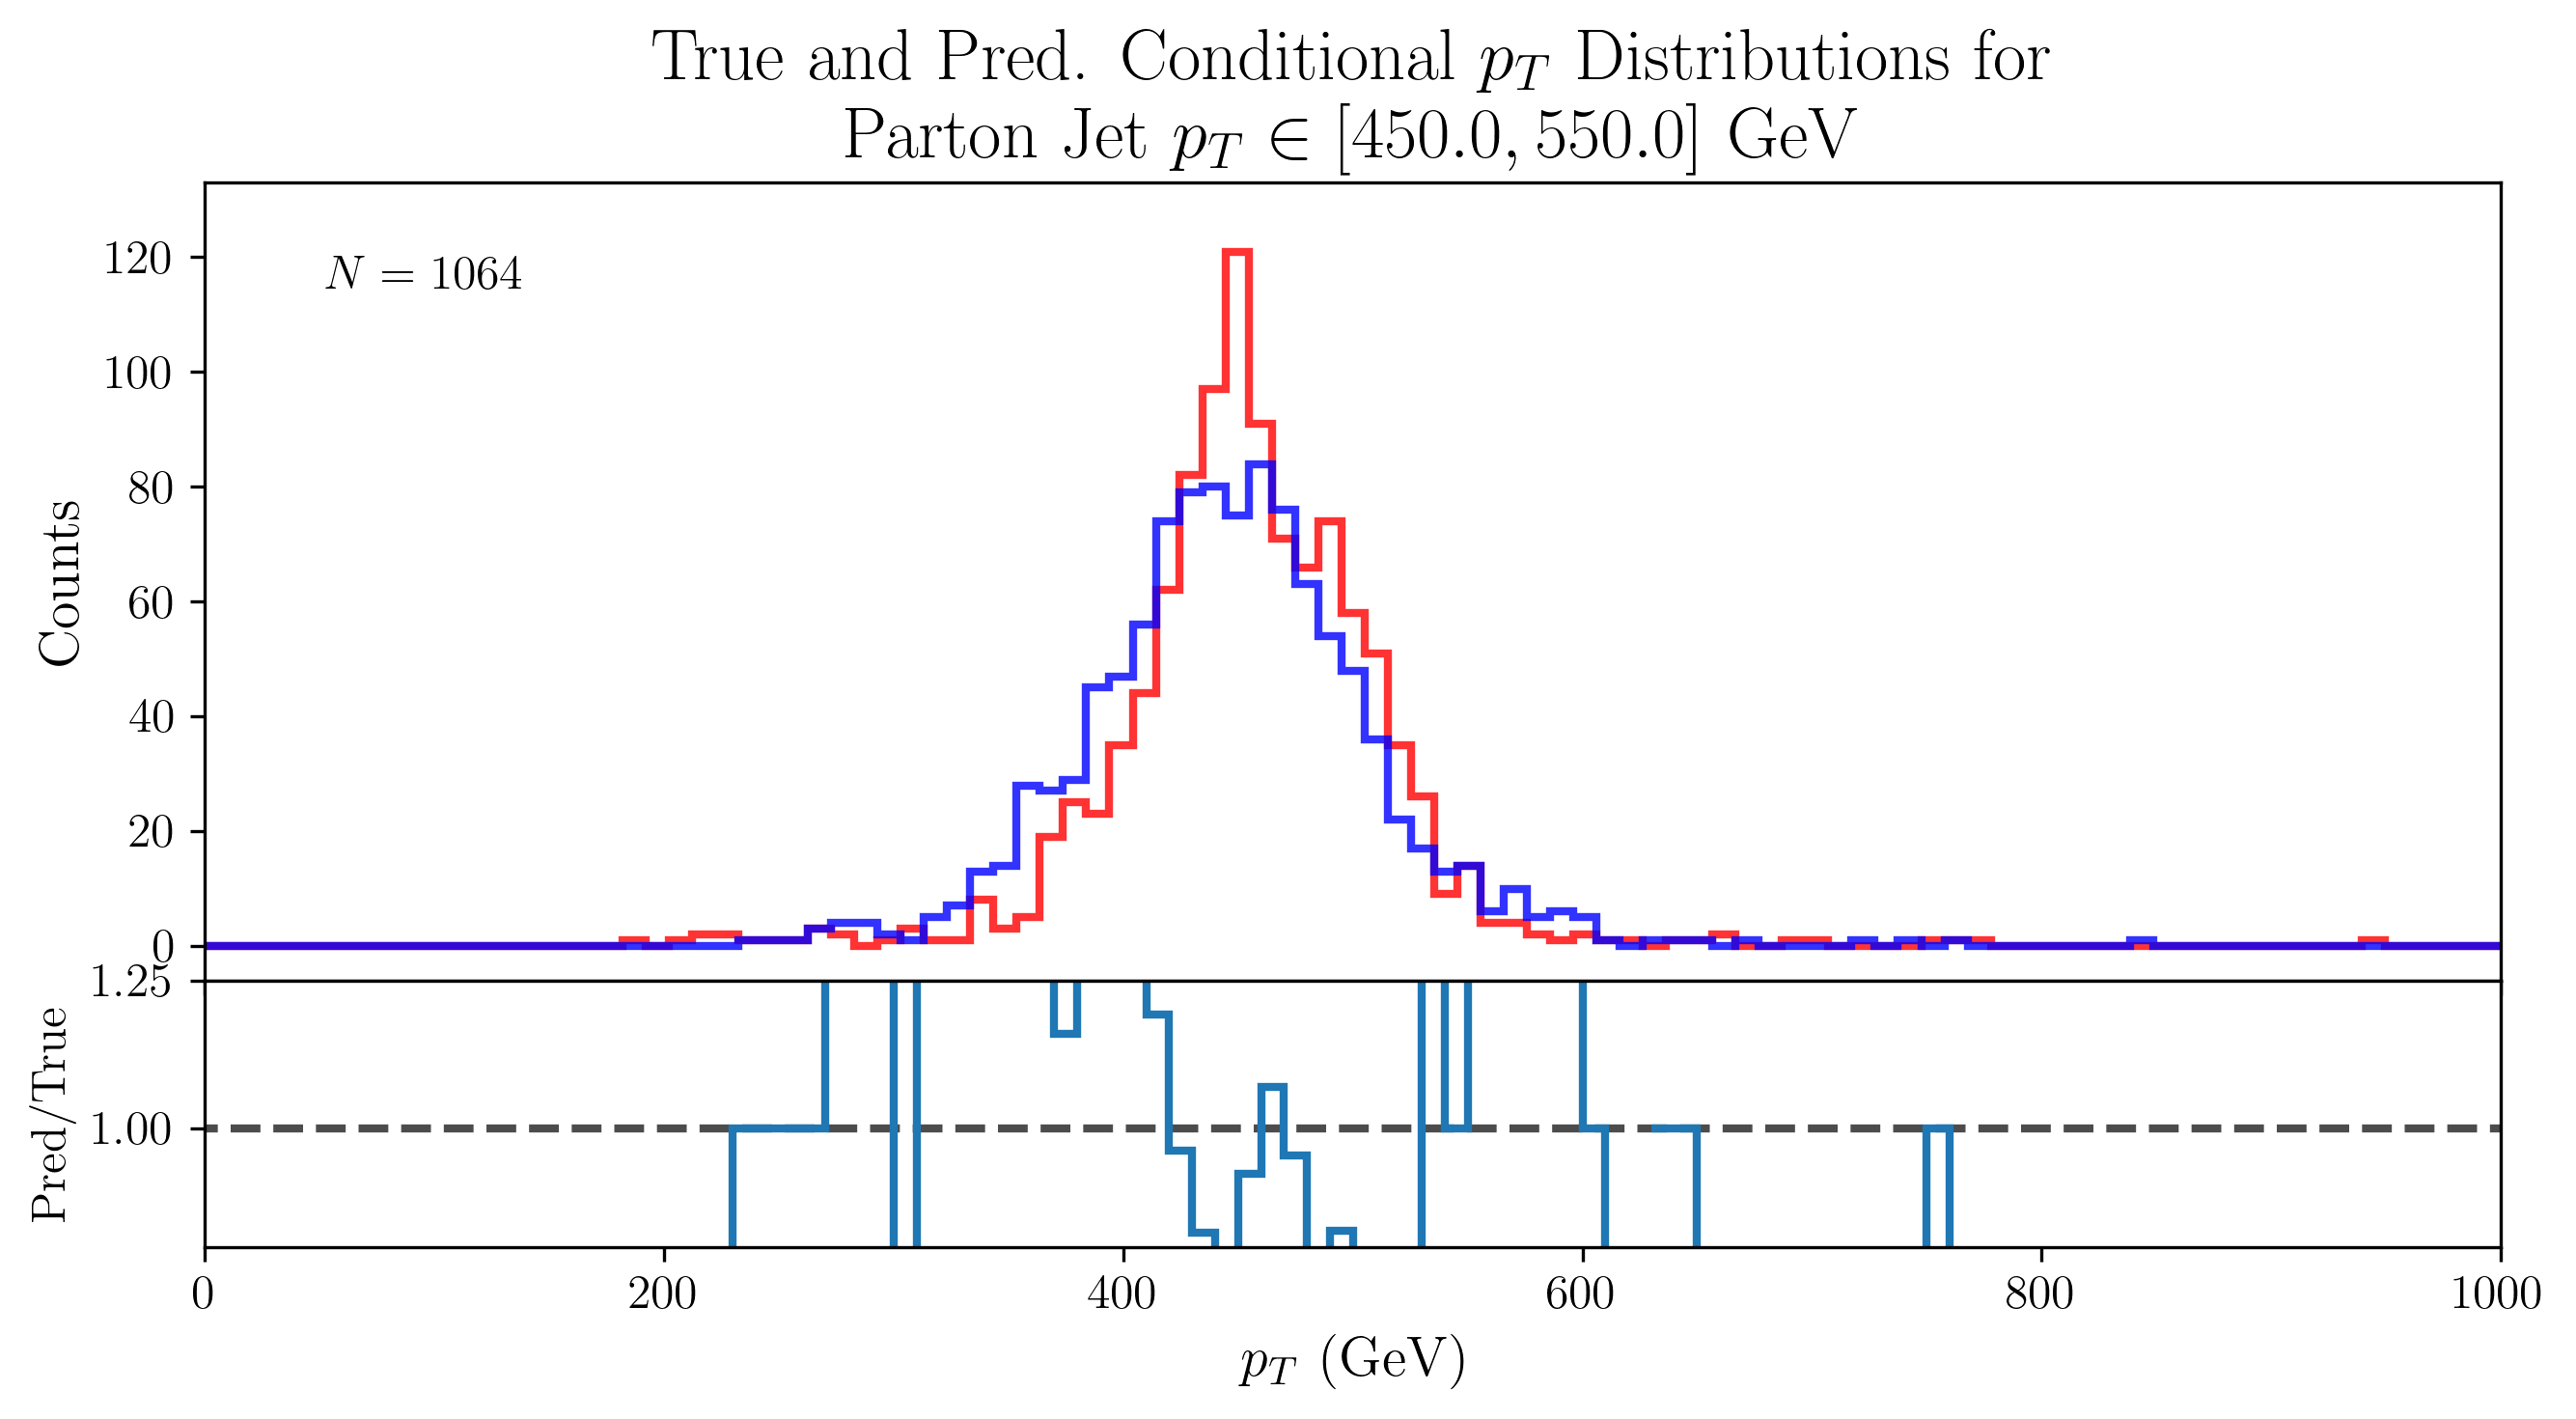

In [20]:
range_highs = [40, 200, 600, 1000]
range_lows = [0, 0, 0, 0, 0]
j = 0
for center in [20, 100, 300, 500]:  
    fig, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1], 'hspace': 0}, figsize=(9,5), dpi=300, sharex=True)
    recoPt = []
    predPt = []
    low = center - center/10
    high = center + center/10
    for i in range(len(data)):
        if (data[i, 0] > low and data[i, 0] < high):
            recoPt.append(data[i, 4])
            predPt.append(predict[i, 0])
        #if (len(recoPt) > 1400):
        #    break
    bins = np.linspace(range_lows[j], range_highs[j], 100)
    ax0.hist(recoPt, bins=bins, label=r'True Reco Jet $p_T$', alpha=0.8, ec="r", histtype='step', lw=2)
    ax0.hist(predPt, bins=bins, label=r'Pred. Reco Jet $p_T$', alpha=0.8, ec="b", histtype='step', lw=2)
    ax0.text(0.05*ax0.get_xlim()[1],0.9*ax0.get_ylim()[1], r"$N={}$".format(len(recoPt)), size=12)
    #ax.hist(energy, bins=bins, label='E', alpha=0.5)
    #if j==2 or j==3:
    ax0.set_ylabel("Counts", size=14)
    ax0.tick_params(axis='x', labelsize=12)
    ax0.tick_params(axis='y', labelsize=12)
    #ax[j].set_ylabel("Count")
    #ax[j].set_title("Parton Jet $P_t =${} GeV".format(center), size=10)
    ax0.set_title("\n".join(wrap(r"True and Pred. Conditional $p_T$ Distributions for Parton Jet $p_T \in [{}, {}]$ GeV".format(low, high), width=50)), fontsize=18)
    true_hist, _ = np.histogram(recoPt, bins=bins)
    pred_hist, _ = np.histogram(predPt, bins=bins)
    ax0.set_ylim(-0.05*np.max(true_hist), 1.1*np.max(true_hist))
    ax1.hist(bins[: 99], 99, weights=pred_hist/true_hist, histtype='step', lw=2)
    ax1.set_ylim(0.8, 1.25)
    ax1.set_ylabel(r'Pred/True', size=12)
    ax1.hlines(1.0, xmin=-100, xmax=1000, linestyle='dashed', color='black', lw=2, alpha=0.7)
    ax1.set_xlim(range_lows[j], range_highs[j])
    ax1.tick_params(axis='x', labelsize=12)
    ax1.tick_params(axis='y', labelsize=12)
    ax1.set_xlabel(r"$p_T$ (GeV)", size=14)
    #ax.axvline(x=center/2)
    #ax.text(-0.15, 0.9, letters[j], fontsize=10, transform=ax[j].transAxes, va='top', ha='right')
    if j ==0:
        ax0.legend(fontsize=14)
    fig.tight_layout()
    #fig.savefig("../data/plots/condPtDist{}.pdf".format(j), facecolor="white", transparent="True")
    j += 1

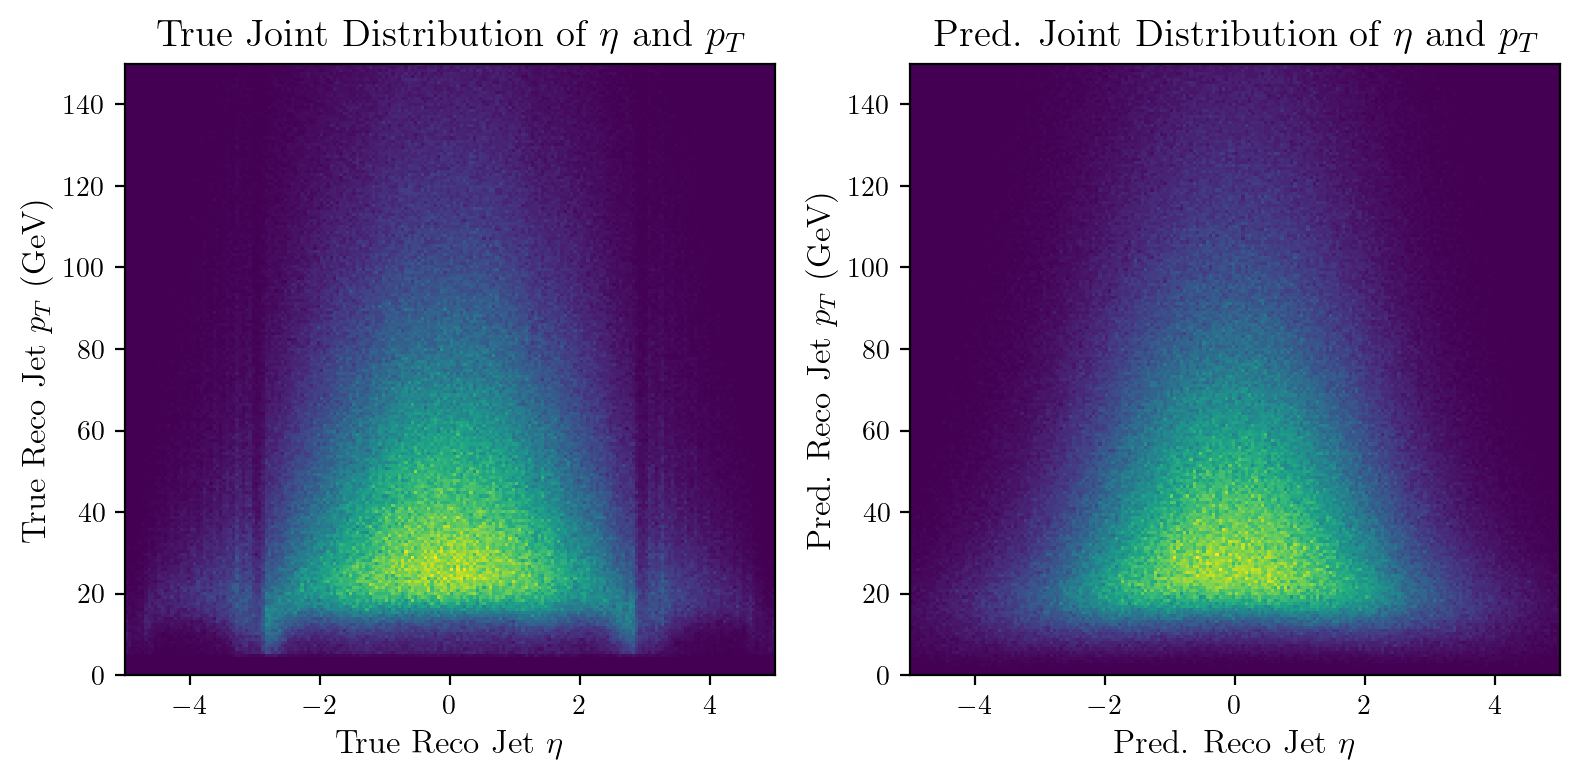

In [170]:
fig = plt.figure(figsize=(8,4), dpi=200)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
upper_end = 1000
x_low = -5
x_hi = 5
y_low = 0
y_hi = 150
num_bins=200

h2, xbins, ybins = np.histogram2d(data[:, 5], data[:, 4], range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
ax1.imshow(h2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi))#, cmap="Greys", norm=mcolors.LogNorm())
ax1.set_xlabel(r"True Reco Jet $\eta$", size=12)
ax1.set_ylabel(r"True Reco Jet $p_T$ (GeV)", size=12)
ax1.set_title("True Joint Distribution of $\eta$ and $p_T$", size=14)

z2, xbins, ybins = np.histogram2d(predict[:, 1], predict[:, 0], range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
ax2.imshow(z2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi))#, cmap="Greys", norm=mcolors.LogNorm())
ax2.set_xlabel(r"Pred. Reco Jet $\eta$", size=12)
ax2.set_ylabel(r"Pred. Reco Jet $p_T$ (GeV)", size=12)
ax2.set_title("Pred. Joint Distribution of $\eta$ and $p_T$", size=14)

plt.tight_layout()
plt.savefig("../data/plots/EtavsPt")
#plt.show()

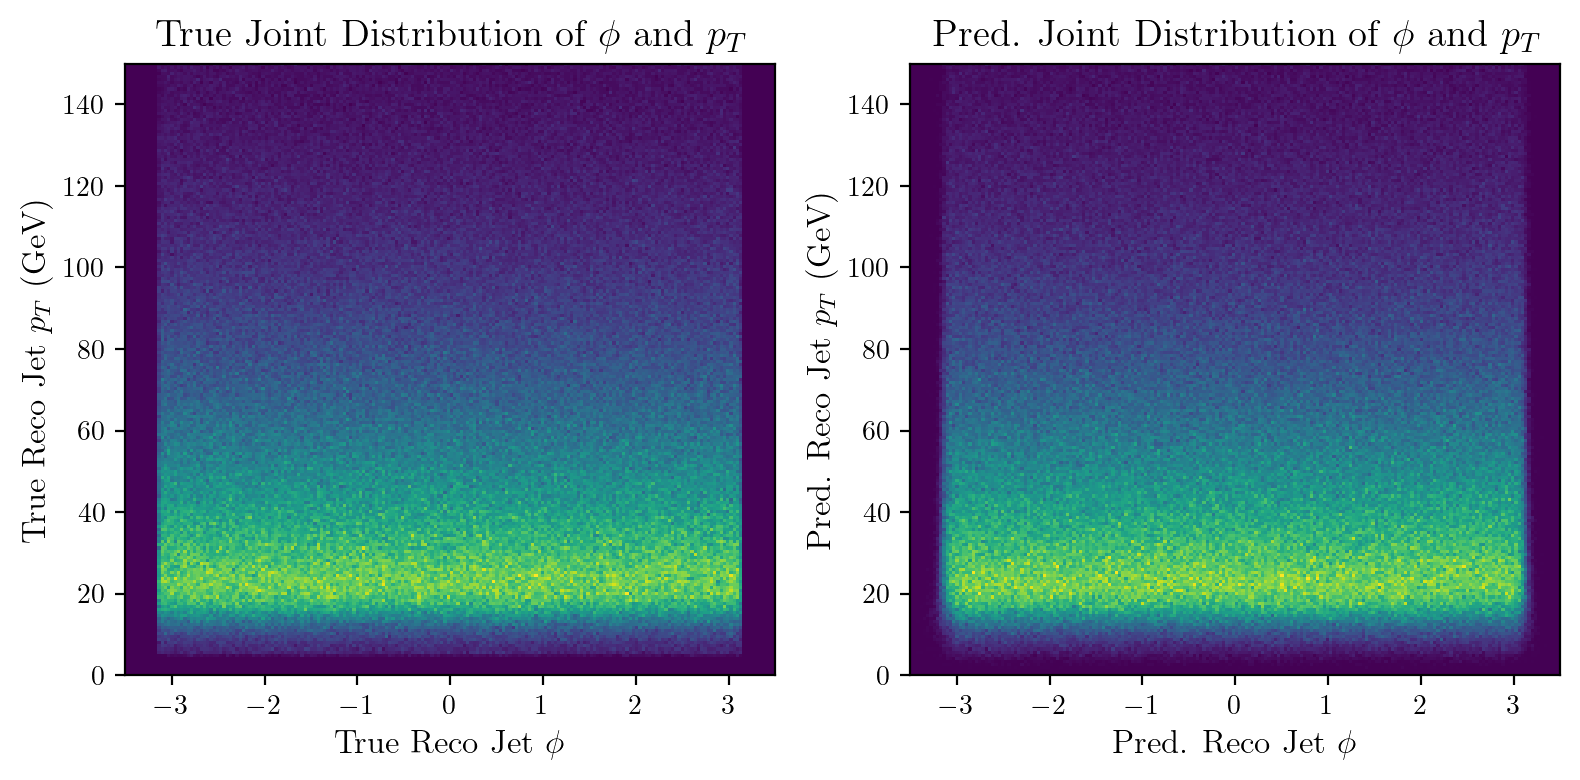

In [171]:
fig = plt.figure(figsize=(8,4), dpi=200)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
upper_end = 1000
x_low = -3.5
x_hi = 3.5
y_low = 0
y_hi = 150
num_bins=200

h2, xbins, ybins = np.histogram2d(data[:, 6], data[:, 4], range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
ax1.imshow(h2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi))#, cmap="Greys", norm=mcolors.LogNorm())
ax1.set_xlabel(r"True Reco Jet $\phi$", size=12)
ax1.set_ylabel(r"True Reco Jet $p_T$ (GeV)", size=12)
ax1.set_title("True Joint Distribution of $\phi$ and $p_T$", size=14)

z2, xbins, ybins = np.histogram2d(predict[:, 2], predict[:, 0], range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
ax2.imshow(z2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi))#, cmap="Greys", norm=mcolors.LogNorm())
ax2.set_xlabel(r"Pred. Reco Jet $\phi$", size=12)
ax2.set_ylabel(r"Pred. Reco Jet $p_T$ (GeV)", size=12)
ax2.set_title("Pred. Joint Distribution of $\phi$ and $p_T$", size=14)

plt.tight_layout()
plt.savefig("../data/plots/PhivsPt.png")
#plt.show()

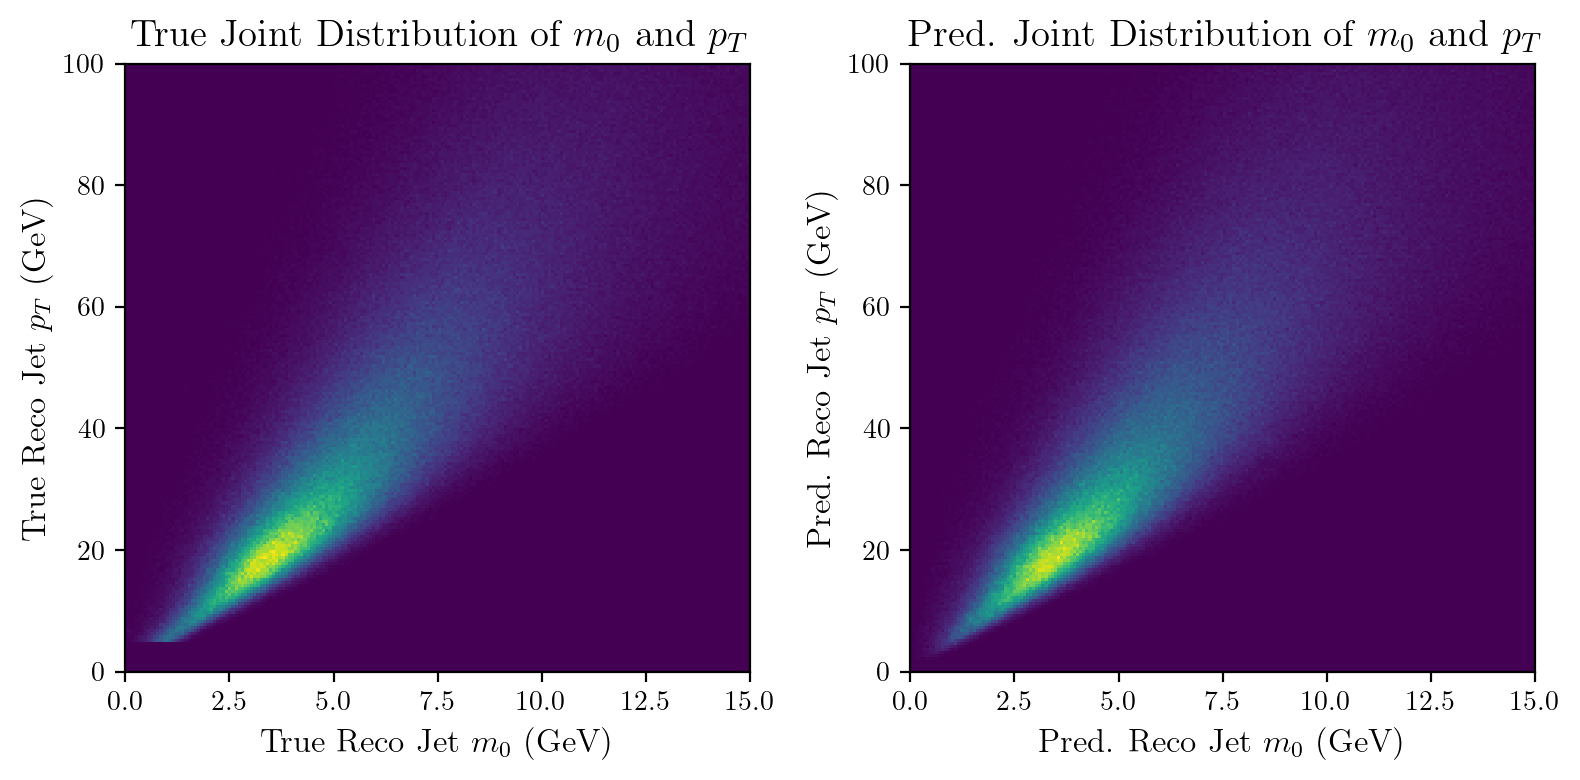

In [172]:
fig = plt.figure(figsize=(8,4), dpi=200)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
upper_end = 1000
x_low = 0
x_hi = 15
y_low = 0
y_hi = 100
num_bins=200

h2, xbins, ybins = np.histogram2d(data[:, 7], data[:, 4], range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
ax1.imshow(h2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi))#, cmap="Greys", norm=mcolors.LogNorm())
ax1.set_xlabel(r"True Reco Jet $m_0$ (GeV)", size=12)
ax1.set_ylabel(r"True Reco Jet $p_T$ (GeV)", size=12)
ax1.set_title("True Joint Distribution of $m_0$ and $p_T$", size=14)

z2, xbins, ybins = np.histogram2d(predict[:, 3], predict[:, 0], range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
ax2.imshow(z2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi))#, cmap="Greys", norm=mcolors.LogNorm())
ax2.set_xlabel(r"Pred. Reco Jet $m_0$ (GeV)", size=12)
ax2.set_ylabel(r"Pred. Reco Jet $p_T$ (GeV)", size=12)
ax2.set_title("Pred. Joint Distribution of $m_0$ and $p_T$", size=14)

plt.tight_layout()
plt.savefig("../data/plots/massvsPt.png")
#plt.show()

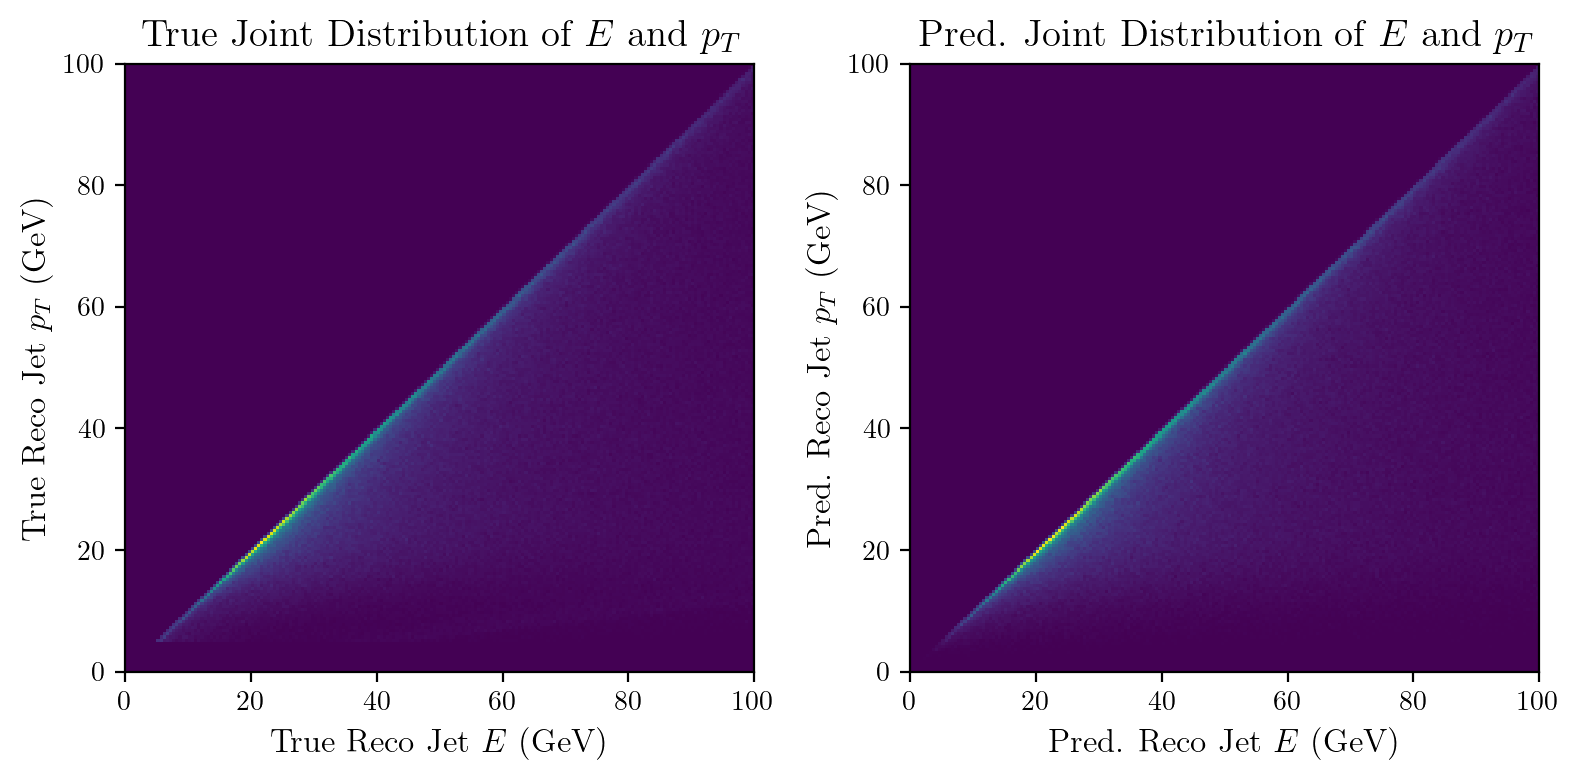

In [173]:
fig = plt.figure(figsize=(8,4), dpi=200)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
upper_end = 1000
x_low = 0
x_hi = 100
y_low = 0
y_hi = 100
num_bins=200

h2, xbins, ybins = np.histogram2d(np.sqrt(data[:, 7]**2 + (data[:, 4]*np.cosh(data[:, 5]))**2), data[:, 4], range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
ax1.imshow(h2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi))#, cmap="Greys", norm=mcolors.LogNorm())
ax1.set_xlabel(r"True Reco Jet $E$ (GeV)", size=12)
ax1.set_ylabel(r"True Reco Jet $p_T$ (GeV)", size=12)
ax1.set_title("True Joint Distribution of $E$ and $p_T$", size=14)

z2, xbins, ybins = np.histogram2d(np.sqrt(predict[:, 3]**2 + (predict[:, 0]*np.cosh(predict[:, 1]))**2), predict[:, 0], range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
ax2.imshow(z2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi))#, cmap="Greys", norm=mcolors.LogNorm())
ax2.set_xlabel(r"Pred. Reco Jet $E$ (GeV)", size=12)
ax2.set_ylabel(r"Pred. Reco Jet $p_T$ (GeV)", size=12)
ax2.set_title("Pred. Joint Distribution of $E$ and $p_T$", size=14)

plt.tight_layout()
plt.savefig("../data/plots/EvsPt.png")
#plt.show()

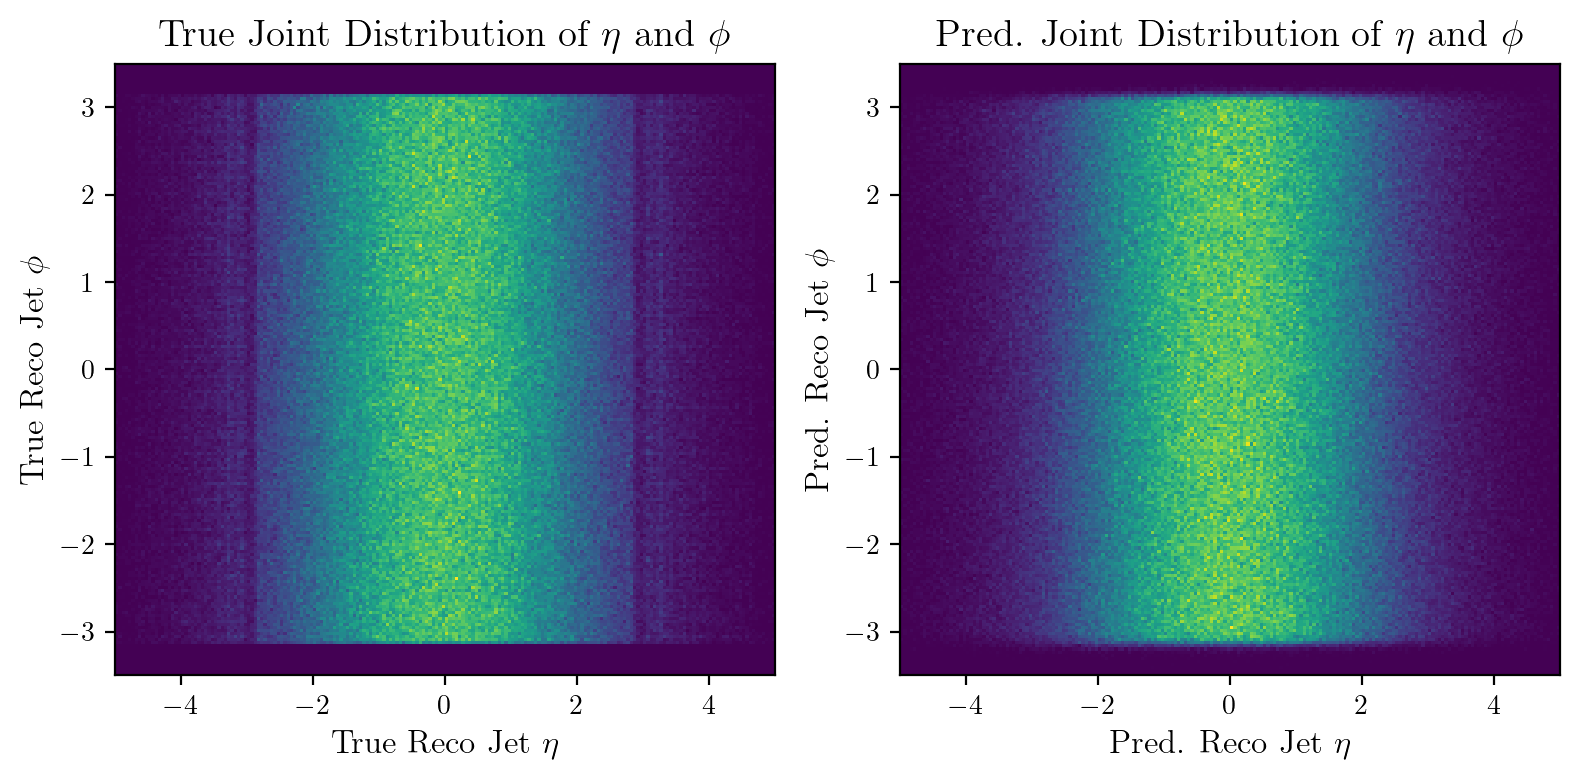

In [174]:
fig = plt.figure(figsize=(8,4), dpi=200)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
upper_end = 1000
x_low = -5
x_hi = 5
y_low = -3.5
y_hi = 3.5
num_bins=200

h2, xbins, ybins = np.histogram2d(data[:, 5], data[:, 6], range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
ax1.imshow(h2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi))#, cmap="Greys", norm=mcolors.LogNorm())
ax1.set_xlabel(r"True Reco Jet $\eta$", size=12)
ax1.set_ylabel(r"True Reco Jet $\phi$", size=12)
ax1.set_title("True Joint Distribution of $\eta$ and $\phi$", size=14)

z2, xbins, ybins = np.histogram2d(predict[:, 1], predict[:, 2], range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
ax2.imshow(z2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi))#, cmap="Greys", norm=mcolors.LogNorm())
ax2.set_xlabel(r"Pred. Reco Jet $\eta$", size=12)
ax2.set_ylabel(r"Pred. Reco Jet $\phi$", size=12)
ax2.set_title("Pred. Joint Distribution of $\eta$ and $\phi$", size=14)

plt.tight_layout()
plt.savefig("../data/plots/etavsPhi.png")
#plt.show()

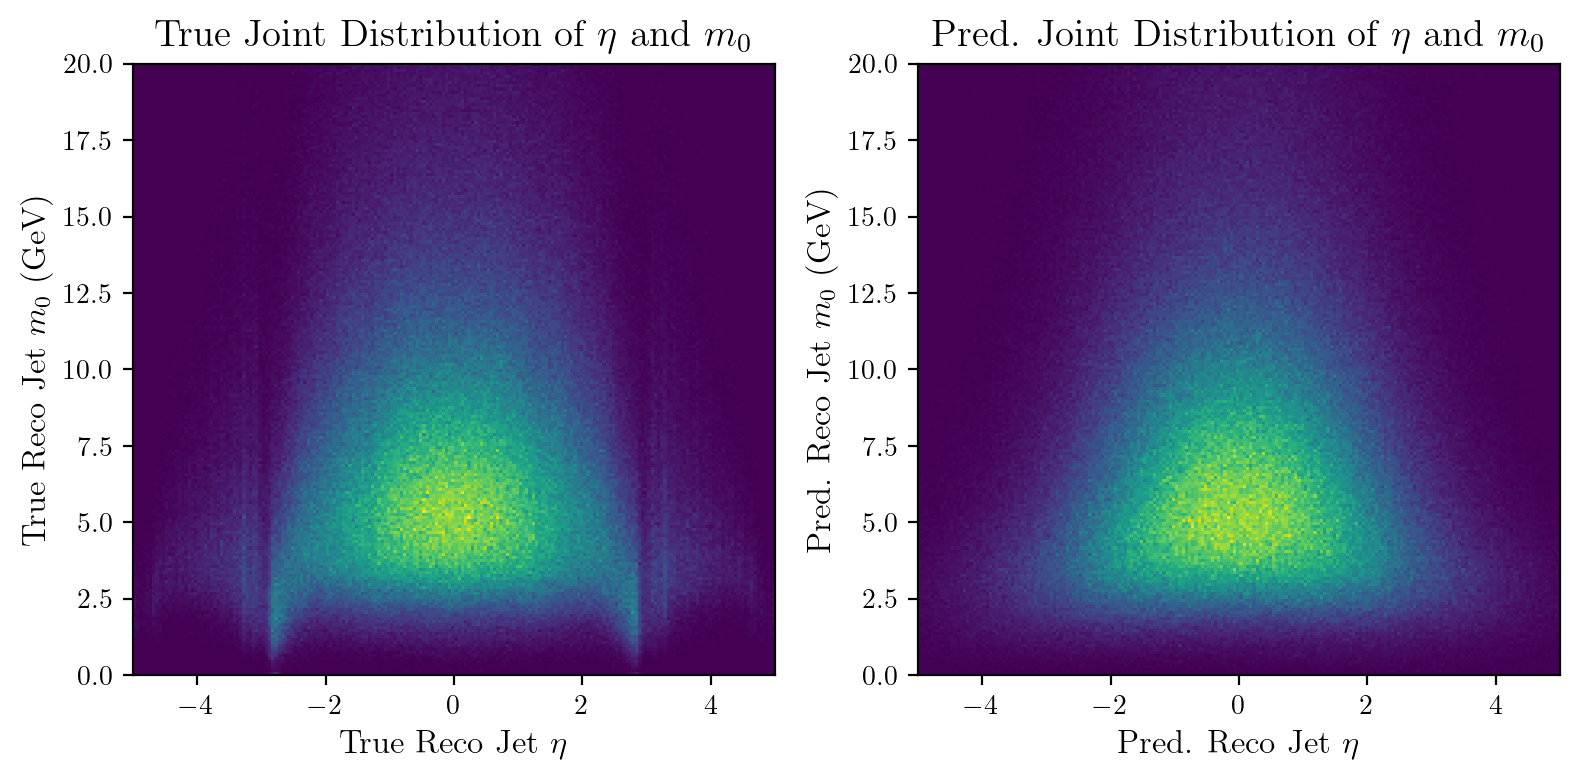

In [175]:
fig = plt.figure(figsize=(8,4), dpi=200)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
upper_end = 1000
x_low = -5
x_hi = 5
y_low = 0
y_hi = 20
num_bins=200

h2, xbins, ybins = np.histogram2d(data[:, 5], data[:, 7], range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
ax1.imshow(h2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi))#, cmap="Greys", norm=mcolors.LogNorm())
ax1.set_xlabel(r"True Reco Jet $\eta$", size=12)
ax1.set_ylabel(r"True Reco Jet $m_0$ (GeV)", size=12)
ax1.set_title("True Joint Distribution of $\eta$ and $m_0$", size=14)

z2, xbins, ybins = np.histogram2d(predict[:, 1], predict[:, 3], range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
ax2.imshow(z2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi))#, cmap="Greys", norm=mcolors.LogNorm())
ax2.set_xlabel(r"Pred. Reco Jet $\eta$", size=12)
ax2.set_ylabel(r"Pred. Reco Jet $m_0$ (GeV)", size=12)
ax2.set_title("Pred. Joint Distribution of $\eta$ and $m_0$", size=14)

plt.tight_layout()
plt.savefig("../data/plots/etavsmass.png")
#plt.show()

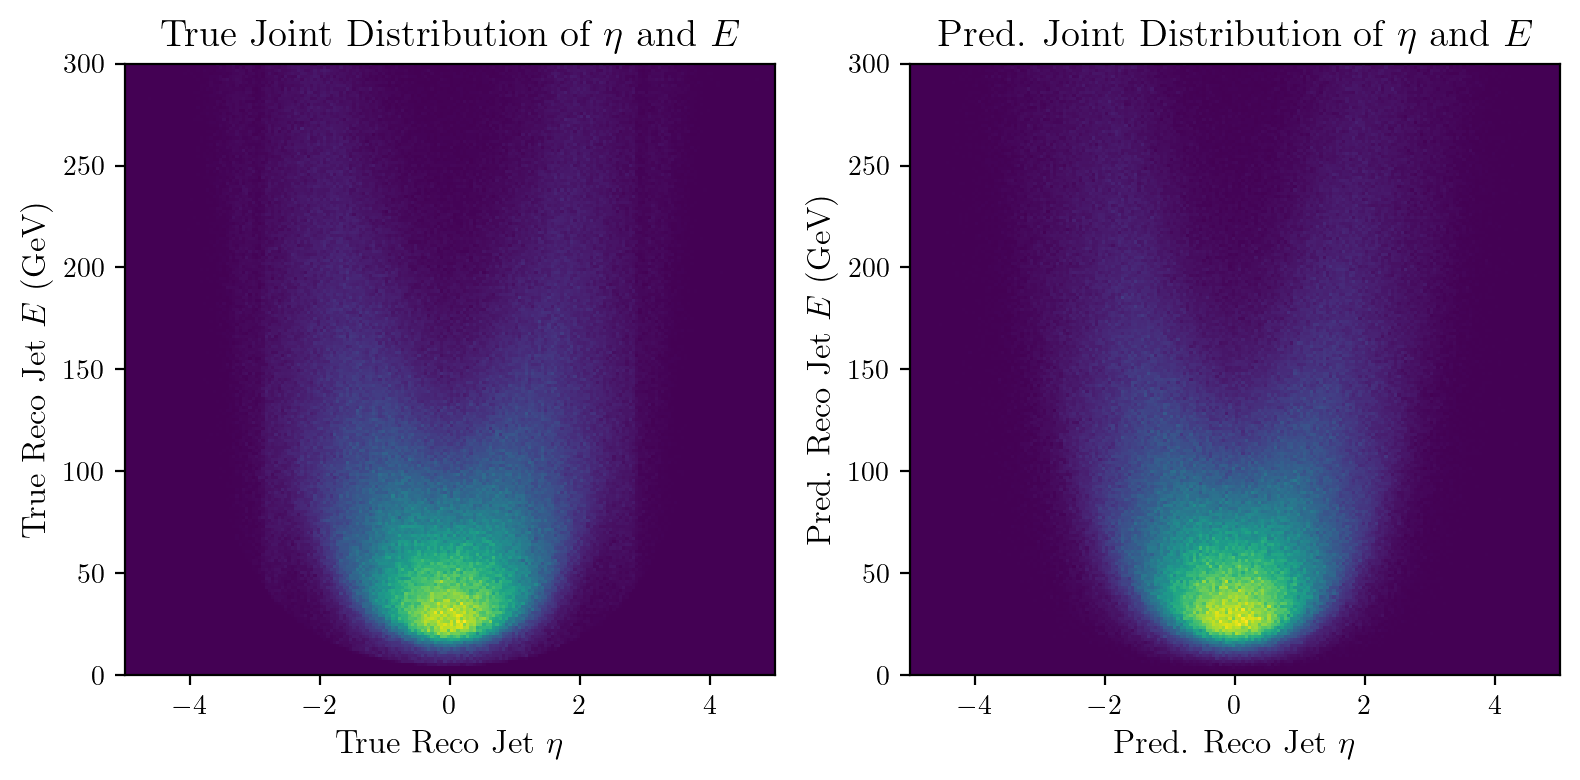

In [176]:
fig = plt.figure(figsize=(8,4), dpi=200)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
upper_end = 1000
x_low = -5
x_hi = 5
y_low = 0
y_hi = 300
num_bins=200

h2, xbins, ybins = np.histogram2d(data[:, 5], np.sqrt(data[:, 7]**2 + (data[:, 4]*np.cosh(data[:, 5]))**2), range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
ax1.imshow(h2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi))#, cmap="Greys", norm=mcolors.LogNorm())
ax1.set_xlabel(r"True Reco Jet $\eta$", size=12)
ax1.set_ylabel(r"True Reco Jet $E$ (GeV)", size=12)
ax1.set_title("True Joint Distribution of $\eta$ and $E$", size=14)

z2, xbins, ybins = np.histogram2d(predict[:, 1], np.sqrt(predict[:, 3]**2 + (predict[:, 0]*np.cosh(predict[:, 1]))**2), range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
ax2.imshow(z2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi))#, cmap="Greys", norm=mcolors.LogNorm())
ax2.set_xlabel(r"Pred. Reco Jet $\eta$", size=12)
ax2.set_ylabel(r"Pred. Reco Jet $E$ (GeV)", size=12)
ax2.set_title("Pred. Joint Distribution of $\eta$ and $E$", size=14)

plt.tight_layout()
plt.savefig("../data/plots/etavsE.png")
#plt.show()

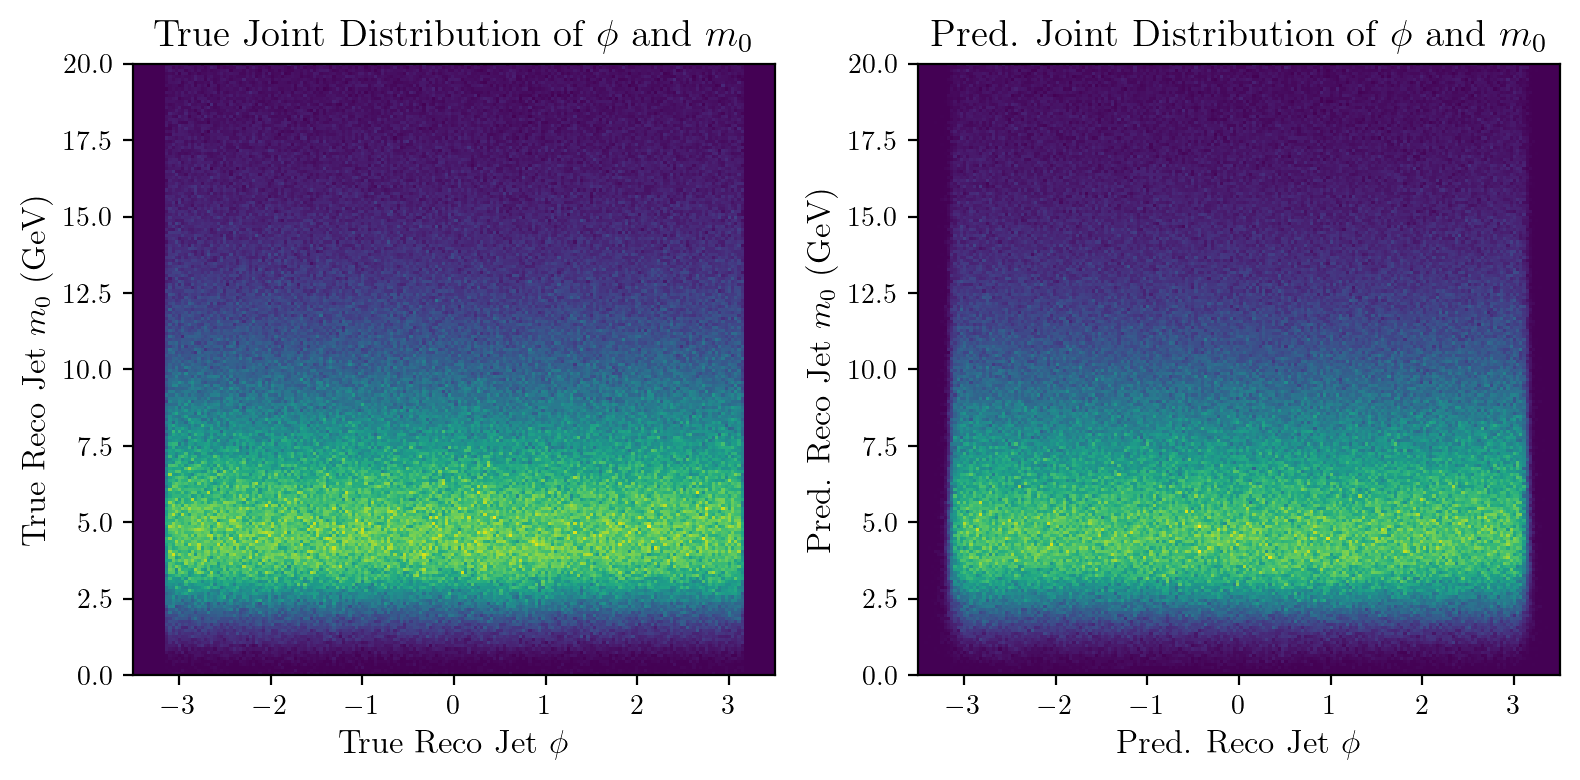

In [177]:
fig = plt.figure(figsize=(8,4), dpi=200)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
upper_end = 1000
x_low = -3.5
x_hi = 3.5
y_low = 0
y_hi = 20
num_bins=200

h2, xbins, ybins = np.histogram2d(data[:, 6], data[:, 7], range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
ax1.imshow(h2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi))#, cmap="Greys", norm=mcolors.LogNorm())
ax1.set_xlabel(r"True Reco Jet $\phi$", size=12)
ax1.set_ylabel(r"True Reco Jet $m_0$ (GeV)", size=12)
ax1.set_title("True Joint Distribution of $\phi$ and $m_0$", size=14)

z2, xbins, ybins = np.histogram2d(predict[:, 2], predict[:, 3], range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
ax2.imshow(z2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi))#, cmap="Greys", norm=mcolors.LogNorm())
ax2.set_xlabel(r"Pred. Reco Jet $\phi$", size=12)
ax2.set_ylabel(r"Pred. Reco Jet $m_0$ (GeV)", size=12)
ax2.set_title("Pred. Joint Distribution of $\phi$ and $m_0$", size=14)

plt.tight_layout()
plt.savefig("../data/plots/phivsmass.png")
plt.show()

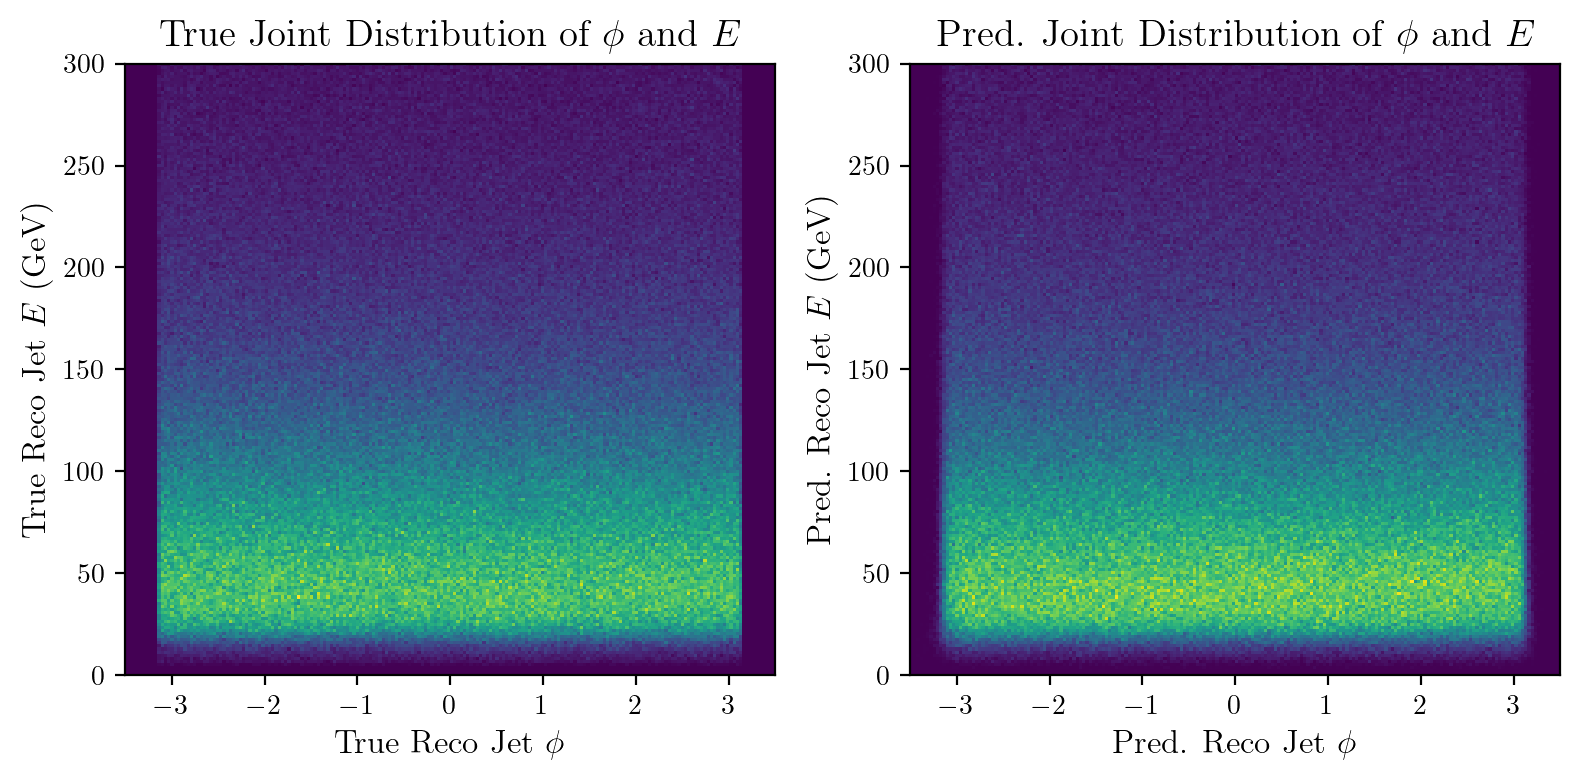

In [178]:
fig = plt.figure(figsize=(8,4), dpi=200)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
upper_end = 1000
x_low = -3.5
x_hi = 3.5
y_low = 0
y_hi = 300
num_bins=200

h2, xbins, ybins = np.histogram2d(data[:, 6], np.sqrt(data[:, 7]**2 + (data[:, 4]*np.cosh(data[:, 5]))**2), range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
ax1.imshow(h2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi))#, cmap="Greys", norm=mcolors.LogNorm())
ax1.set_xlabel(r"True Reco Jet $\phi$", size=12)
ax1.set_ylabel(r"True Reco Jet $E$ (GeV)", size=12)
ax1.set_title("True Joint Distribution of $\phi$ and $E$", size=14)

z2, xbins, ybins = np.histogram2d(predict[:, 2], np.sqrt(predict[:, 3]**2 + (predict[:, 0]*np.cosh(predict[:, 1]))**2), range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
ax2.imshow(z2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi))#, cmap="Greys", norm=mcolors.LogNorm())
ax2.set_xlabel(r"Pred. Reco Jet $\phi$", size=12)
ax2.set_ylabel(r"Pred. Reco Jet $E$ (GeV)", size=12)
ax2.set_title("Pred. Joint Distribution of $\phi$ and $E$", size=14)

plt.tight_layout()
plt.savefig("../data/plots/phivsE.png")
#plt.show()

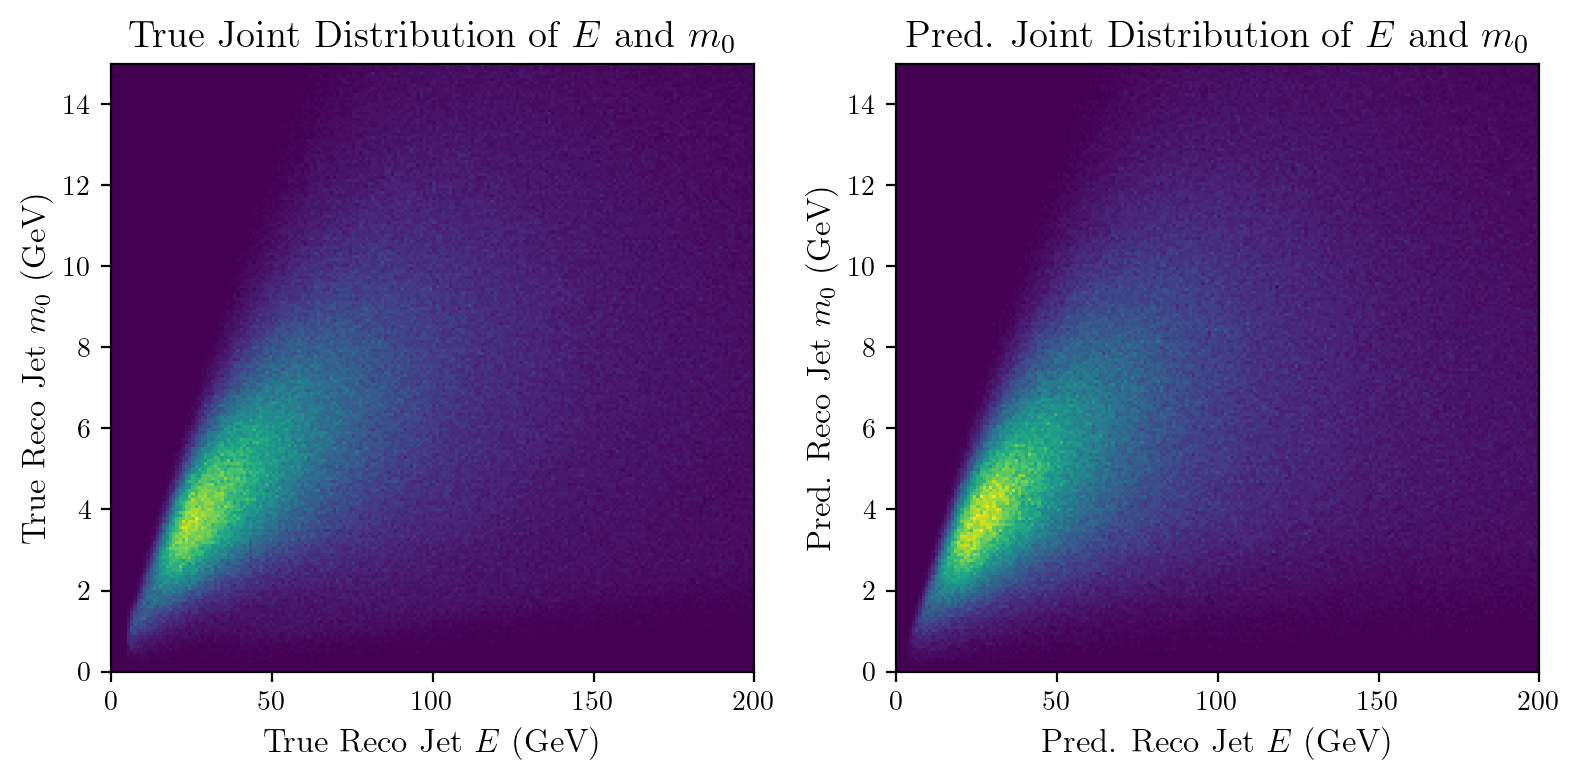

In [179]:
fig = plt.figure(figsize=(8,4), dpi=200)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
upper_end = 1000
x_low = 0
x_hi = 200
y_low = 0
y_hi = 15
num_bins=200

h2, xbins, ybins = np.histogram2d(np.sqrt(data[:, 7]**2 + (data[:, 4]*np.cosh(data[:, 5]))**2), data[:, 7], range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
ax1.imshow(h2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi))#, cmap="Greys", norm=mcolors.LogNorm())
ax1.set_xlabel(r"True Reco Jet $E$ (GeV)", size=12)
ax1.set_ylabel(r"True Reco Jet $m_0$ (GeV)", size=12)
ax1.set_title("True Joint Distribution of $E$ and $m_0$", size=14)

z2, xbins, ybins = np.histogram2d(np.sqrt(predict[:, 3]**2 + (predict[:, 0]*np.cosh(predict[:, 1]))**2), predict[:, 3], range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
ax2.imshow(z2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi))#, cmap="Greys", norm=mcolors.LogNorm())
ax2.set_xlabel(r"Pred. Reco Jet $E$ (GeV)", size=12)
ax2.set_ylabel(r"Pred. Reco Jet $m_0$ (GeV)", size=12)
ax2.set_title("Pred. Joint Distribution of $E$ and $m_0$", size=14)

plt.tight_layout()
plt.savefig("../data/plots/Evsmass.png")
#plt.show()